# 코드잇_DA2기_고급프로젝트

In [5]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import plotly.express as px
import scipy.stats as stats
import mysql.connector
from datetime import datetime
import orjson
import os
import ast
import missingno as msno
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import chi2_contingency, ttest_ind, pearsonr

## 데이터 가져오기

In [6]:
from utils_database import get_database_connection, fetch_table_dataframes, close_connection
from utils_config import DB_CONFIG

# 테이블 이름별 변수명 매핑
table_name_map = {
    "accounts_attendance": "df_attendance",
    "accounts_blockrecord": "df_block",
    "accounts_failpaymenthistory": "df_fail_payment",
    "accounts_friendrequest": "df_friend_request",
    "accounts_group": "df_group",
    "accounts_nearbyschool": "df_nearby_school",
    "accounts_paymenthistory": "df_payment",
    "accounts_user_contacts": "df_user_contacts",
    "accounts_pointhistory": "df_point_history",
    "accounts_school": "df_school",
    "accounts_timelinereport": "df_report",
    "accounts_user": "df_user",
    "accounts_userquestionrecord": "df_vote",
    "accounts_userwithdraw": "df_withdraw",
    "event_receipts": "df_event_receipts",
    "events": "df_events",
    "polls_question": "df_question",
    "polls_questionpiece": "df_question_piece",
    "polls_questionreport": "df_question_report",
    "polls_questionset": "df_question_set",
    "polls_usercandidate": "df_question_show_user"
}

# DB 연결 및 데이터 가져오기
connection = get_database_connection(**DB_CONFIG)
dataframes = fetch_table_dataframes(connection, table_name_map)
close_connection(connection)

# 개별 변수로 변환 (글로벌 변수 설정)
for table_name, df in dataframes.items():
    globals()[table_name] = df
    print(f"Created variable: {table_name}")

c:\Users\a0_0g\codeit_study\minsu_did_all\utils_database.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframes[df_name] = pd.read_sql(query, connection)


Created variable: df_attendance
Created variable: df_block
Created variable: df_fail_payment
Created variable: df_friend_request
Created variable: df_group
Created variable: df_nearby_school
Created variable: df_payment
Created variable: df_point_history
Created variable: df_school
Created variable: df_report
Created variable: df_user
Created variable: df_user_contacts
Created variable: df_vote
Created variable: df_withdraw
Created variable: df_event_receipts
Created variable: df_events
Created variable: df_question
Created variable: df_question_piece
Created variable: df_question_report
Created variable: df_question_set
Created variable: df_question_show_user


In [7]:
# 각 DataFrame의 info
for table_name, _ in dataframes.items():
    print(table_name)
    print(f'{globals()[table_name].info()}')
    print("\n")

df_attendance
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB
None


df_block
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19482 non-null  int64         
 1   reason         19482 non-null  object        
 2   created_at     19482 non-null  datetime64[ns]
 3   block_user_id  19482 non-null  int64         
 4   user_id        19482 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 761.1+ KB
None


df_fail_paym

In [8]:
def load_json_files(json_dir, file_list, chunksize=100_000):
    """주어진 디렉토리에서 특정 JSON 파일만 읽어 DataFrame으로 병합 (청크 단위로 처리)"""
    df_list = []

    for file in file_list:
        file_path = os.path.join(json_dir, file)

        if os.path.exists(file_path):
            print(f'📂 병합 진행중: {file}')

            with open(file_path, 'rb') as f:
                data = orjson.loads(f.read())  # JSON 전체 로드
                
            df_new = pd.DataFrame(data)
            
            # ✅ 모든 데이터가 df_list에 저장되므로 유실 없음
            for start in range(0, len(df_new), chunksize):
                df_list.append(df_new.iloc[start:start+chunksize])

        else:
            print(f'🚨 파일 없음: {file}')

    # ✅ 모든 청크를 안전하게 병합
    return pd.concat(df_list, axis=0, ignore_index=True)

# JSON 파일 경로
read_path = 'data/hackle/json'

# JSON 파일 리스트
files_2308 = ['2023-08-10.json', '2023-08-16.json', '2023-08-22.json', '2023-08-28.json', '2023-09-03.json']
files_2309 = ['2023-08-28.json', '2023-09-03.json', '2023-09-09.json', '2023-09-15.json', '2023-09-21.json', '2023-09-27.json']
files_230810 = ['2023-08-16.json', '2023-08-22.json', '2023-08-28.json', '2023-09-03.json', '2023-09-09.json', '2023-09-15.json', '2023-09-21.json', '2023-09-27.json', '2023-10-03.json', '2023-10-09.json', '2023-10-15.json', '2023-10-21.json', '2023-10-27.json'] 

# JSON을 DataFrame으로 변환
df_2308 = load_json_files(read_path, files_2308)
df_2309 = load_json_files(read_path, files_2309)
df_230810 = load_json_files(read_path, files_230810)

# ✅ 데이터 미리보기
print("✅ df_2308 미리보기:\n", df_2308.head())
print("✅ df_2309 미리보기:\n", df_2309.head())
print("✅ df_230810 미리보기:\n", df_230810.head())

📂 병합 진행중: 2023-08-10.json
📂 병합 진행중: 2023-08-16.json
📂 병합 진행중: 2023-08-22.json
📂 병합 진행중: 2023-08-28.json
📂 병합 진행중: 2023-09-03.json
📂 병합 진행중: 2023-08-28.json
📂 병합 진행중: 2023-09-03.json
📂 병합 진행중: 2023-09-09.json
📂 병합 진행중: 2023-09-15.json
📂 병합 진행중: 2023-09-21.json
📂 병합 진행중: 2023-09-27.json
📂 병합 진행중: 2023-08-16.json
📂 병합 진행중: 2023-08-22.json
📂 병합 진행중: 2023-08-28.json
📂 병합 진행중: 2023-09-03.json
📂 병합 진행중: 2023-09-09.json
📂 병합 진행중: 2023-09-15.json
📂 병합 진행중: 2023-09-21.json
📂 병합 진행중: 2023-09-27.json
📂 병합 진행중: 2023-10-03.json
📂 병합 진행중: 2023-10-09.json
📂 병합 진행중: 2023-10-15.json
📂 병합 진행중: 2023-10-21.json
📂 병합 진행중: 2023-10-27.json
✅ df_2308 미리보기:
                  Asia/Seoul                                    id  \
0  2023-08-11T00:00:00.163Z  702f0951-a90d-40c7-b9a3-6ea02625dd47   
1  2023-08-11T00:00:00.747Z  bb2f4a19-44a1-419f-a110-b5adb3dc5d7e   
2  2023-08-11T00:00:00.817Z  cbc87953-af9a-4ad4-967d-dd86d4f33dc2   
3  2023-08-11T00:00:00.827Z  90d4c1ff-6a9a-4d66-9736-555377ebc6a1   
4  2023-08-11T

## EDA

### 출석

In [9]:
df_attendance.head()

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


In [10]:
df_attendance.describe(include='all')

,id,attendance_date_list,user_id
count,349637.000000,349637,3.496370e+05
unique,NaN,128837,NaN
top,NaN,[],NaN
freq,NaN,20945,NaN
mean,180550.143772,NaN,1.247187e+06
std,104168.322237,NaN,2.127986e+05
min,1.000000,NaN,8.321510e+05
25%,90432.000000,NaN,1.065813e+06
50%,180749.000000,NaN,1.261234e+06
75%,270674.000000,NaN,1.437486e+06


In [11]:
df_attendance.isnull().sum()

id                      0
attendance_date_list    0
user_id                 0
dtype: int64

In [12]:
df_attendance.duplicated().sum()

np.int64(0)

In [13]:
from ast import literal_eval

# attendance_date_list 열에 있는 문자열을 실제 리스트로 변환
df_attendance['attendance_date_list'] = df_attendance['attendance_date_list'].apply(literal_eval)

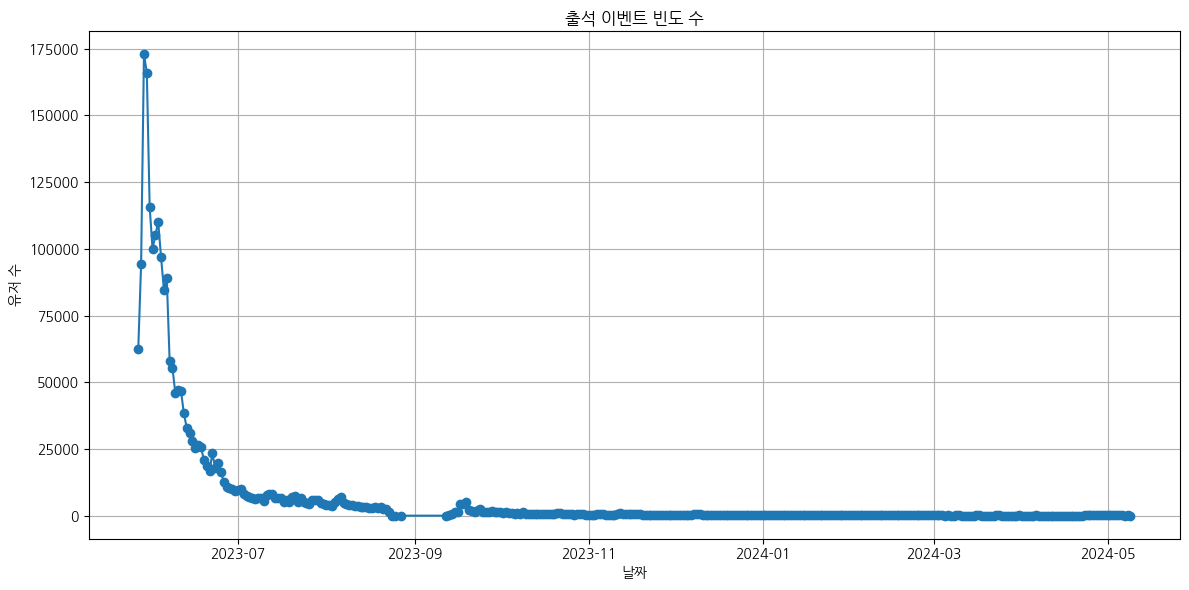

In [14]:
# attendance_date_list를 기준으로 데이터를 확장하여 각 날짜마다 한 행으로 나열
date_user_mapping = df_attendance.explode('attendance_date_list')

# attendance_date_list를 기준으로 그룹화하고 날짜별 고유 사용자 수 계산
dau_data = date_user_mapping.groupby('attendance_date_list')['user_id'].nunique().reset_index()
dau_data.columns = ['date', 'unique_users']  # 열 이름 변경: 날짜, 고유 사용자 수

# 날짜 데이터를 datetime 형식으로 변환 (시각화 시 정렬 및 처리 용이)
dau_data['date'] = pd.to_datetime(dau_data['date'])

# 날짜를 기준으로 데이터를 정렬
dau_data = dau_data.sort_values('date')

# DAU (Daily Active Users) 그래프 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
plt.plot(dau_data['date'], dau_data['unique_users'], marker='o', linestyle='-')  # 선 그래프 그리기
plt.title('출석 이벤트 빈도 수',)  # 그래프 제목
plt.xlabel('날짜')  # x축 레이블
plt.ylabel('유저 수')  # y축 레이블
plt.grid(True)  # 그리드 추가
plt.xticks(rotation=0)  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력

In [15]:
pd.to_datetime(date_user_mapping["attendance_date_list"]).min()

Timestamp('2023-05-27 00:00:00')

출석 이벤트는 '2023-05-27'부터 시작된 것으로 보여진다.

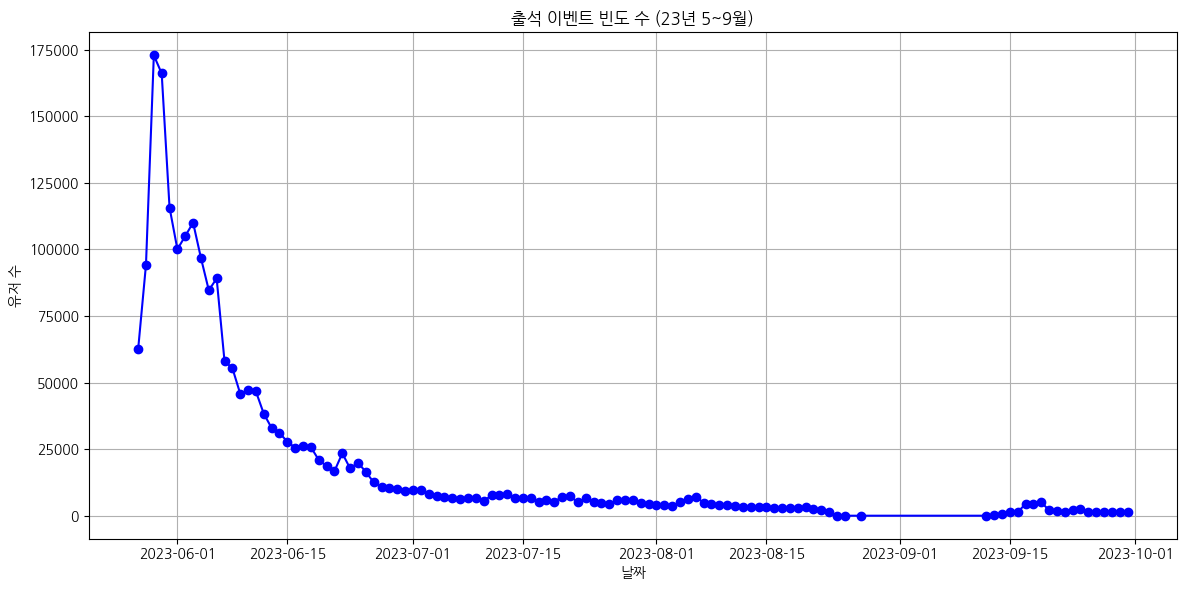

In [16]:
# 2023년 5월~9월 데이터 필터링
date_user_mapping = date_user_mapping[
    (date_user_mapping["attendance_date_list"] >= "2023-05-01") &
    (date_user_mapping["attendance_date_list"] < "2023-10-01")
]

# 날짜별 고유 사용자 수 계산
dau_data = date_user_mapping.groupby("attendance_date_list")["user_id"].nunique().reset_index()
dau_data.columns = ["date", "unique_users"]  # 열 이름 변경

# 날짜 데이터를 datetime 형식으로 변환
dau_data["date"] = pd.to_datetime(dau_data["date"])

# 날짜를 기준으로 정렬
dau_data = dau_data.sort_values("date")

# DAU (Daily Active Users) 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(dau_data["date"], dau_data["unique_users"], marker="o", linestyle="-", color="b")  
plt.title("출석 이벤트 빈도 수 (23년 5~9월)")
plt.xlabel("날짜")
plt.ylabel("유저 수")
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


출석 이벤트 기록을 봤을 때 처음 3일동안 급격하게 증가했다가 다시 감소하는 추세이다.

### 차단 기록

In [17]:
df_block.head()

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177


In [18]:
df_block.describe(include='all')

,id,reason,created_at,block_user_id,user_id
count,19482.000000,19482,19482,1.948200e+04,1.948200e+04
unique,NaN,7,NaN,NaN,NaN
top,NaN,모르는 사람임,NaN,NaN,NaN
freq,NaN,9640,NaN,NaN,NaN
mean,12694.563495,NaN,2023-05-25 19:12:26.516579584,1.183576e+06,1.175780e+06
min,1.000000,NaN,2023-05-04 23:01:53,8.327400e+05,8.376150e+05
25%,6514.250000,NaN,2023-05-14 02:19:01,1.001336e+06,9.890410e+05
50%,12731.000000,NaN,2023-05-22 11:37:20,1.173390e+06,1.160726e+06
75%,18984.750000,NaN,2023-05-28 11:04:33,1.357468e+06,1.345758e+06
max,25361.000000,NaN,2024-05-06 13:03:37,1.582869e+06,1.583612e+06


In [19]:
df_block.isnull().sum()

id               0
reason           0
created_at       0
block_user_id    0
user_id          0
dtype: int64

In [20]:
df_block.duplicated().sum()

np.int64(0)

In [21]:
print(df_block['reason'].value_counts())

reason
모르는 사람임               9640
친구 사이가 어색해짐           5805
사칭 계정                 2022
나랑 관련 없는 질문을 자꾸 보냄    1083
너무 많은 양의 질문을 보냄        919
기타                       7
그냥...                    6
Name: count, dtype: int64


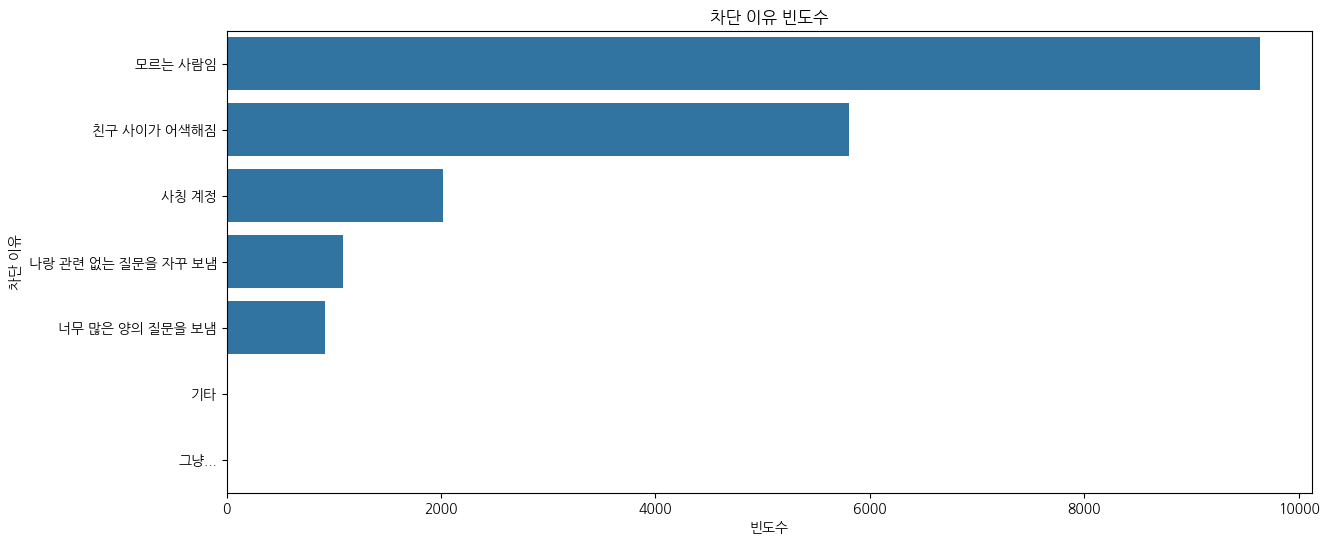

In [22]:
# 시각화
plt.figure(figsize=(14, 6))
sns.countplot(y='reason', data=df_block, order=df_block['reason'].value_counts().index)
plt.title('차단 이유 빈도수')
plt.xlabel('빈도수')
plt.ylabel('차단 이유')
plt.show()

차단 이유가 '모르는 사람임'과 '친구 사이가 어색허짐'이 많아 관계적인 부분에서 차단을 많이 하는 것으로 보인다.

### 상품 구매 실패 기록

In [23]:
df_fail_payment.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730


In [24]:
df_fail_payment.describe(include='all')

,id,productId,phone_type,created_at,user_id
count,163.000000,56,163,163,1.630000e+02
unique,NaN,3,2,NaN,NaN
top,NaN,heart.777,I,NaN,NaN
freq,NaN,49,107,NaN,NaN
mean,89.828221,NaN,NaN,2023-05-27 11:32:20.828220672,1.263685e+06
min,6.000000,NaN,NaN,2023-05-14 05:49:22,8.341120e+05
25%,48.500000,NaN,NaN,2023-05-18 11:34:05,1.152704e+06
50%,89.000000,NaN,NaN,2023-05-22 08:54:33,1.273301e+06
75%,131.500000,NaN,NaN,2023-05-29 12:58:21.500000,1.398432e+06
max,174.000000,NaN,NaN,2023-09-17 09:12:53,1.575434e+06


In [25]:
df_fail_payment.isnull().sum()

id              0
productId     107
phone_type      0
created_at      0
user_id         0
dtype: int64

<Axes: >

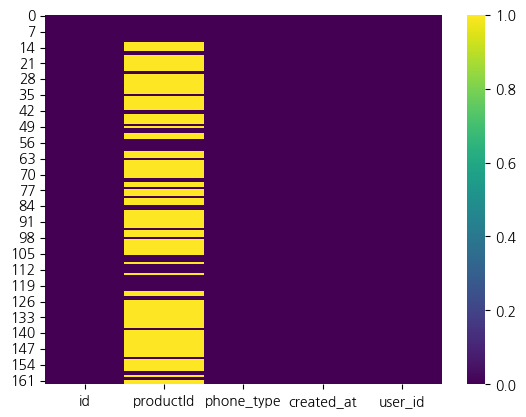

In [26]:
sns.heatmap(df_fail_payment.isnull(), cmap="viridis")

In [27]:
df_fail_payment.duplicated().sum()

np.int64(0)

In [28]:
print(df_fail_payment['productId'].value_counts())

productId
heart.777     49
heart.1000     4
heart.200      3
Name: count, dtype: int64


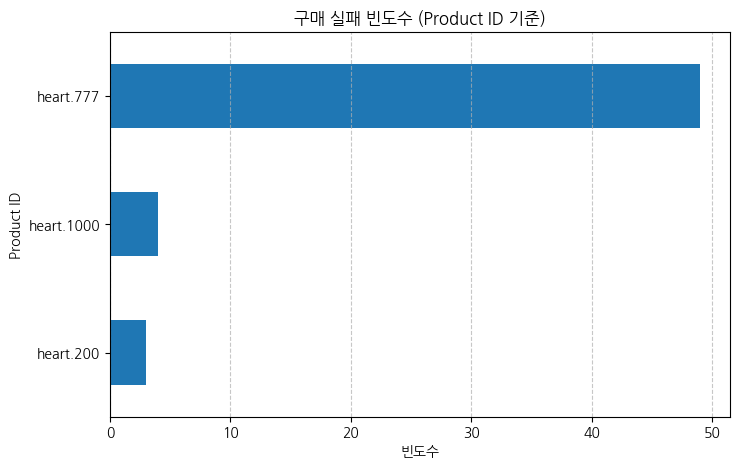

In [29]:
product_fail_counts = df_fail_payment["productId"].value_counts(ascending=True)

# 가로 막대 그래프 시각화
plt.figure(figsize=(8, 5))
product_fail_counts.plot(kind="barh")

# 그래프 제목 및 레이블 설정
plt.title("구매 실패 빈도수 (Product ID 기준)")
plt.xlabel("빈도수")
plt.ylabel("Product ID")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

구매 실패는 전체적으로 적은 수로 나타지만 그 중에서 heart.777 상품이 구매 실패가 많다. 이는 구매 테이블에서 heart.777의 구매가 많기 때문으로 보여진다.

### 친구 요청

In [30]:
df_friend_request.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


In [31]:
df_friend_request.describe(include='all')

,id,status,created_at,updated_at,receive_user_id,send_user_id
count,1.714718e+07,17147175,17147175,17147175,1.714718e+07,1.714718e+07
unique,NaN,3,NaN,NaN,NaN,NaN
top,NaN,A,NaN,NaN,NaN,NaN
freq,NaN,12878407,NaN,NaN,NaN,NaN
mean,9.855565e+06,NaN,2023-05-17 19:14:14.416623360,2023-05-19 03:18:26.881183232,1.154812e+06,1.215895e+06
min,7.000000e+00,NaN,2023-04-17 18:29:11,2023-04-17 18:29:11,8.319620e+05,8.319620e+05
25%,4.940746e+06,NaN,2023-05-10 10:53:21,2023-05-11 03:51:13,9.737080e+05,1.029359e+06
50%,9.810449e+06,NaN,2023-05-15 10:38:56,2023-05-16 10:24:42,1.138343e+06,1.213751e+06
75%,1.477598e+07,NaN,2023-05-22 14:28:30,2023-05-23 21:37:16,1.317869e+06,1.405678e+06
max,1.969298e+07,NaN,2024-05-09 09:21:47,2024-05-09 09:21:47,1.583731e+06,1.583732e+06


In [32]:
df_friend_request.isnull().sum()

id                 0
status             0
created_at         0
updated_at         0
receive_user_id    0
send_user_id       0
dtype: int64

In [33]:
df_friend_request.duplicated().sum()

np.int64(0)

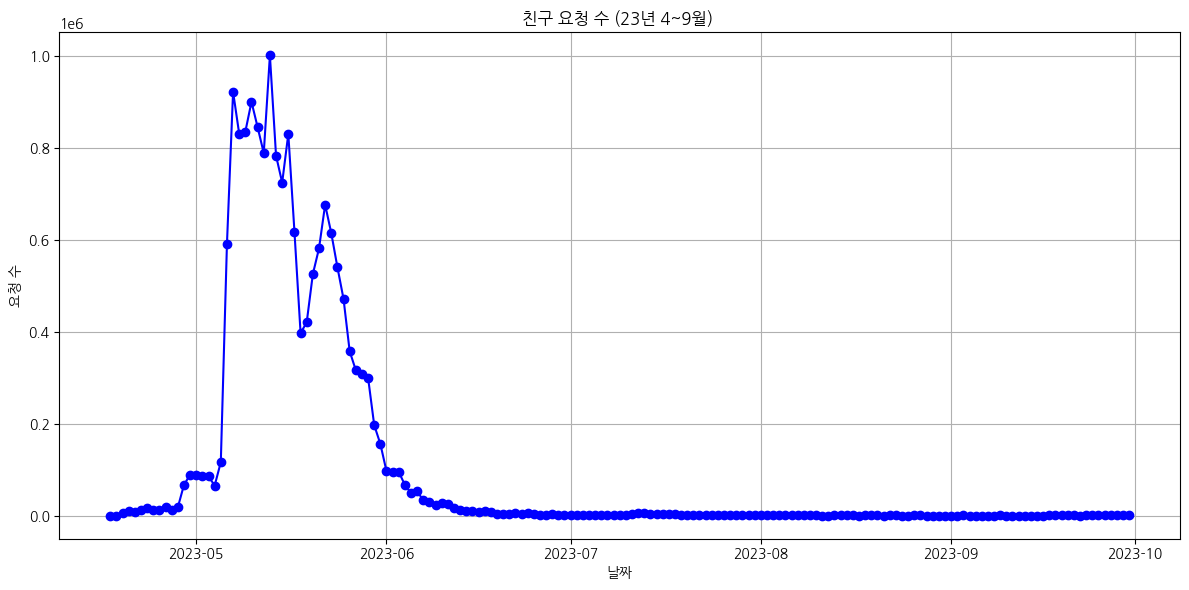

In [34]:
# created_at 컬럼을 datetime 형식으로 변환
df_friend_request["created_at"] = pd.to_datetime(df_friend_request["created_at"])

# 2023년 4월~9월 데이터 필터링
start_date = "2023-04-01"
end_date = "2023-10-01"
filtered_df = df_friend_request[
    (df_friend_request["created_at"] >= start_date) & (df_friend_request["created_at"] < end_date)
]

# 날짜별 요청 수 집계
date_counts = filtered_df.groupby(filtered_df["created_at"].dt.date).size().reset_index(name="request_count")

# 날짜 데이터 변환 및 정렬
date_counts["created_at"] = pd.to_datetime(date_counts["created_at"])
date_counts = date_counts.sort_values("created_at")

# 날짜별 요청 수 그래프 시각화 (DAU 스타일)
plt.figure(figsize=(12, 6))
plt.plot(date_counts["created_at"], date_counts["request_count"], marker="o", linestyle="-", color="b")  
plt.title("친구 요청 수 (23년 4~9월) ")
plt.xlabel("날짜")
plt.ylabel("요청 수")
plt.grid(True)
plt.tight_layout()
plt.show()

### 학급

In [35]:
df_group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [36]:
df_group.describe(include='all')

,id,grade,class_num,school_id
count,84515.000000,84515.000000,84515.000000,84515.000000
mean,42279.376087,2.113992,5.318606,3079.496468
std,24400.962630,0.754896,4.089901,1675.036093
min,1.000000,1.000000,0.000000,1.000000
25%,21147.500000,2.000000,2.000000,1752.000000
50%,42279.000000,2.000000,4.000000,3023.000000
75%,63411.500000,3.000000,7.000000,4620.000000
max,84546.000000,20.000000,41.000000,5965.000000


In [37]:
df_group.isnull().sum()

id           0
grade        0
class_num    0
school_id    0
dtype: int64

In [38]:
df_group.duplicated().sum()

np.int64(0)

### 가까운 학교 기록

In [39]:
df_nearby_school.head()

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


In [40]:
df_nearby_school.describe(include='all')

,id,distance,nearby_school_id,school_id
count,59500.000000,59500.000000,59500.000000,59500.000000
mean,148770.500000,0.055338,2976.695882,2980.524538
std,17176.314845,0.604024,1706.965231,1718.663078
min,119021.000000,0.000000,4.000000,4.000000
25%,133895.750000,0.011484,1518.000000,1493.000000
50%,148770.500000,0.021658,2973.000000,2980.500000
75%,163645.250000,0.064555,4448.000000,4469.000000
max,178520.000000,49.296594,5964.000000,5964.000000


In [41]:
df_nearby_school.isnull().sum()

id                  0
distance            0
nearby_school_id    0
school_id           0
dtype: int64

In [42]:
df_nearby_school.duplicated().sum()

np.int64(0)

### 구매 기록

In [43]:
df_payment.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


In [44]:
df_payment.describe(include='all')

,id,productId,phone_type,created_at,user_id
count,95140.000000,95140,95140,95140,9.514000e+04
unique,NaN,4,2,NaN,NaN
top,NaN,heart.777,I,NaN,NaN
freq,NaN,57873,61632,NaN,NaN
mean,49136.797572,NaN,NaN,2023-05-27 21:47:32.003741952,1.256912e+06
min,6.000000,NaN,NaN,2023-05-13 21:28:34,8.330410e+05
25%,24531.750000,NaN,NaN,2023-05-16 11:48:44.750000128,1.116654e+06
50%,49176.500000,NaN,NaN,2023-05-21 12:40:45.500000,1.270988e+06
75%,73740.250000,NaN,NaN,2023-05-27 13:02:52.249999872,1.417660e+06
max,98078.000000,NaN,NaN,2024-05-08 14:12:45,1.583632e+06


In [45]:
df_payment.isnull().sum()

id            0
productId     0
phone_type    0
created_at    0
user_id       0
dtype: int64

In [46]:
df_payment.duplicated().sum()

np.int64(0)

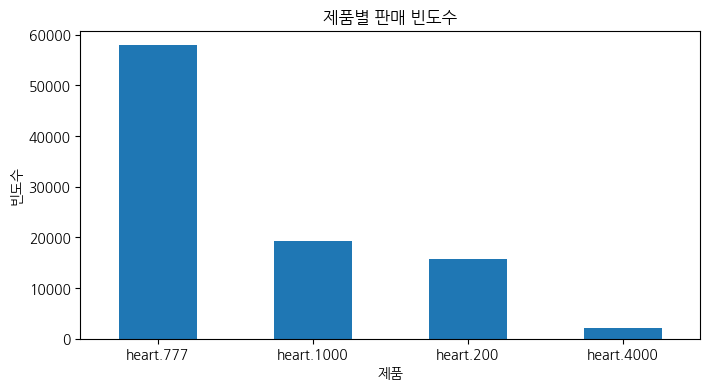

In [47]:
# 제품별 판매 빈도수
df_counts = df_payment['productId'].value_counts()
df_counts.plot(kind='bar', figsize=(8, 4))
plt.xlabel('제품')
plt.ylabel('빈도수')
plt.title('제품별 판매 빈도수')
plt.xticks(rotation=0)
plt.show()

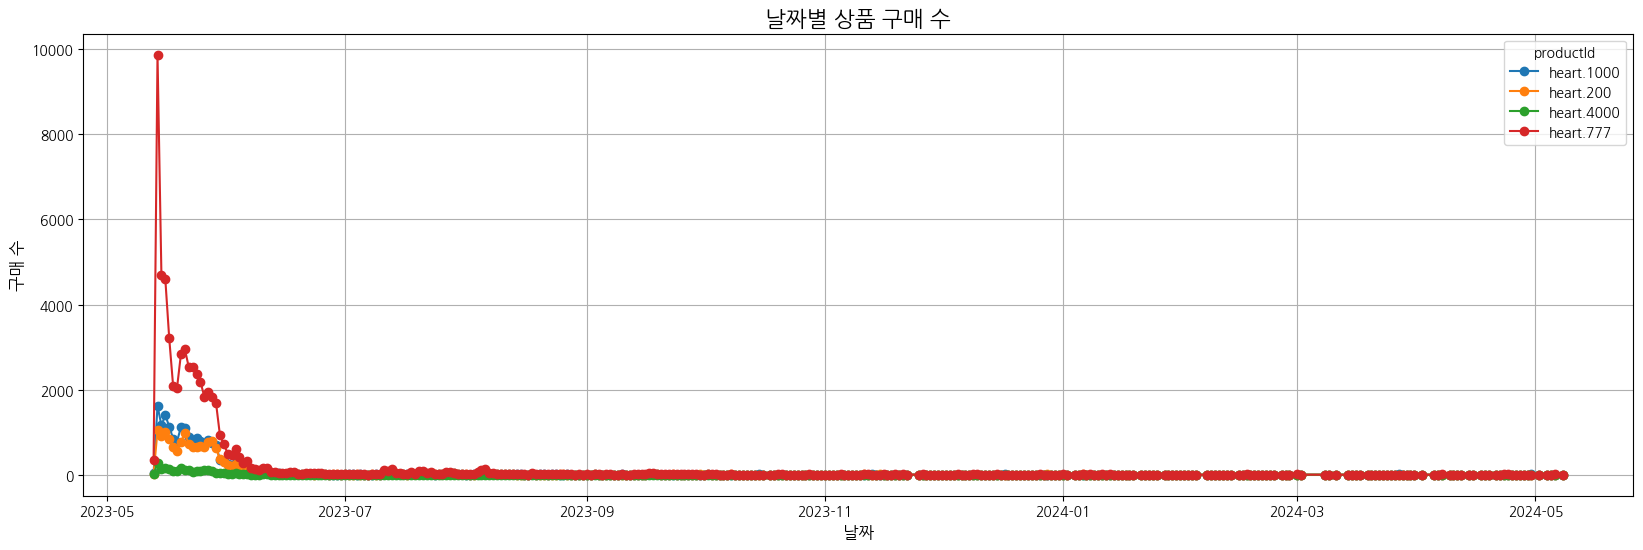

In [48]:
# 'created_at'에서 날짜만 추출하여 새로운 컬럼 'date' 생성
df_payment['date'] = df_payment['created_at'].dt.date

# 날짜별로 productId의 카테고리별로 그룹화하여 카테고리별 구매 수 집계
product_date_counts = df_payment.groupby(['date', 'productId']).size().unstack(fill_value=0)

# 그래프 시각화
fig, ax = plt.subplots(figsize=(20, 6))  # 여기서 figsize를 설정

# 꺾은선 그래프 그리기
product_date_counts.plot(kind='line', marker='o', ax=ax)

# 제목 및 레이블 설정
plt.title('날짜별 상품 구매 수', fontsize=16)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('구매 수', fontsize=12)

# 그리드 추가
plt.grid(True)

# 그래프 출력
plt.show()


| 상품명   | 가격 (USD)  |
|--------|---------|
| heart.200 | 0.49 |
| heart.777 | 0.29 |
| heart.1000 | 1.99 |
| heart.4000 | 7.99 |

리서치로 찾은 가격은 해당 표와 같고 heart.777 상품이 heart.200 상품에 비해 단위 당 가격이 약 6.5배정도 저렴하다. 이 때문에 많이 구매된 것으로 보여진다.

### 유저 컨택

In [49]:
df_user_contacts.head()

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476


In [50]:
df_user_contacts.describe(include='all')

,id,contacts_count,invite_user_id_list,user_id
count,5.063000e+03,5063.000000,5063,5.063000e+03
unique,NaN,NaN,928,NaN
top,NaN,NaN,[],NaN
freq,NaN,NaN,3905,NaN
mean,2.840907e+06,25.986174,NaN,1.114789e+06
std,2.895428e+06,13.601434,NaN,2.187702e+05
min,2.590000e+02,0.000000,NaN,8.473750e+05
25%,7.475970e+05,16.000000,NaN,8.855155e+05
50%,1.580135e+06,24.000000,NaN,1.119987e+06
75%,4.201598e+06,34.000000,NaN,1.278826e+06


In [51]:
df_user_contacts.isnull().sum()

id                     0
contacts_count         0
invite_user_id_list    0
user_id                0
dtype: int64

In [52]:
df_user_contacts.duplicated().sum()

np.int64(0)

### 포인트 기록

In [53]:
df_point_history.head()

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0


In [54]:
df_point_history.describe(include='all')

,id,delta_point,created_at,user_id,user_question_record_id
count,2.338918e+06,2.338918e+06,2338918,2.338918e+06,2.335926e+06
mean,1.265364e+08,8.610862e-01,2023-05-18 03:06:43.825683968,1.111554e+06,6.141803e+07
min,7.906290e+05,-1.000000e+03,2023-04-28 12:27:49,8.380230e+05,7.717770e+05
25%,4.112505e+07,7.000000e+00,2023-05-11 04:37:02,8.861890e+05,2.088561e+07
50%,1.123971e+08,1.000000e+01,2023-05-16 07:29:11,1.126012e+06,5.540614e+07
75%,1.982051e+08,1.300000e+01,2023-05-22 13:47:48.750000128,1.260221e+06,9.555855e+07
max,3.406724e+08,1.000000e+03,2024-05-08 01:36:18,1.583358e+06,1.616665e+08
std,9.610992e+07,5.885849e+01,NaN,2.024429e+05,4.531970e+07


In [55]:
df_point_history.isnull().sum()

id                            0
delta_point                   0
created_at                    0
user_id                       0
user_question_record_id    2992
dtype: int64

<Axes: >

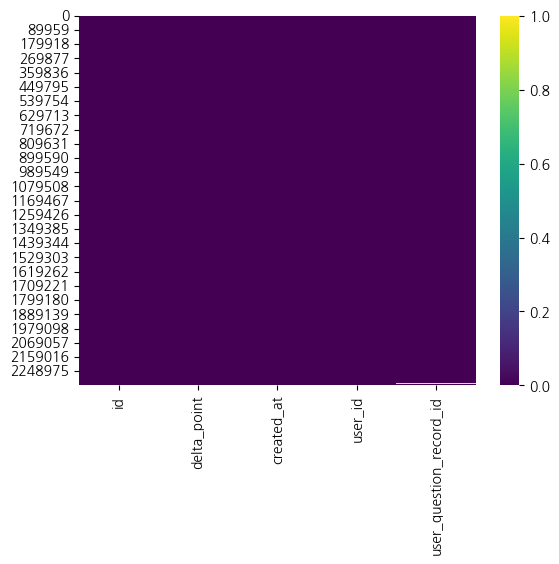

In [56]:
sns.heatmap(df_point_history.isnull(), cmap="viridis")

In [57]:
df_point_history.duplicated().sum()

np.int64(0)

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\3421387326.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_point_history, y="delta_point", palette="Blues_d")


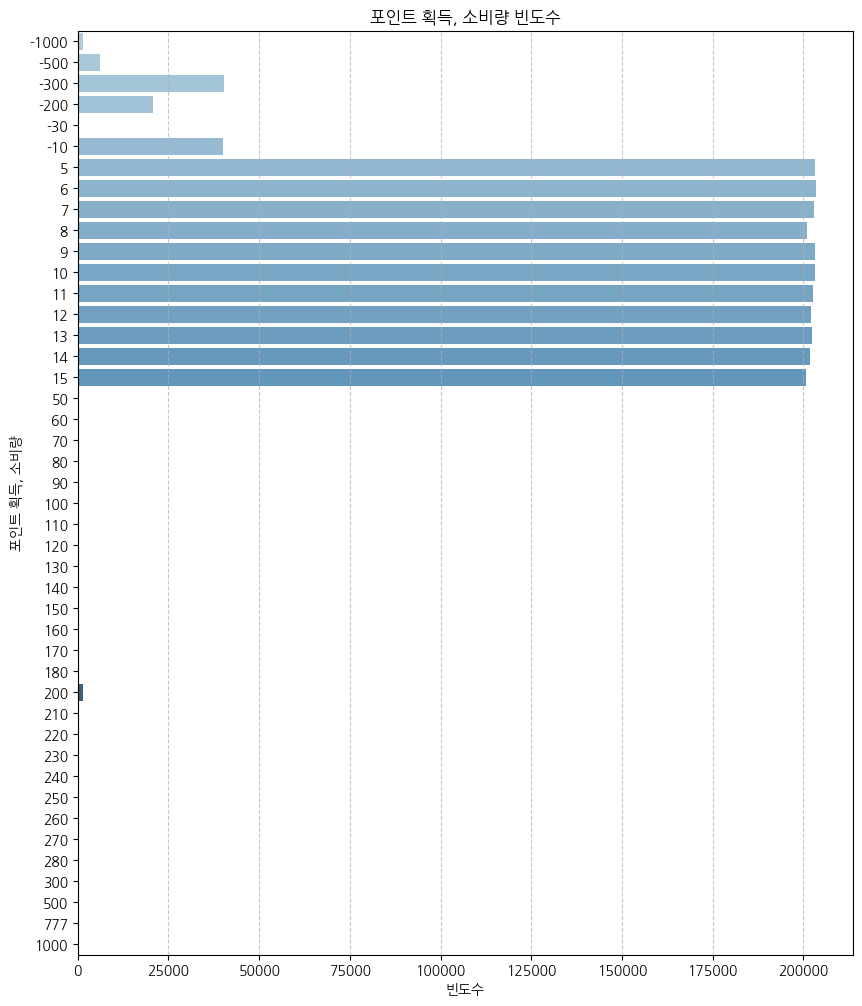

In [58]:
# delta_point 빈도수 시각화
plt.figure(figsize=(10, 12))
sns.countplot(data=df_point_history, y="delta_point", palette="Blues_d")
plt.xlabel("빈도수")
plt.ylabel("포인트 획득, 소비량")
plt.title("포인트 획득, 소비량 빈도수")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

5부터 15까지의 포인트 획득이 많은 것으로 보아 투표 등과 같은 활동 통해서 일정 포인트를 얻는 경우가 많은 것으로 보인다. 

### 학교

In [59]:
df_school.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


In [60]:
df_school.describe(include='all')

,id,address,student_count,school_type
count,5951.000000,5951,5951.000000,5951
unique,NaN,278,NaN,2
top,NaN,경기도 화성시,NaN,M
freq,NaN,78,NaN,3290
mean,2981.026046,NaN,113.772979,NaN
std,1719.084020,NaN,102.863428,NaN
min,4.000000,NaN,0.000000,NaN
25%,1493.500000,NaN,16.000000,NaN
50%,2981.000000,NaN,97.000000,NaN
75%,4469.500000,NaN,183.000000,NaN


In [61]:
df_school.isnull().sum()

id               0
address          0
student_count    0
school_type      0
dtype: int64

In [62]:
df_school.duplicated().sum()

np.int64(0)

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\930198270.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=address_counts_20.values, y=address_counts_20.index, palette="Blues_r")


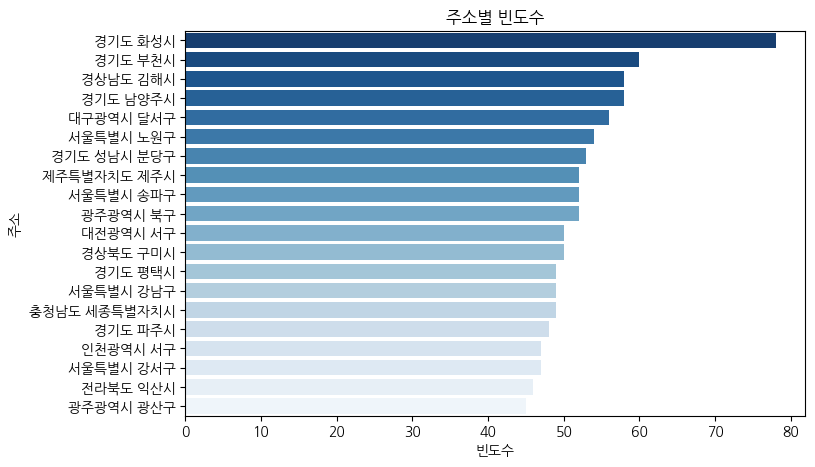

In [63]:
# 주소별 빈도수 계산
address_counts_20 = df_school["address"].value_counts().head(20)

# 그래프 그리기
plt.figure(figsize=(8, 5))
sns.barplot(x=address_counts_20.values, y=address_counts_20.index, palette="Blues_r")

# 제목 및 레이블 설정
plt.xlabel("빈도수")
plt.ylabel("주소")
plt.title("주소별 빈도수")
plt.show()

주로 경기도에서 유저가 많은 것으로 보여진다.

### 유저 신고기록

In [64]:
df_report.head()

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049


In [65]:
df_report.describe(include='all')

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
count,208.000000,208,208,2.080000e+02,2.080000e+02,2.080000e+02
unique,NaN,5,NaN,NaN,NaN,NaN
top,NaN,허위 사실 언급,NaN,NaN,NaN,NaN
freq,NaN,80,NaN,NaN,NaN,NaN
mean,9786.269231,NaN,2023-05-15 08:13:50.278846208,1.132497e+06,1.159946e+06,4.932558e+07
min,28.000000,NaN,2023-05-06 04:44:57,8.372350e+05,8.340890e+05,3.920588e+06
25%,6123.750000,NaN,2023-05-11 16:41:43.500000,9.664702e+05,9.671202e+05,2.461178e+07
50%,10095.000000,NaN,2023-05-15 01:23:29,1.144432e+06,1.184397e+06,4.740327e+07
75%,14182.250000,NaN,2023-05-18 18:01:18,1.225963e+06,1.291813e+06,7.179578e+07
max,23108.000000,NaN,2023-06-02 08:30:06,1.562736e+06,1.548002e+06,1.407659e+08


In [66]:
df_report.isnull().sum()

id                         0
reason                     0
created_at                 0
reported_user_id           0
user_id                    0
user_question_record_id    0
dtype: int64

In [67]:
df_report.duplicated().sum()

np.int64(0)

In [68]:
print(df_report['reason'].value_counts())

reason
허위 사실 언급             80
친구를 비하하거나 조롱하는 어투    64
선정적이거나 폭력적인 내용       39
타인을 사칭함              15
광고                   10
Name: count, dtype: int64


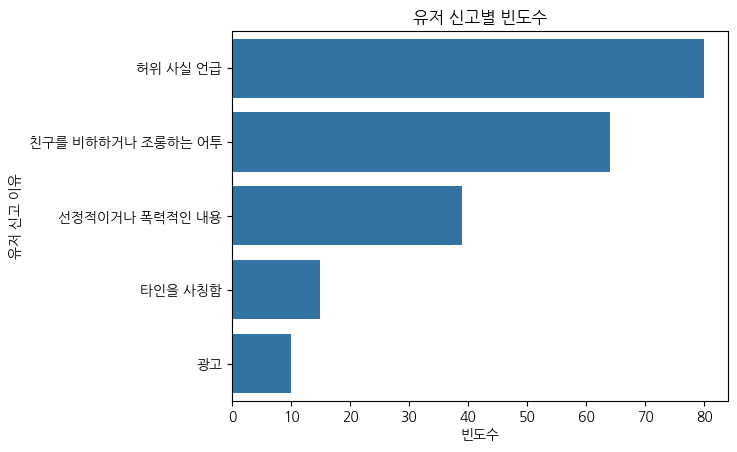

In [69]:
sns.countplot(y='reason', data=df_report, order=df_report['reason'].value_counts().index)
# 제목 및 레이블 설정
plt.xlabel("빈도수")
plt.ylabel("유저 신고 이유")
plt.title("유저 신고별 빈도수")
plt.show()

### 유저

In [70]:
df_user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [71]:
df_user.describe(include='all')

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
count,6.770850e+05,677085.000000,677085.000000,677083,6.770850e+05,677085,677085.000000,677085,677085,677085,677085,677085.000000,677085.000000,677085.000000,677085.000000,677082.000000
unique,NaN,NaN,NaN,2,NaN,674117,NaN,NaN,11685,74995,4,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,F,NaN,[],NaN,NaN,[],[],N,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,396665,NaN,2874,NaN,NaN,664042,598352,668432,NaN,NaN,NaN,NaN,NaN
mean,1.212969e+06,0.000003,0.000004,NaN,3.039145e+03,NaN,0.843098,2023-05-15 22:46:01.709213440,NaN,NaN,NaN,0.037291,0.946646,0.098469,84.630518,37022.980168
min,8.319560e+05,0.000000,0.000000,NaN,0.000000e+00,NaN,0.000000,2023-03-29 03:44:14.047130,NaN,NaN,NaN,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,1.028075e+06,0.000000,0.000000,NaN,4.000000e+02,NaN,1.000000,2023-05-09 01:35:23.126586880,NaN,NaN,NaN,0.000000,0.000000,0.000000,2.000000,18488.000000
50%,1.211729e+06,0.000000,0.000000,NaN,9.650000e+02,NaN,1.000000,2023-05-13 10:50:57.476214016,NaN,NaN,NaN,0.000000,1.000000,0.000000,29.000000,35614.000000
75%,1.397906e+06,0.000000,0.000000,NaN,2.183000e+03,NaN,1.000000,2023-05-20 07:49:47.800349952,NaN,NaN,NaN,0.000000,1.000000,0.000000,122.000000,54534.000000
max,1.583733e+06,1.000000,1.000000,NaN,8.850000e+08,NaN,1.000000,2024-05-09 08:31:17.710824,NaN,NaN,NaN,253.000000,40878.000000,5712.000000,3352.000000,84546.000000


In [72]:
df_user.isnull().sum()

id                    0
is_superuser          0
is_staff              0
gender                2
point                 0
friend_id_list        0
is_push_on            0
created_at            0
block_user_id_list    0
hide_user_id_list     0
ban_status            0
report_count          0
alarm_count           0
pending_chat          0
pending_votes         0
group_id              3
dtype: int64

<Axes: >

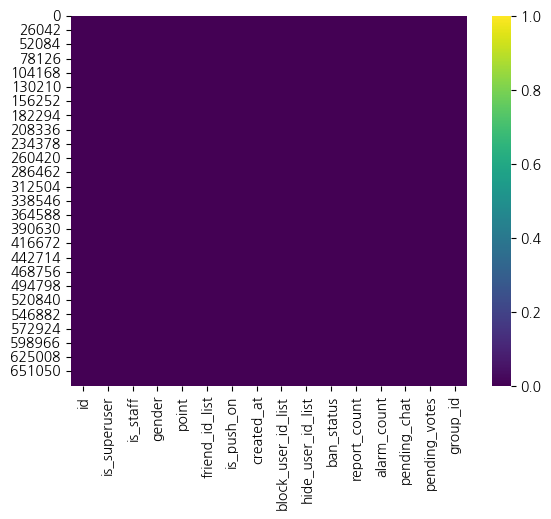

In [73]:
sns.heatmap(df_user.isnull(), cmap="viridis")

In [74]:
df_user.duplicated().sum()

np.int64(0)

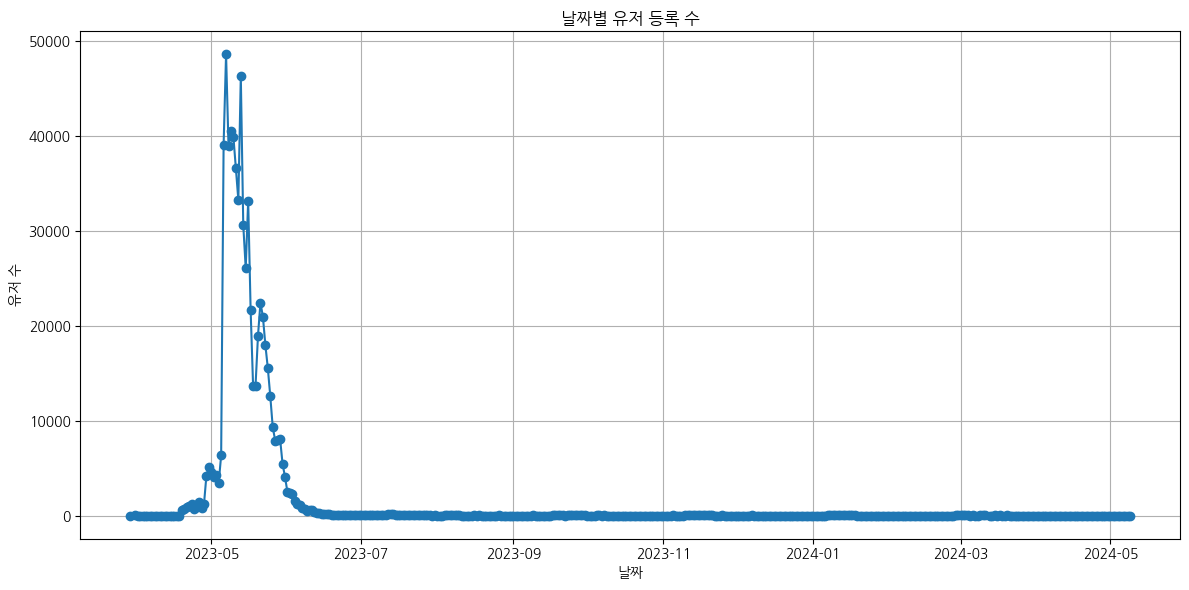

In [75]:
# created_at 컬럼을 datetime 타입으로 변환
df_user['created_at'] = pd.to_datetime(df_user['created_at'])

# created_at에서 날짜 부분만 추출
df_user['date'] = df_user['created_at'].dt.date

# 날짜별로 고유 user_id의 개수 집계
unique_user_count = df_user.groupby('date')['id'].nunique()

# 집계 결과를 데이터프레임으로 재구성
result_df = unique_user_count.reset_index()
result_df.columns = ['date', 'unique_user_count']

# 날짜 컬럼을 datetime 형식으로 변환 (시각화를 위해)
result_df['date'] = pd.to_datetime(result_df['date'])

# 시각화: 날짜별 고유 user_id 개수 라인 차트
plt.figure(figsize=(12, 6))
plt.plot(result_df['date'], result_df['unique_user_count'], marker='o', linestyle='-')
plt.title('날짜별 유저 등록 수')
plt.xlabel('날짜')
plt.ylabel('유저 수')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1478938940.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['created_at'].dt.date


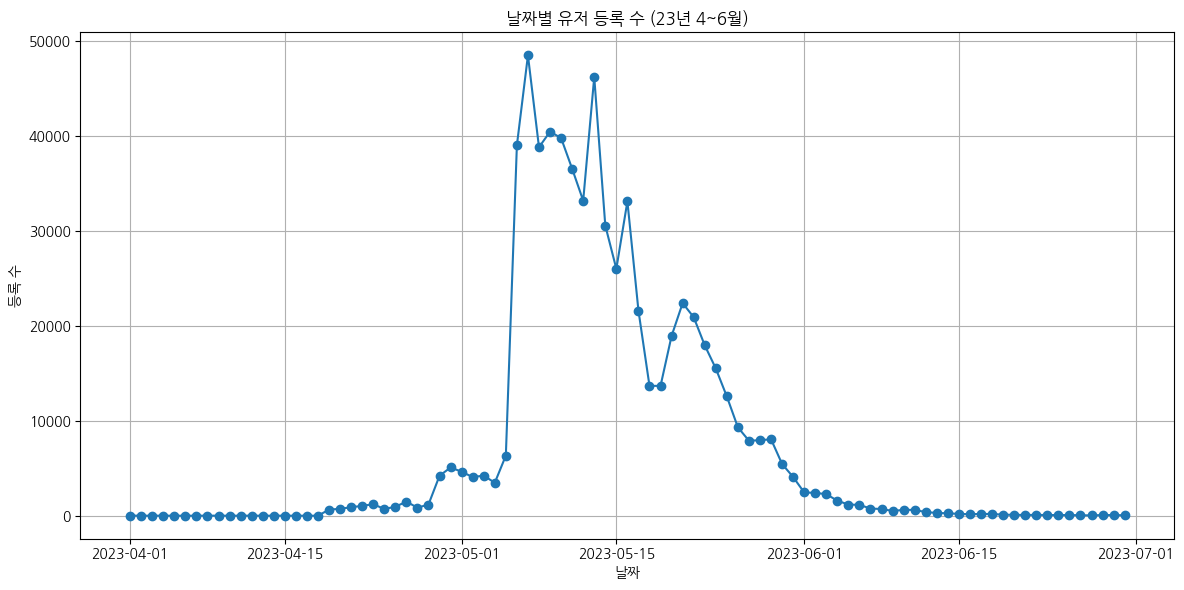

In [76]:
# 4, 5, 6월 유저 유입 수
# created_at 컬럼을 datetime 타입으로 변환
df_user['created_at'] = pd.to_datetime(df_user['created_at'])

# 2023년도 4, 5, 6월에 해당하는 데이터만 필터링
df_filtered = df_user[(df_user['created_at'].dt.year == 2023) & (df_user['created_at'].dt.month.isin([4, 5, 6]))]

# created_at에서 날짜 부분만 추출
df_filtered['date'] = df_filtered['created_at'].dt.date

# 날짜별로 고유 user_id의 개수 집계
unique_user_count = df_filtered.groupby('date')['id'].nunique()

# 집계 결과를 데이터프레임으로 재구성
result_df = unique_user_count.reset_index()
result_df.columns = ['date', 'unique_user_count']

# 날짜 컬럼을 datetime 형식으로 변환 (시각화를 위해)
result_df['date'] = pd.to_datetime(result_df['date'])

# 시각화: 날짜별 고유 user_id 개수 라인 차트
plt.figure(figsize=(12, 6))
plt.plot(result_df['date'], result_df['unique_user_count'], marker='o', linestyle='-')
plt.title('날짜별 유저 등록 수 (23년 4~6월)')
plt.xlabel('날짜')
plt.ylabel('등록 수')
plt.grid(True)
plt.tight_layout()
plt.show()

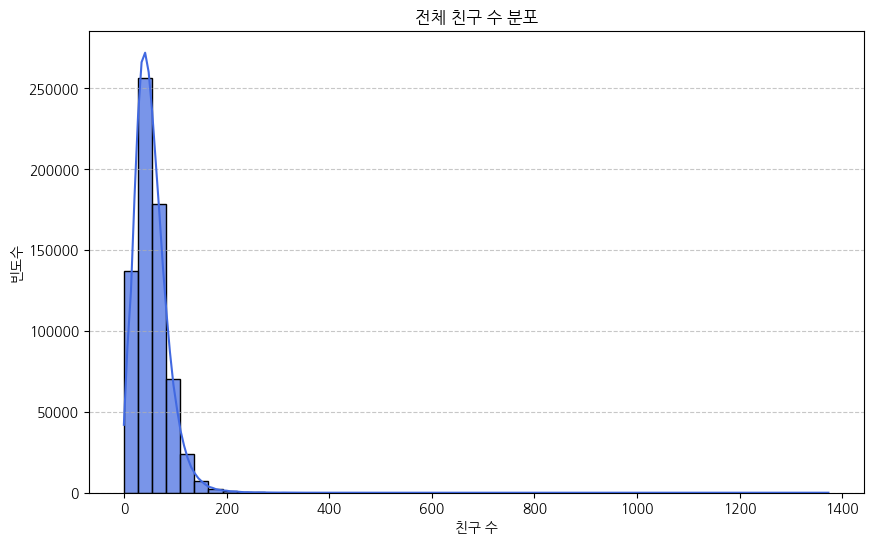

In [77]:
# 문자열 리스트를 실제 리스트로 변환 후 친구 수 계산
df_user["friend_id_list"] = df_user["friend_id_list"].apply(ast.literal_eval)
df_user["friend_count"] = df_user["friend_id_list"].apply(len)

# 친구 수 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(df_user["friend_count"], bins=50, kde=True, color="royalblue", alpha=0.7)
plt.xlabel("친구 수")
plt.ylabel("빈도수")
plt.title("전체 친구 수 분포")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\2679667468.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_user, x="gender", palette={"M": "blue", "F": "pink"})


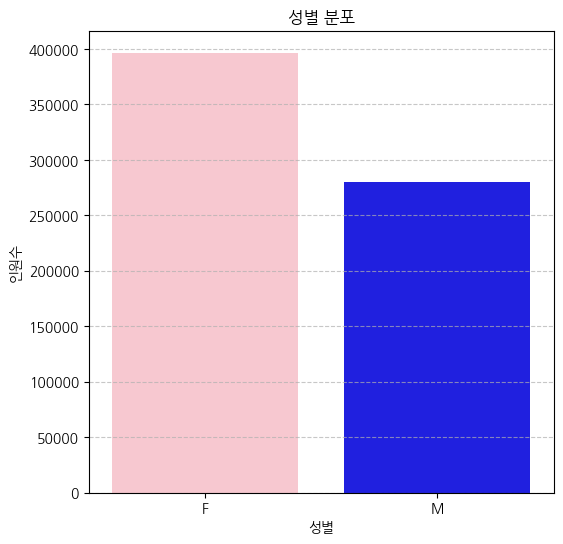

In [78]:
# 성별 비율 시각화
plt.figure(figsize=(6, 6))
sns.countplot(data=df_user, x="gender", palette={"M": "blue", "F": "pink"})
plt.xlabel("성별")
plt.ylabel("인원수")
plt.title("성별 분포")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### 투표 기록

In [79]:
df_vote.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [80]:
df_vote.describe(include='all')

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
count,1.217558e+06,1217558,1217558,1.217558e+06,1.217558e+06,1.217558e+06,1.217558e+06,1.217558e+06,1217558,1217558,1.217558e+06,1.217558e+06
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN
top,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
freq,NaN,1156322,NaN,NaN,NaN,NaN,NaN,NaN,1097932,NaN,NaN,NaN
mean,5.957298e+07,NaN,2023-05-17 12:51:25.947102208,1.092604e+06,6.843895e+02,1.105790e+06,7.413211e+07,5.551530e-01,NaN,2023-05-17 13:44:38.920359680,1.765830e-04,6.332511e-02
min,7.717770e+05,NaN,2023-04-28 12:27:49,8.331120e+05,9.900000e+01,8.380230e+05,9.984580e+05,0.000000e+00,NaN,2023-04-28 12:27:49,0.000000e+00,0.000000e+00
25%,1.553965e+07,NaN,2023-05-10 01:42:11,8.836920e+05,2.750000e+02,8.846190e+05,1.854142e+07,0.000000e+00,NaN,2023-05-10 02:38:44.750000128,0.000000e+00,0.000000e+00
50%,5.302680e+07,NaN,2023-05-15 15:43:01.500000,1.091749e+06,4.690000e+02,1.117537e+06,6.616843e+07,1.000000e+00,NaN,2023-05-15 16:29:08.500000,0.000000e+00,0.000000e+00
75%,9.480960e+07,NaN,2023-05-22 11:01:03.750000128,1.235698e+06,9.420000e+02,1.259186e+06,1.176735e+08,1.000000e+00,NaN,2023-05-22 11:41:54.750000128,0.000000e+00,0.000000e+00
max,1.616665e+08,NaN,2024-05-08 01:36:18,1.579422e+06,5.133000e+03,1.583358e+06,2.083515e+08,1.000000e+00,NaN,2024-05-08 01:36:18,1.400000e+01,3.000000e+00


In [81]:
df_vote.isnull().sum()

id                   0
status               0
created_at           0
chosen_user_id       0
question_id          0
user_id              0
question_piece_id    0
has_read             0
answer_status        0
answer_updated_at    0
report_count         0
opened_times         0
dtype: int64

In [82]:
df_vote.duplicated().sum()

np.int64(0)

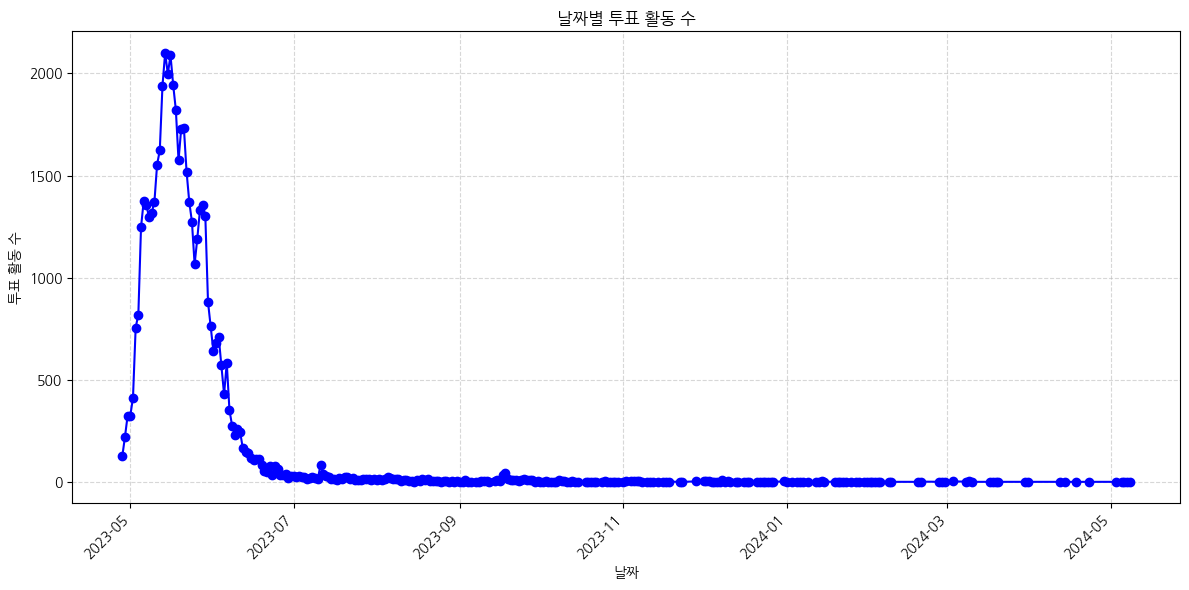

In [83]:
# 'date' 컬럼을 추가할 때 .loc을 사용하여 명시적으로 수정
df_vote.loc[:, 'date'] = df_vote['created_at'].dt.date

# 날짜별로 고유 user_id의 개수 집계
unique_user_count = df_vote.groupby('date')['user_id'].nunique()

# 집계 결과를 데이터프레임으로 재구성
result_df = unique_user_count.reset_index()
result_df.columns = ['date', 'unique_user_count']

# 날짜 컬럼을 datetime 형식으로 변환
result_df['date'] = pd.to_datetime(result_df['date'])

# 시각화: 날짜별 고유 user_id 개수 라인 차트
plt.figure(figsize=(12, 6))

# 선 그래프 그리기
plt.plot(result_df['date'], result_df['unique_user_count'], marker='o', linestyle='-', color="b")

# 제목 및 레이블 설정
plt.title('날짜별 투표 활동 수')
plt.xlabel('날짜')
plt.ylabel('투표 활동 수')

# 그리드 추가 (가독성 높이기 위해 스타일 및 간격 수정)
plt.grid(True, linestyle='--', alpha=0.5)  # 점선, 투명도 조정

# x축 레이블 회전 및 레이블 간격 조정
plt.xticks(rotation=45, ha='right')  # 날짜 레이블 회전 (오른쪽 정렬)

# 레이아웃 최적화
plt.tight_layout()

# 그래프 출력
plt.show()

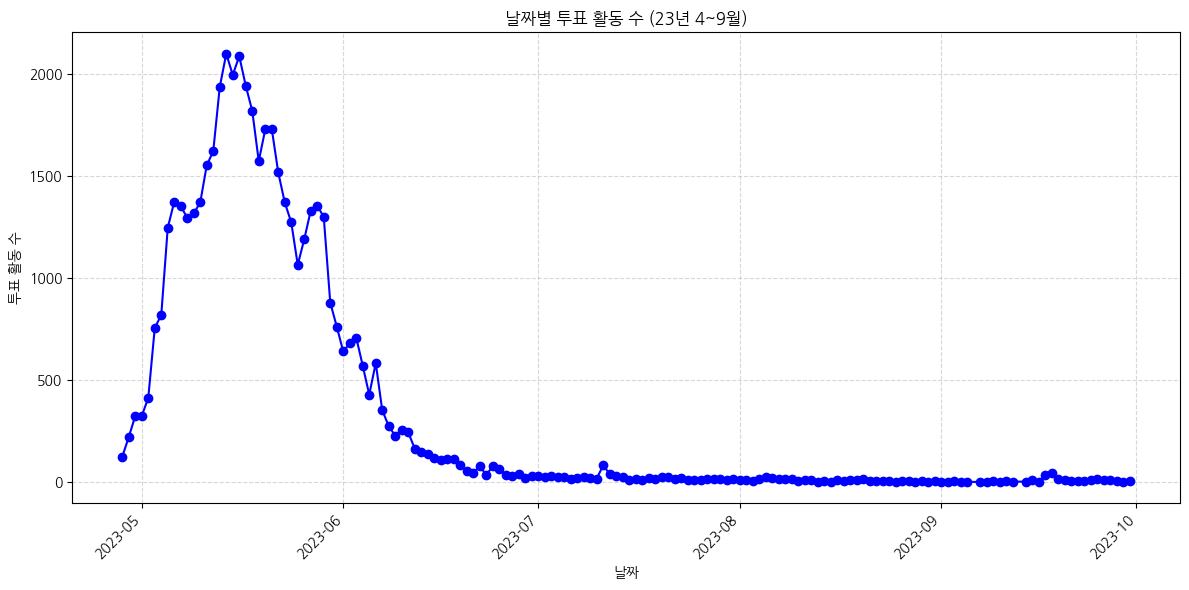

In [84]:
# 2023년 4월~9월 데이터 필터링
start_date = "2023-04-01"
end_date = "2023-10-01"
filtered_df = df_vote[(df_vote['created_at'] >= start_date) & (df_vote['created_at'] <= end_date)]

# 'date' 컬럼을 추가할 때 .loc을 사용하여 명시적으로 수정
filtered_df.loc[:, 'date'] = filtered_df['created_at'].dt.date

# 날짜별로 고유 user_id의 개수 집계
unique_user_count = filtered_df.groupby('date')['user_id'].nunique()

# 집계 결과를 데이터프레임으로 재구성
result_df = unique_user_count.reset_index()
result_df.columns = ['date', 'unique_user_count']

# 날짜 컬럼을 datetime 형식으로 변환
result_df['date'] = pd.to_datetime(result_df['date'])

# 시각화: 날짜별 고유 user_id 개수 라인 차트
plt.figure(figsize=(12, 6))

# 선 그래프 그리기
plt.plot(result_df['date'], result_df['unique_user_count'], marker='o', linestyle='-', color="b")

# 제목 및 레이블 설정
plt.title('날짜별 투표 활동 수 (23년 4~9월)')
plt.xlabel('날짜')
plt.ylabel('투표 활동 수')

# 그리드 추가 (가독성 높이기 위해 스타일 및 간격 수정)
plt.grid(True, linestyle='--', alpha=0.5)  # 점선, 투명도 조정

# x축 레이블 회전 및 레이블 간격 조정
plt.xticks(rotation=45, ha='right')  # 날짜 레이블 회전 (오른쪽 정렬)

# 레이아웃 최적화
plt.tight_layout()

# 그래프 출력
plt.show()


4월 후반부터 5월 중반까지 급증하는 추세를 보이지만 그만큼 다시 급감하며 7월 이후부터는 거의 활동이 없는 것으로 보여진다.

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\876379495.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_vote, x="has_read", palette="viridis")


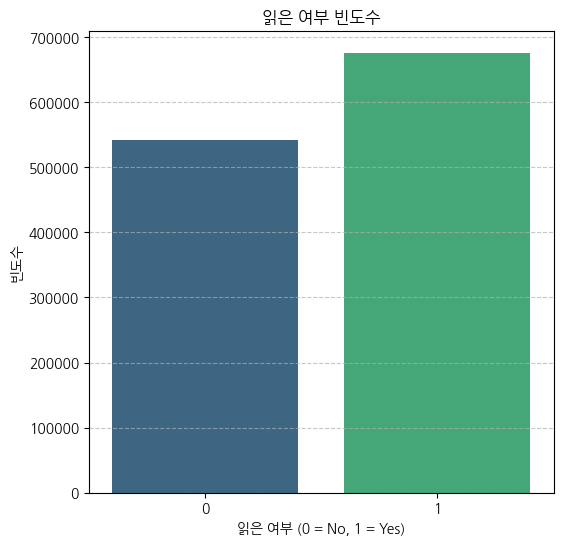

In [85]:
# 읽은 여부 시각화
plt.figure(figsize=(6, 6))
sns.countplot(data=df_vote, x="has_read", palette="viridis")
plt.xlabel("읽은 여부 (0 = No, 1 = Yes)")
plt.ylabel("빈도수")
plt.title("읽은 여부 빈도수")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\4065742156.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_vote, x="answer_status", palette="Blues")


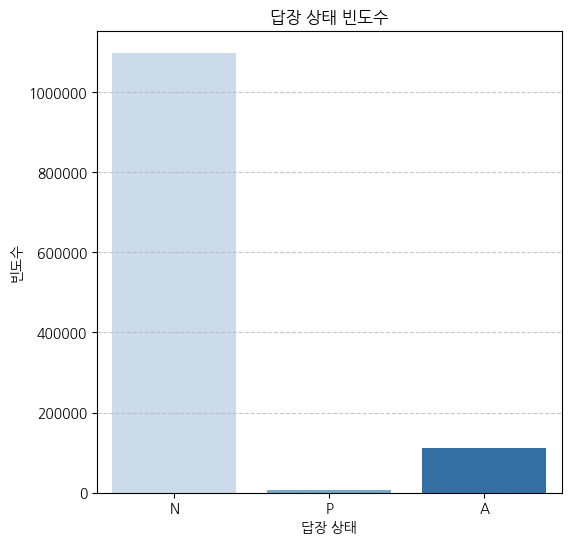

In [86]:
# answer_status 빈도수 시각화
plt.figure(figsize=(6, 6))
sns.countplot(data=df_vote, x="answer_status", palette="Blues")
plt.xlabel("답장 상태")
plt.ylabel("빈도수")
plt.title("답장 상태 빈도수")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

N: Not Answered (미답변) // P: Private (비공개) // A: Available (공개)

미답변이 가장 많고 답변을 하게되면 공개로 답변하는 경우가 더 많다.

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1081917831.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_vote, x="opened_times", palette="coolwarm")


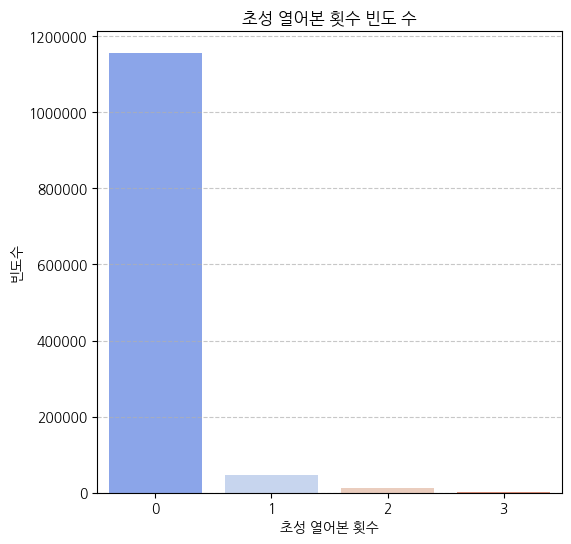

In [87]:
# opened_times 빈도수 시각화
plt.figure(figsize=(6, 6))
sns.countplot(data=df_vote, x="opened_times", palette="coolwarm")
plt.xlabel("초성 열어본 횟수")
plt.ylabel("빈도수")
plt.title("초성 열어본 횟수 빈도 수")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

초성 열어본 횟수가 0인 경우가 가장 많아 대부분 초성을 열어보지 않는 것으로 보여진다.

### 탈퇴 기록

In [88]:
df_withdraw.head()

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19


In [89]:
df_withdraw.describe(include='all')

,id,reason,created_at
count,70764.000000,70764,70764
unique,NaN,8,NaN
top,NaN,기타 이유,NaN
freq,NaN,40301,NaN
mean,35499.063154,NaN,2023-06-12 06:34:26.762464
min,42.000000,NaN,2023-03-29 13:22:12
25%,17803.750000,NaN,2023-05-12 06:28:54.249999872
50%,35498.500000,NaN,2023-05-20 15:50:53.500000
75%,53199.250000,NaN,2023-06-14 12:13:03.500000
max,70893.000000,NaN,2024-05-09 08:49:06


In [90]:
df_withdraw.isnull().sum()

id            0
reason        0
created_at    0
dtype: int64

In [91]:
df_withdraw.duplicated().sum()

np.int64(0)

In [92]:
df_withdraw['reason'].value_counts()

reason
기타 이유           40301
함께 할 친구가 없어서    14450
재밌는 질문이 없어서     13133
버그가 너무 많아서       2031
구독료가 너무 비싸서       730
admin              61
test               53
기타                  5
Name: count, dtype: int64

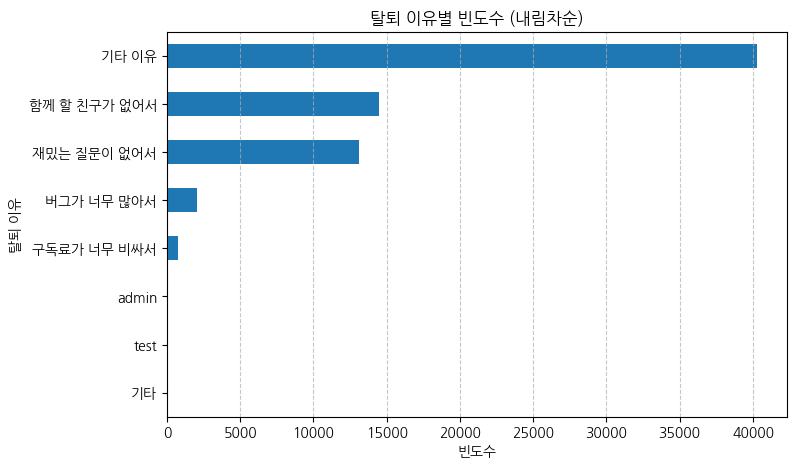

In [93]:
# reason별 개수 계산 (내림차순 정렬)
reason_counts = df_withdraw["reason"].value_counts(ascending=True)  # 막대그래프가 위에서 아래로 큰 값 순서로 정렬됨

# 가로 막대 그래프 시각화
plt.figure(figsize=(8, 5))
reason_counts.plot(kind="barh")

# 그래프 제목 및 레이블 설정
plt.title("탈퇴 이유별 빈도수 (내림차순)")
plt.xlabel("빈도수")
plt.ylabel("탈퇴 이유")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

In [94]:
df_withdraw['created_at'] = pd.to_datetime(df_withdraw['created_at'])

# 월별 탈퇴 기록
df_monthly_withdraw = df_withdraw['created_at'].dt.to_period('M').value_counts().sort_index()
print(df_monthly_withdraw)

created_at
2023-03       17
2023-04     2397
2023-05    44845
2023-06     9642
2023-07     4811
2023-08     2310
2023-09     2450
2023-10     1164
2023-11      837
2023-12      693
2024-01      697
2024-02      319
2024-03      250
2024-04      240
2024-05       92
Freq: M, Name: count, dtype: int64


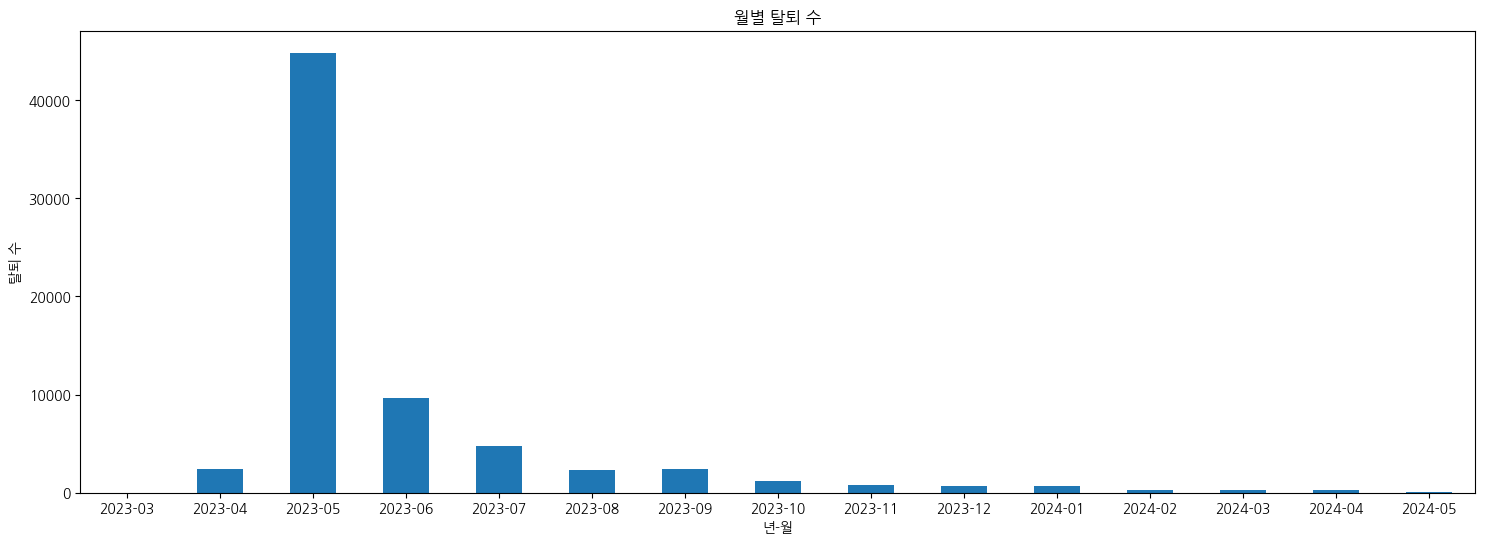

In [95]:
# 시각화
plt.figure(figsize=(18, 6))
df_withdraw['created_at'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)  # 수평으로 설정
plt.title('월별 탈퇴 수')
plt.xlabel('년-월')
plt.ylabel('탈퇴 수')
plt.show()

유저가 가장 많이 가입했던 5월달에 탈퇴가 많이 이루어진 것으로 보인다.

### 포인트 이벤트 참여

In [96]:
df_event_receipts.head()

,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500


In [97]:
df_event_receipts.describe(include='all')

,id,created_at,event_id,user_id,plus_point
count,309.000000,309,309.000000,3.090000e+02,309.000000
mean,160.964401,2023-07-24 01:53:59.954692608,1.249191,1.179715e+06,559.870550
min,2.000000,2023-06-22 09:25:16,1.000000,8.378360e+05,500.000000
25%,82.000000,2023-07-10 16:58:20,1.000000,9.998160e+05,500.000000
50%,161.000000,2023-07-20 12:24:28,1.000000,1.139491e+06,500.000000
75%,239.000000,2023-07-29 09:38:22,1.000000,1.325911e+06,500.000000
max,321.000000,2023-11-21 12:03:02,3.000000,1.579064e+06,1000.000000
std,92.065029,NaN,0.563536,2.171981e+05,162.592579


In [98]:
df_event_receipts.isnull().sum()

id            0
created_at    0
event_id      0
user_id       0
plus_point    0
dtype: int64

In [99]:
df_event_receipts.duplicated().sum()

np.int64(0)

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1492332614.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette="Blues_r")


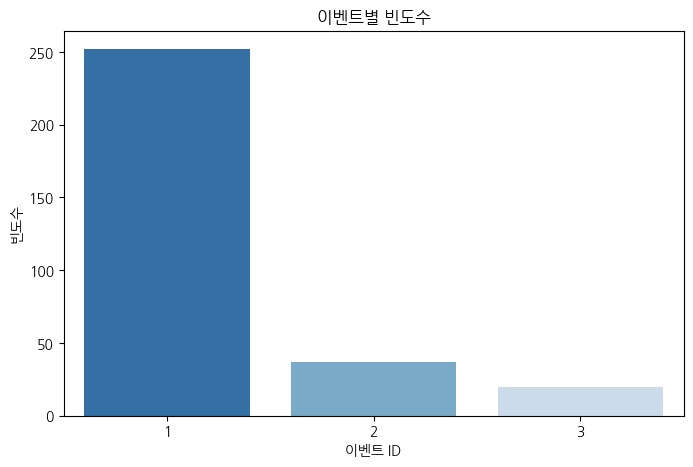

In [100]:
# 이벤트 ID별 발생 횟수 계산
event_counts = df_event_receipts['event_id'].value_counts()

# 그래프 그리기
plt.figure(figsize=(8, 5))
sns.barplot(x=event_counts.index, y=event_counts.values, palette="Blues_r")
plt.xlabel("이벤트 ID")
plt.ylabel("빈도수")
plt.title("이벤트별 빈도수")
plt.show()

| 이벤트 ID  | 이름 | 포인트 보상 |
|--------|---------|---------|
| 1 | 코드잇 은행 가입 이벤트 | 500 |
| 2 | 코드잇 멤버십 가입 이벤트	 | 1000 |
| 3 | 예고 영상 기대평 이벤트 | 500 |

### 포인트 이벤트

In [101]:
df_events.head()

,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45
2,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59


In [102]:
df_events.describe(include='all')

,id,title,plus_point,event_type,is_expired,created_at
count,3.0,3,3.000000,3,3.0,3
unique,NaN,3,NaN,1,NaN,NaN
top,NaN,코드잇 은행 가입 이벤트,NaN,FCFS,NaN,NaN
freq,NaN,1,NaN,3,NaN,NaN
mean,2.0,NaN,666.666667,NaN,1.0,2023-08-07 20:15:27.333333248
min,1.0,NaN,500.000000,NaN,1.0,2023-06-20 11:56:38
25%,1.5,NaN,500.000000,NaN,1.0,2023-07-14 21:50:11.500000
50%,2.0,NaN,500.000000,NaN,1.0,2023-08-08 07:43:45
75%,2.5,NaN,750.000000,NaN,1.0,2023-09-01 00:24:52
max,3.0,NaN,1000.000000,NaN,1.0,2023-09-24 17:05:59


In [103]:
df_events.isnull().sum()

id            0
title         0
plus_point    0
event_type    0
is_expired    0
created_at    0
dtype: int64

In [104]:
df_events.duplicated().sum()

np.int64(0)

### 질문

In [105]:
df_question.head()

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


In [106]:
df_question.describe(include='all')

,id,question_text,created_at
count,5025.000000,5025,5025
unique,NaN,3903,NaN
top,NaN,vote,NaN
freq,NaN,56,NaN
mean,2619.897512,NaN,2023-05-26 17:49:11.666268672
min,99.000000,NaN,2023-03-31 15:22:53
25%,1365.000000,NaN,2023-05-15 14:03:03
50%,2621.000000,NaN,2023-06-02 08:06:53
75%,3877.000000,NaN,2023-06-06 06:10:14
max,5133.000000,NaN,2023-06-06 06:15:52


In [107]:
df_question.isnull().sum()

id               0
question_text    0
created_at       0
dtype: int64

In [108]:
df_question.duplicated().sum()

np.int64(0)

In [109]:
# 중복된 질문 존재
df_question[df_question.duplicated(subset=['question_text'])]

,id,question_text,created_at
384,483,vote,2023-05-02 05:33:11
540,639,vote,2023-05-11 15:52:44
587,696,vote,2023-05-15 13:58:24
603,712,vote,2023-05-15 13:58:30
616,725,vote,2023-05-15 13:58:35
...,...,...,...
5020,5129,나에게 가장 중요한 사람은?,2023-06-06 06:15:52
5021,5130,오목을 제일 잘 할 것 같은 사람은?,2023-06-06 06:15:52
5022,5131,가방에서 쓰레기가 안 나올 것 같은 사람은?,2023-06-06 06:15:52
5023,5132,아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는?,2023-06-06 06:15:52


### 질문 조각

In [110]:
df_question_piece.head()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


In [111]:
df_question_piece.describe(include='all')

,id,is_voted,created_at,question_id,is_skipped
count,1.265476e+06,1.265476e+06,1265476,1.265476e+06,1.265476e+06
mean,7.658001e+07,9.630266e-01,2023-05-17 13:39:58.427317504,7.133598e+02,8.905740e-04
min,9.984580e+05,0.000000e+00,2023-04-28 12:27:22,9.900000e+01,0.000000e+00
25%,2.029260e+07,1.000000e+00,2023-05-09 21:50:54,2.780000e+02,0.000000e+00
50%,6.846533e+07,1.000000e+00,2023-05-15 14:18:31.500000,4.770000e+02,0.000000e+00
75%,1.212662e+08,1.000000e+00,2023-05-22 09:56:44,9.820000e+02,0.000000e+00
max,2.083852e+08,1.000000e+00,2024-05-07 11:32:30,5.133000e+03,1.000000e+00
std,5.912924e+07,1.886967e-01,NaN,6.706815e+02,2.982921e-02


In [112]:
df_question_piece.isnull().sum()

id             0
is_voted       0
created_at     0
question_id    0
is_skipped     0
dtype: int64

In [113]:
df_question_piece.duplicated().sum()

np.int64(0)

### 질문에 대한 신고 기록 

In [114]:
df_question_report.head()

,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922


In [115]:
df_question_report.describe(include='all')

,id,reason,created_at,question_id,user_id
count,51424.000000,51424,51424,51424.000000,5.142400e+04
unique,NaN,11,NaN,NaN,NaN
top,NaN,그냥 싫어,NaN,NaN,NaN
freq,NaN,28446,NaN,NaN,NaN
mean,28027.358587,NaN,2023-05-21 22:12:41.641120768,733.099098,1.168247e+06
min,1.000000,NaN,2023-04-19 06:20:35,99.000000,8.323400e+05
25%,14020.750000,NaN,2023-05-13 01:36:21.249999872,305.000000,9.784810e+05
50%,28047.500000,NaN,2023-05-18 14:33:45,494.000000,1.160251e+06
75%,42084.250000,NaN,2023-05-26 08:45:25,1021.000000,1.351295e+06
max,55767.000000,NaN,2024-05-05 14:56:25,5110.000000,1.583634e+06


In [116]:
df_question_report.isnull().sum()

id             0
reason         0
created_at     0
question_id    0
user_id        0
dtype: int64

In [117]:
df_question_report.duplicated().sum()

np.int64(0)

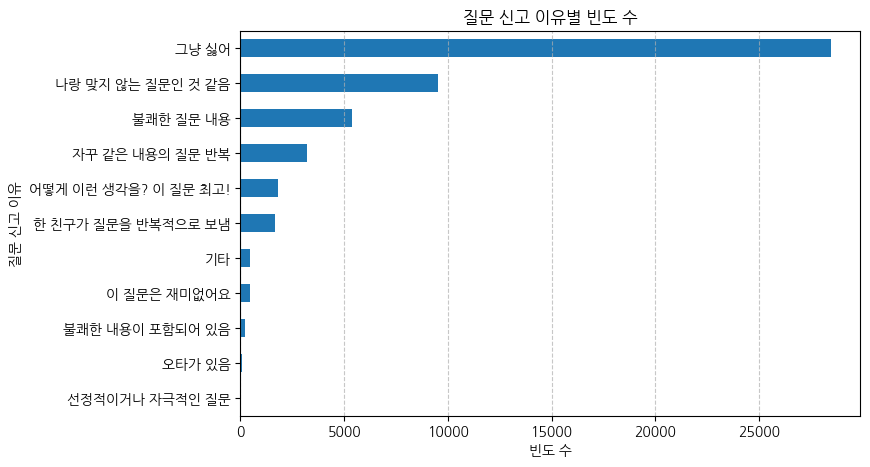

In [118]:
# reason별 개수 계산 (내림차순 정렬)
reason_counts = df_question_report["reason"].value_counts(ascending=True)  # 내림차순 정렬

# 가로 막대 그래프 시각화
plt.figure(figsize=(8, 5))
reason_counts.plot(kind="barh")

# 그래프 제목 및 레이블 설정
plt.title("질문 신고 이유별 빈도 수")
plt.xlabel("빈도 수")
plt.ylabel("질문 신고 이유")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

'그냥 싫어'가 가장 많아 일종의 불쾌감을 느꼈지만 선택지 중에 적합한 신고 이유가 없거나 이유를 알리기 싫은 것이 많은 것으로 보인다.

### 질문 세트

In [119]:
df_question_set.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


In [120]:
df_question_set.describe(include='all')

,id,question_piece_id_list,opening_time,status,created_at,user_id
count,1.583840e+05,158384,158384,158384,158384,1.583840e+05
unique,NaN,158384,NaN,3,NaN,NaN
top,NaN,"[208385221, 208385222, 208385223, 208385224, 2...",NaN,F,NaN,NaN
freq,NaN,1,NaN,153411,NaN,NaN
mean,7.641274e+06,NaN,2023-05-17 13:25:41.180416256,NaN,2023-05-17 12:43:12.170648832,1.106752e+06
min,9.981700e+04,NaN,2023-04-28 12:27:22,NaN,2023-04-28 12:27:23,8.380230e+05
25%,1.953393e+06,NaN,2023-05-09 15:46:49.500000,NaN,2023-05-09 14:58:05.500000,8.847470e+05
50%,6.757335e+06,NaN,2023-05-15 13:43:55.500000,NaN,2023-05-15 13:04:46.500000,1.117999e+06
75%,1.217510e+07,NaN,2023-05-22 11:43:24.500000,NaN,2023-05-22 11:04:03,1.261250e+06
max,2.083845e+07,NaN,2024-05-07 12:12:30,NaN,2024-05-07 11:32:30,1.583358e+06


In [121]:
df_question_set.isnull().sum()

id                        0
question_piece_id_list    0
opening_time              0
status                    0
created_at                0
user_id                   0
dtype: int64

In [122]:
df_question_set.duplicated().sum()

np.int64(0)

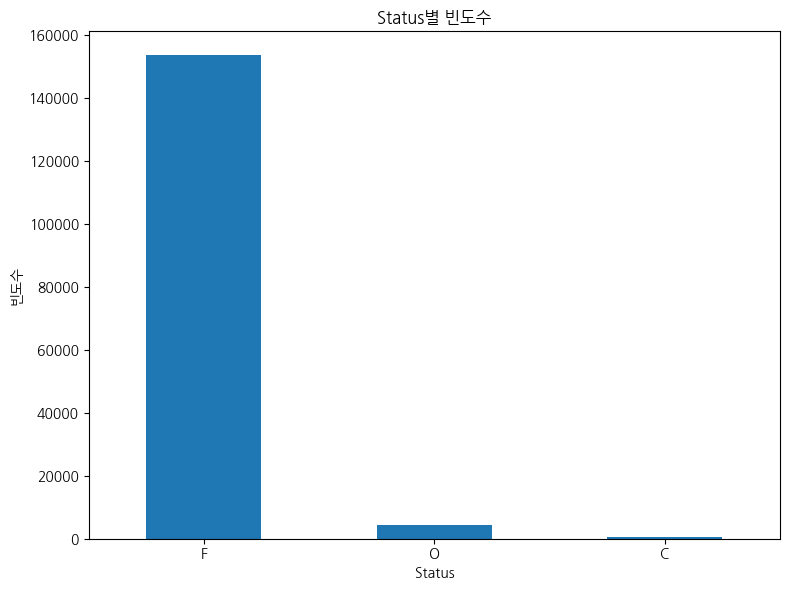

In [123]:
status_counts = df_question_set['status'].value_counts()

# 빈도수를 막대 그래프로 시각화
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar')

# 그래프 제목 및 레이블 설정
plt.title('Status별 빈도수')
plt.xlabel('Status')
plt.ylabel('빈도수')

# x축 레이블 회전 및 레이블 간격 조정
plt.xticks(rotation=0)

# 레이아웃 최적화
plt.tight_layout()

# 그래프 출력
plt.show()


F: Finished (종료) // O: Opened(열림) // C: Closed(닫힘)

질문 세트 상태에서 종료된 상태가 가장 많다. 대부분 질문을 열림 혹은 닫힘 상태로 내버려두지 않고 종료를 한다는 것으로 보여진다.

### 질문 조각에 등장하는 유저

In [124]:
df_question_show_user.head()

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446


In [125]:
df_question_show_user.describe(include='all')

,id,created_at,question_piece_id,user_id
count,4.769609e+06,4769609,4.769609e+06,4.769609e+06
mean,2.388684e+08,2023-05-17 13:57:52.437731072,7.430248e+07,1.090241e+06
min,3.088872e+06,2023-04-28 12:27:49,9.984580e+05,8.331120e+05
25%,6.270339e+07,2023-05-10 02:49:19,1.891695e+07,8.835900e+05
50%,2.126700e+08,2023-05-15 16:15:12,6.639655e+07,1.087460e+06
75%,3.800215e+08,2023-05-22 11:33:33,1.178876e+08,1.233969e+06
max,6.466726e+08,2024-05-08 01:36:18,2.083515e+08,1.580629e+06
std,1.844893e+08,NaN,5.761959e+07,2.018190e+05


In [126]:
df_question_show_user.isnull().sum()

id                   0
created_at           0
question_piece_id    0
user_id              0
dtype: int64

In [127]:
df_question_show_user.duplicated().sum()

np.int64(0)

## 전처리

In [128]:
# session_id와 user_id가 같은 행을 필터링
df_filtered = df_2308[df_2308['user_id'] != df_2308['session_id']]

# 변경된 데이터 개수 확인
removed_rows = len(df_2308) - len(df_filtered)

print(f"제거된 행 개수: {removed_rows}개")
print(f"새로운 데이터프레임 크기: {df_filtered.shape}")

# 기존 df_2308을 업데이트
df_2308 = df_filtered.copy()

제거된 행 개수: 43468개
새로운 데이터프레임 크기: (4996593, 10)


In [129]:
len(df_2308['user_id'].unique())

124215

In [130]:
# 전체 유저 중 기능 테스트 목적으로 보이는 유저들 제외
# ✅ 제외할 유저 목록
excluded_users = [
    '1437875', '967606', '1577938', '1579185', '1446852', '1577930', '967617', 
    '967442', '967524', '1577954', '1580105', '849763', '834358'
]

# ✅ 제외할 유저 필터링
df_2308 = df_2308[~df_2308['user_id'].isin(excluded_users)]

remained_users = len(df_2308['user_id'].unique())

print(f"남은 유저 수: {remained_users}")

남은 유저 수: 124202


In [131]:
# session_id와 user_id가 같은 행을 필터링
df_filtered = df_2309[df_2309['user_id'] != df_2309['session_id']]

# 변경된 데이터 개수 확인
removed_rows = len(df_2309) - len(df_filtered)

print(f"제거된 행 개수: {removed_rows}개")
print(f"새로운 데이터프레임 크기: {df_filtered.shape}")

# 기존 df_2309을 업데이트
df_2309 = df_filtered.copy()

제거된 행 개수: 247700개
새로운 데이터프레임 크기: (9159212, 10)


In [132]:
len(df_2309['user_id'].unique())

156981

In [133]:
# 전체 유저 중 기능 테스트 목적으로 보이는 유저 아이디와 None값 제외
# ✅ 제외할 유저 목록 (문자열 변환 가능성 고려)
excluded_users = ['1579185', '967442', '1446852', None]  # None 값 제외

# ✅ 제외할 유저 필터링
df_2309 = df_2309[~df_2309['user_id'].isin(excluded_users)]

remained_users = len(df_2309['user_id'].unique())

print(f"남은 유저 수: {remained_users}")

남은 유저 수: 156977


In [134]:
# session_id와 user_id가 같은 행을 필터링
df_filtered = df_230810[df_230810['user_id'] != df_230810['session_id']]

# 변경된 데이터 개수 확인
removed_rows = len(df_230810) - len(df_filtered)

print(f"제거된 행 개수: {removed_rows}개")
print(f"새로운 데이터프레임 크기: {df_filtered.shape}")

# 업데이트
df_230810 = df_filtered.copy()

제거된 행 개수: 372541개
새로운 데이터프레임 크기: (15033052, 10)


## 데이터 분석

### 기존 기능에 대한 사용자 행동 분석

#### 일일 출석 기능 참여 유저 수 분석

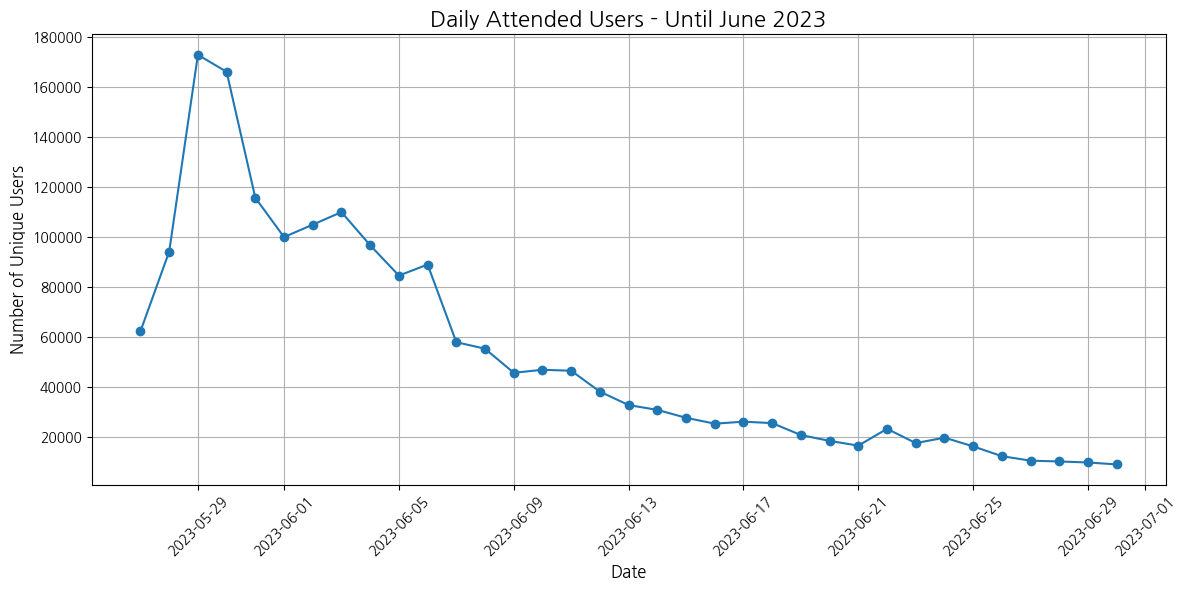

In [135]:
# attendance_date_list를 기준으로 데이터를 확장하여 각 날짜마다 한 행으로 나열
date_user_mapping = df_attendance.explode('attendance_date_list')

# attendance_date_list를 기준으로 그룹화하고 날짜별 고유 사용자 수 계산
dau_data = date_user_mapping.groupby('attendance_date_list')['user_id'].nunique().reset_index()
dau_data.columns = ['date', 'unique_users']  # 열 이름 변경: 날짜, 고유 사용자 수

# 날짜 데이터를 datetime 형식으로 변환 (시각화 시 정렬 및 처리 용이)
dau_data['date'] = pd.to_datetime(dau_data['date'])

# 2023년 7월까지만 필터링
dau_data = dau_data[dau_data['date'] <= '2023-06-30']

# 날짜를 기준으로 데이터를 정렬
dau_data = dau_data.sort_values('date')

# DAU (Daily Active Users) 그래프 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
plt.plot(dau_data['date'], dau_data['unique_users'], marker='o', linestyle='-')  # 선 그래프 그리기
plt.title('Daily Attended Users - Until June 2023', fontsize=16)  # 그래프 제목
plt.xlabel('Date', fontsize=12)  # x축 레이블
plt.ylabel('Number of Unique Users', fontsize=12)  # y축 레이블
plt.grid(True)  # 그리드 추가
plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 출력

#### 기존 기능 데이터 분석 결과

In [136]:
df_question_set["question_piece_id_list"] = df_question_set["question_piece_id_list"].apply(ast.literal_eval)

# 리스트 풀어내기
df_question_set_expanded = df_question_set.explode("question_piece_id_list").reset_index(drop=True)

# question_set_number 생성
df_question_set_expanded["question_set_number"] = df_question_set_expanded.groupby("id").cumcount() + 1

# 컬럼명 변경 및 정렬
df_question_set_expanded.rename(columns={"question_piece_id_list": "question_piece_id", "id": "question_set_id"}, inplace=True)
df_question_set_expanded = df_question_set_expanded[["question_set_id", "question_set_number", "question_piece_id", "opening_time", "status", "created_at", "user_id"]]

# 병합
df_question_set_piece = pd.merge(
    df_question_piece,
    df_question_set_expanded[["question_set_id", "question_set_number", "question_piece_id", "user_id"]],
    left_on="id",
    right_on="question_piece_id",
    how="left"
)

# 기존 question_piece_id 제거
df_question_set_piece.drop(columns=["question_piece_id"], inplace=True)

# id 컬럼을 question_piece_id로 이름 변경
df_question_set_piece.rename(columns={"id": "question_piece_id"}, inplace=True)

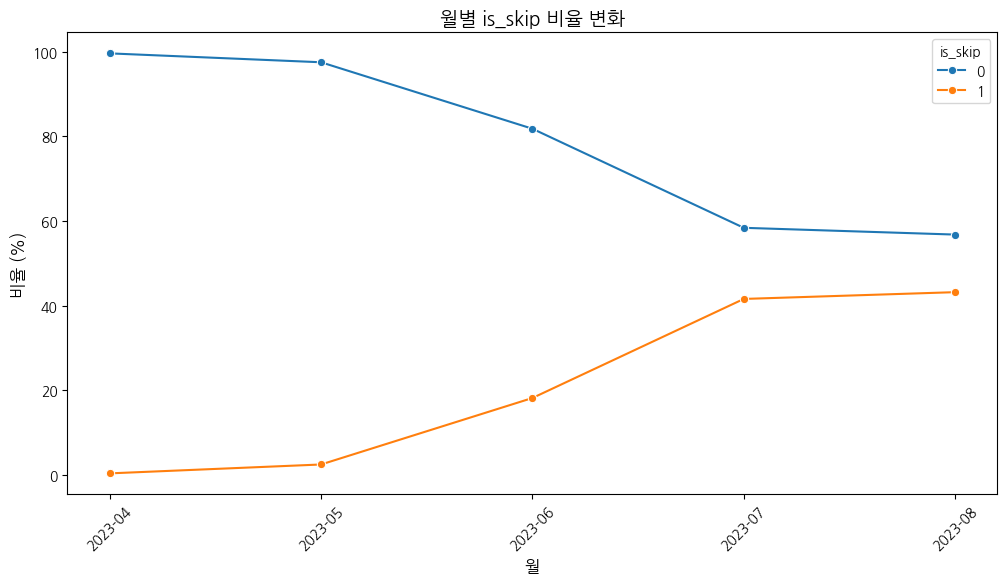

In [137]:
# 월별 스킵 비율 변화
df_question_vote = pd.merge(df_question_set_piece,
                            df_vote[['chosen_user_id', 'question_piece_id', 'answer_status', 'has_read']], on = 'question_piece_id', how = 'left')

df_question_vote['is_skip'] = df_question_vote['chosen_user_id'].isna().astype(int)
df_monthly_skip = df_question_vote.groupby([df_question_vote['created_at'].dt.to_period('M'),'is_skip']).size().reset_index(name = 'count')

df_monthly_skip['total'] = df_monthly_skip.groupby('created_at')['count'].transform('sum')
df_monthly_skip['ratio'] = round(df_monthly_skip['count'] / df_monthly_skip['total'], 3) * 100
df_monthly_skip['created_at'] = df_monthly_skip['created_at'].astype(str)  # 문자열 변환

# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_monthly_skip[df_monthly_skip['created_at'] <= '2023-08'], x='created_at', y='ratio', hue='is_skip', marker='o')

# 그래프 설정
plt.title("월별 is_skip 비율 변화", fontsize=14)
plt.xlabel("월", fontsize=12)
plt.ylabel("비율 (%)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="is_skip")

# 그래프 출력
plt.show()

In [138]:
# 질문에 대한 유저들 신고 사유

df_reason_counts = df_question_report['reason'].value_counts(normalize=True).to_frame(name='ratio')
df_reason_counts['count'] = df_question_report['reason'].value_counts()
df_reason_counts['ratio'] = df_reason_counts['ratio'] * 100  # 백분율 변환
df_reason_counts = df_reason_counts[['count', 'ratio']]  # 컬럼 순서 정리
df_reason_counts

,count,ratio
reason,,
그냥 싫어,28446,55.316584
나랑 맞지 않는 질문인 것 같음,9541,18.553594
불쾌한 질문 내용,5386,10.473709
자꾸 같은 내용의 질문 반복,3202,6.226665
어떻게 이런 생각을? 이 질문 최고!,1821,3.541148
한 친구가 질문을 반복적으로 보냄,1701,3.307794
기타,480,0.933416
이 질문은 재미없어요,471,0.915915
불쾌한 내용이 포함되어 있음,250,0.486154


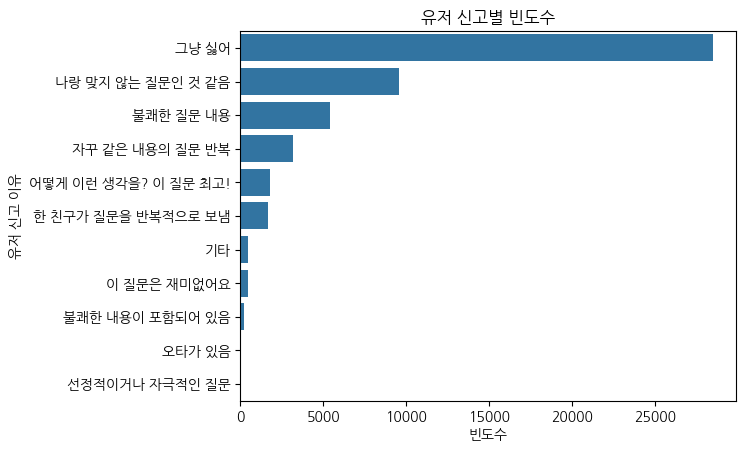

In [139]:
sns.countplot(y='reason', data=df_question_report, order=df_question_report['reason'].value_counts().index)
# 제목 및 레이블 설정
plt.xlabel("빈도수")
plt.ylabel("유저 신고 이유")
plt.title("유저 신고별 빈도수")
plt.show()

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1907464733.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=question_counts.values, y=question_counts.index, palette="coolwarm")


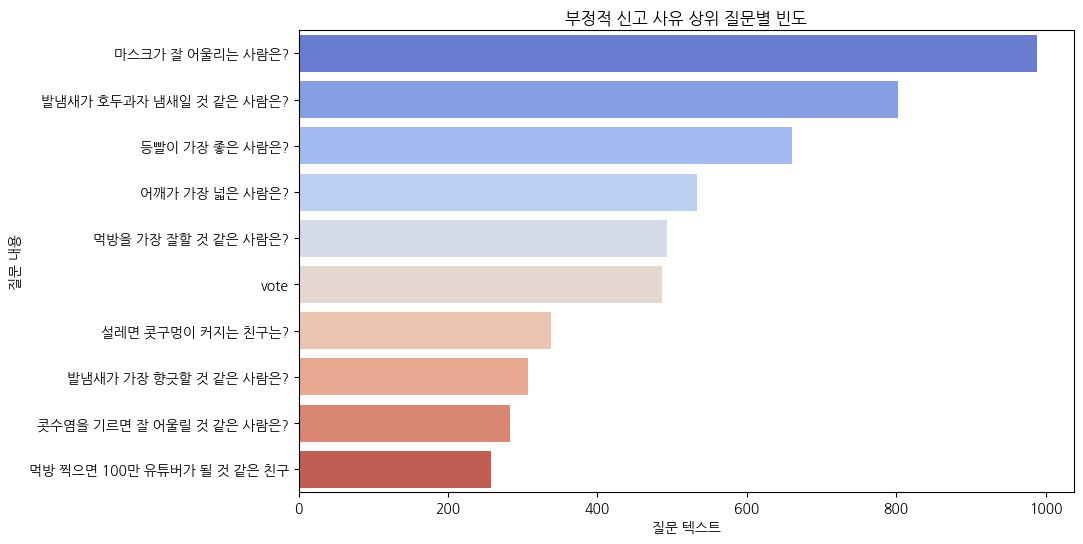

In [140]:
# 부정적 사유로 신고 받은 질문 상위 10개

# question_id를 기준으로 두 데이터프레임 병합
df_merged = df_question_report.merge(df_question, left_on="question_id", right_on="id", how="left")

# 신고 건수를 질문별로 집계
question_counts = df_merged["question_text"].value_counts().nlargest(10)  # 상위 10개만 선택

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=question_counts.values, y=question_counts.index, palette="coolwarm")

plt.xlabel("질문 텍스트")
plt.ylabel("질문 내용")
plt.title("부정적 신고 사유 상위 질문별 빈도")
plt.show()

In [141]:
# 탈퇴 이유

df_reason_counts = df_withdraw['reason'].value_counts(normalize=True).to_frame(name='ratio')
df_reason_counts['count'] = df_withdraw['reason'].value_counts()
df_reason_counts['ratio'] = df_reason_counts['ratio'] * 100  # 백분율 변환
df_reason_counts = df_reason_counts[['count', 'ratio']]  # 순서 조정
df_reason_counts

,count,ratio
reason,,
기타 이유,40301,56.951275
함께 할 친구가 없어서,14450,20.419988
재밌는 질문이 없어서,13133,18.558872
버그가 너무 많아서,2031,2.870103
구독료가 너무 비싸서,730,1.031598
admin,61,0.086202
test,53,0.074897
기타,5,0.007066


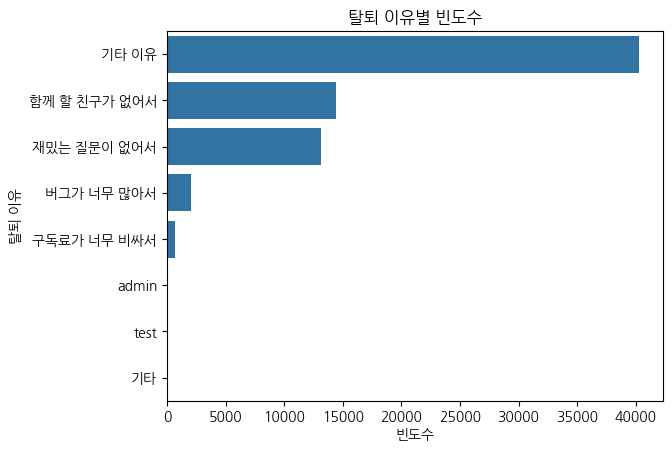

In [142]:
sns.countplot(y='reason', data=df_withdraw, order=df_withdraw['reason'].value_counts().index)
# 제목 및 레이블 설정
plt.xlabel("빈도수")
plt.ylabel("탈퇴 이유")
plt.title("탈퇴 이유별 빈도수")
plt.show()

#### 질문 응답과 재방문 일수 관계 분석

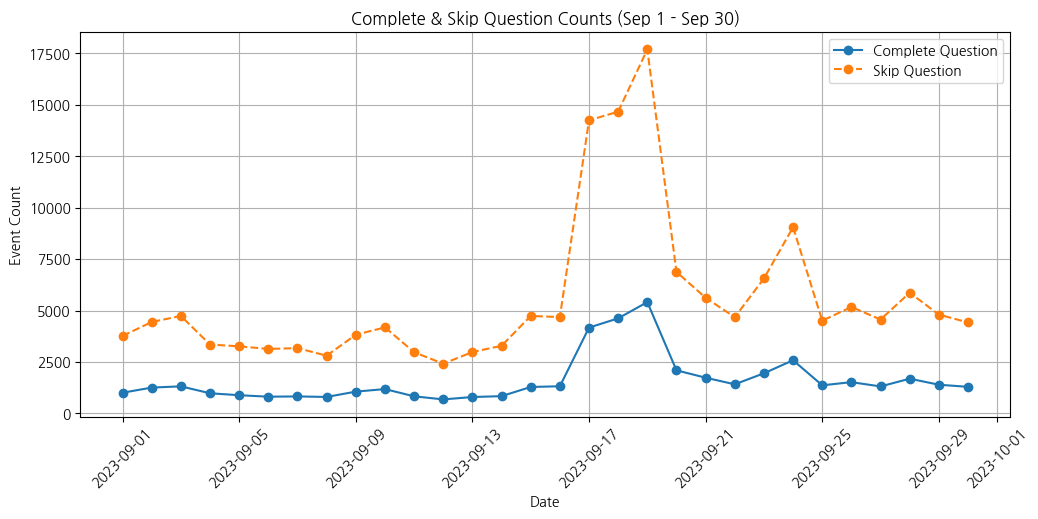

In [143]:
# 날짜 변환 및 필터링 (9월 1일 ~ 9월 30일 데이터)
df_2309["Asia/Seoul"] = pd.to_datetime(df_2309["Asia/Seoul"])
df_september = df_2309[(df_2309["Asia/Seoul"] >= "2023-09-01") & (df_2309["Asia/Seoul"] < "2023-10-1")]

# complete_question_question과 skip_question_question 이벤트 수 계산
df_september_counts = df_september[df_september["event_key"].isin(["complete_question_question", "skip_question_question"])]
df_september_counts = df_september_counts.groupby([df_september_counts["Asia/Seoul"].dt.date, "event_key"]).size().unstack(fill_value=0)

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(df_september_counts.index, df_september_counts["complete_question_question"], label="Complete Question", marker='o')
plt.plot(df_september_counts.index, df_september_counts["skip_question_question"], label="Skip Question", marker='o', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("Event Count")
plt.title("Complete & Skip Question Counts (Sep 1 - Sep 30)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

{'log_complete_question_question': {'correlation': np.float64(0.539484897664954), 'p_value': np.float64(0.0)}, 'log_skip_question_question': {'correlation': np.float64(0.3829895376147945), 'p_value': np.float64(0.0)}}


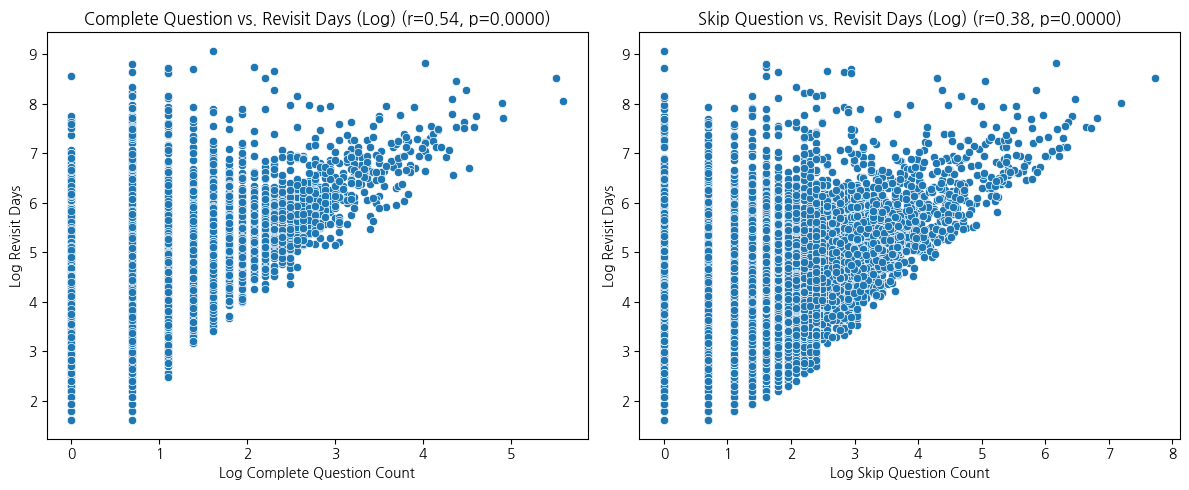

In [144]:
# Skip 또는 Complete 이벤트가 있는 유저만 필터링
df_filtered = df_september[df_september["event_key"].isin(["complete_question_question", "skip_question_question"])]

# 유저별 complete 및 skip 이벤트 수 계산
df_events_count = df_filtered.groupby(["user_id", "event_key"]).size().unstack(fill_value=0).reset_index()
df_events_count.columns = ["user_id", "complete_question_question", "skip_question_question"]

# 유저별 방문일수 계산
df_visits = df_september.groupby("user_id")["Asia/Seoul"].nunique().reset_index()
df_visits.columns = ["user_id", "revisit_days"]

# 데이터 병합
df_merged = df_events_count.merge(df_visits, on="user_id", how="left").fillna(0)

# 로그 변환 (log1p 사용하여 0 처리)
df_merged["log_complete_question"] = np.log1p(df_merged["complete_question_question"])
df_merged["log_skip_question"] = np.log1p(df_merged["skip_question_question"])
df_merged["log_revisit_days"] = np.log1p(df_merged["revisit_days"])

# 로그 변환 후 상관계수 및 p-value 계산
corr_log_complete, p_value_log_complete = pearsonr(df_merged["log_complete_question"], df_merged["log_revisit_days"])
corr_log_skip, p_value_log_skip = pearsonr(df_merged["log_skip_question"], df_merged["log_revisit_days"])

# 상관계수 및 p-value 출력
corr_results = {
    "log_complete_question_question": {"correlation": corr_log_complete, "p_value": p_value_log_complete},
    "log_skip_question_question": {"correlation": corr_log_skip, "p_value": p_value_log_skip},
}
print(corr_results)

# 시각화 (로그 변환 후 산점도)
plt.figure(figsize=(12, 5))

# Complete Question vs. Revisit Days (로그 변환 후)
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_merged["log_complete_question"], y=df_merged["log_revisit_days"])
plt.title(f"Complete Question vs. Revisit Days (Log) (r={corr_log_complete:.2f}, p={p_value_log_complete:.4f})")
plt.xlabel("Log Complete Question Count")
plt.ylabel("Log Revisit Days")

# Skip Question vs. Revisit Days (로그 변환 후)
plt.subplot(1, 2, 2)
sns.scatterplot(x=df_merged["log_skip_question"], y=df_merged["log_revisit_days"])
plt.title(f"Skip Question vs. Revisit Days (Log) (r={corr_log_skip:.2f}, p={p_value_log_skip:.4f})")
plt.xlabel("Log Skip Question Count")
plt.ylabel("Log Revisit Days")

plt.tight_layout()
plt.show()

### 신규 기능에 대한 유저들의 반응

#### AI 프로필 기능

In [145]:
# view_face_make 이벤트 최초 등장 시점 찾기
first_view_face_make_time = df_2308[df_2308['event_key'] == "view_face_make"]['Asia/Seoul'].min()
print(f"view_face_make 최초 등장 시점: {first_view_face_make_time}")

# view_imagine_make 이벤트 최초 등장 시점 찾기
first_view_imagine_make_time = df_2308[df_2308['event_key'] == "view_imagine_make"]['Asia/Seoul'].min()
print(f"view_imagine_make 최초 등장 시점: {first_view_imagine_make_time}")

view_face_make 최초 등장 시점: 2023-08-23T16:48:47.613Z
view_imagine_make 최초 등장 시점: 2023-08-23T16:20:35.127Z



=== 기준 시점 이전과 이후 12일 기능별 이벤트 발생 횟수 비교 ===
               이전 12일 이벤트 발생 횟수  이후 12일 이벤트 발생 횟수
질문 관련 기능                 536480            428874
구매 관련 기능                   9624              9462
얼굴/사진 관련 기능                   0             35126
Imagine 관련 기능                 0            146001
메시지 기능                     5594              3049
친구 초대 기능                  11803              7387


<Figure size 1000x600 with 0 Axes>

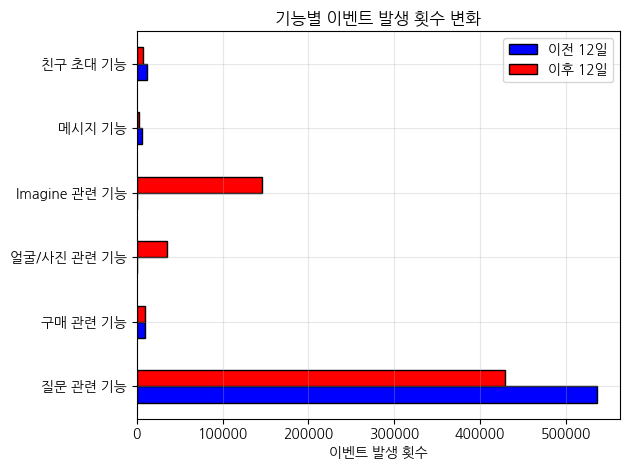

In [146]:
# 기능별 이벤트 그룹 정의
feature_groups = {
    "질문 관련 기능": [
        "view_questions_tap", "complete_question_question", "click_question_ask", "click_question_open",
        "click_question_start", "click_random_ask_normal", "click_random_ask_other", "click_random_ask_shuffle",
        "skip_question_question", "click_question_share", "click_question_hint", "click_question_hint_initial",
        "click_question_message"
    ],
    "구매 관련 기능": [
        "click_purchase", "complete_purchase", "view_shop"
    ],
    "얼굴/사진 관련 기능": [
        "view_face_make", "click_face_take_photo", "click_face_select_photo",
        "click_face_start", "view_face_showroom"
    ],
    "Imagine 관련 기능": [
        "view_imagine_make", "view_imagine_tap", "view_imagine_facelist",
        "click_imagine_start", "click_imagine_copy_prompt", "click_imagine_share"
    ],
    "메시지 기능": [
        "view_message_tap", "view_message_detail", "click_timeline_chat_start"
    ],
    "친구 초대 기능": [
        "click_appbar_friend_plus", "click_invite_friend", "click_friend_invite",
        "click_autoadd_contact", "view_friend_plus_tap", "click_search_friend"
    ]
}

df_2308_cleaned = df_2308

# 기준 시점 설정
pivot_time = pd.Timestamp("2023-08-23 16:20:00.727000+00:00")

# 기간 설정 (이후 12일)
time_delta = pd.Timedelta(days=12)
end_time = pivot_time + time_delta

# 날짜 데이터 변환
df_2308_cleaned['Asia/Seoul'] = pd.to_datetime(df_2308_cleaned['Asia/Seoul'])

# 이전 기간과 이후 기간 데이터 분리
before_pivot = df_2308_cleaned[df_2308_cleaned['Asia/Seoul'] < pivot_time]
after_pivot = df_2308_cleaned[(df_2308_cleaned['Asia/Seoul'] >= pivot_time) & (df_2308_cleaned['Asia/Seoul'] <= end_time)]

# 기능별 이벤트 발생 횟수 계산 함수
def count_feature_events(df):
    feature_event_counts = {feature: 0 for feature in feature_groups}
    for _, row in df.iterrows():
        event = row['event_key']
        for feature, events in feature_groups.items():
            if event in events:
                feature_event_counts[feature] += 1
                break
    return feature_event_counts

# 이전과 이후 기간의 이벤트 발생 횟수 계산
before_counts = count_feature_events(before_pivot)
after_counts = count_feature_events(after_pivot)

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    "이전 12일 이벤트 발생 횟수": before_counts,
    "이후 12일 이벤트 발생 횟수": after_counts
})

# 결과 출력
print("\n=== 기준 시점 이전과 이후 12일 기능별 이벤트 발생 횟수 비교 ===")
print(comparison_df)

# 시각화
plt.figure(figsize=(10, 6))
comparison_df.plot(kind="barh", color=["blue", "red"], edgecolor="black")
plt.xlabel("이벤트 발생 횟수")
plt.title("기능별 이벤트 발생 횟수 변화")
plt.grid(alpha=0.3)
plt.legend(["이전 12일", "이후 12일"])
plt.tight_layout()
plt.show()

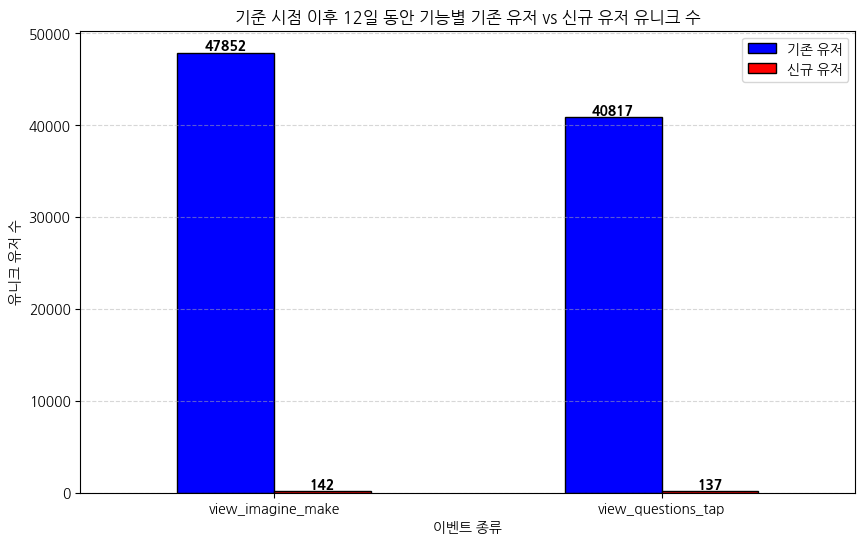

In [147]:
# 날짜 데이터 변환
df_2308_cleaned = df_2308.copy()
df_2308_cleaned['Asia/Seoul'] = pd.to_datetime(df_2308_cleaned['Asia/Seoul'])

# 기준 시점 설정
pivot_time = pd.Timestamp("2023-08-23 16:20:00.727000+00:00")
end_time = pivot_time + pd.Timedelta(days=12)  # 기준 시점 이후 14일까지만

# user_properties의 created_at을 추출하여 유저 생성일 구하기
def extract_created_at(user_properties):
    try:
        user_dict = ast.literal_eval(user_properties) if isinstance(user_properties, str) else user_properties
        return pd.Timestamp(user_dict.get('created_at')) if 'created_at' in user_dict else None
    except:
        return None

df_2308_cleaned['user_created_at'] = df_2308_cleaned['user_properties'].apply(extract_created_at)

# 유저가 기준일 이전 생성된 유저인지 이후 생성된 유저인지 분류
df_2308_cleaned['user_type'] = df_2308_cleaned['user_created_at'].apply(lambda x: '기존 유저' if x and x < pivot_time else '신규 유저')

# 기준 시점 이후 12일 동안의 데이터 필터링
filtered_df = df_2308_cleaned[(df_2308_cleaned['Asia/Seoul'] > pivot_time) & (df_2308_cleaned['Asia/Seoul'] <= end_time)]

# 분석할 이벤트 유형 정의
event_types = ["view_imagine_make", "view_questions_tap"]

# 필터링: 선택한 이벤트만
filtered_df = filtered_df[filtered_df['event_key'].isin(event_types)]

# 이벤트별 기존 유저와 신규 유저 수 계산
user_counts = filtered_df.groupby(['event_key', 'user_type'])['user_id'].nunique().unstack().fillna(0)

# 📊 시각화
ax = user_counts.plot(kind="bar", figsize=(10, 6), color=["blue", "red"], edgecolor="black")

plt.title("기준 시점 이후 12일 동안 기능별 기존 유저 vs 신규 유저 유니크 수")
plt.xlabel("이벤트 종류")
plt.ylabel("유니크 유저 수")
plt.xticks(rotation=0)
plt.legend(["기존 유저", "신규 유저"])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color="black", fontweight="bold")

# 그래프 표시
plt.show()

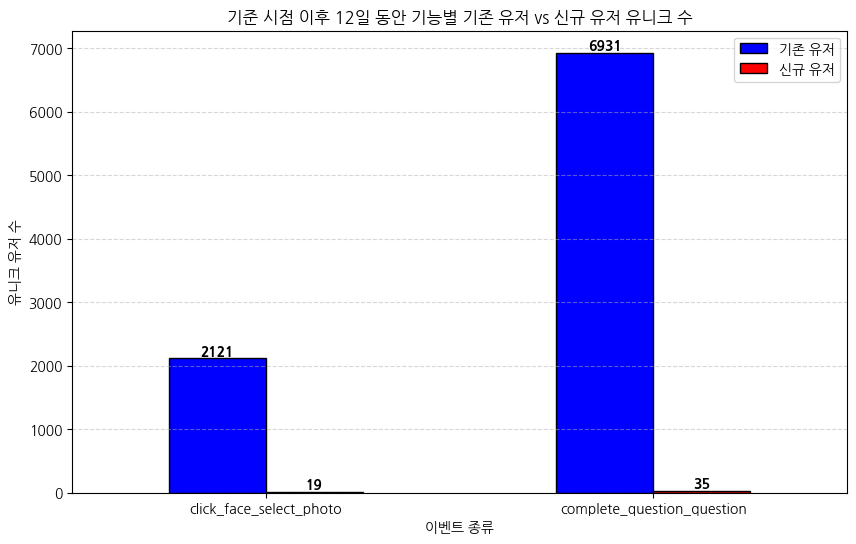

In [148]:
# 날짜 데이터 변환
df_2308_cleaned = df_2308.copy()
df_2308_cleaned['Asia/Seoul'] = pd.to_datetime(df_2308_cleaned['Asia/Seoul'])

# 기준 시점 설정
pivot_time = pd.Timestamp("2023-08-23 16:20:00.727000+00:00")
end_time = pivot_time + pd.Timedelta(days=12)  # 기준 시점 이후 14일까지만

# user_properties의 created_at을 추출하여 유저 생성일 구하기
def extract_created_at(user_properties):
    try:
        user_dict = ast.literal_eval(user_properties) if isinstance(user_properties, str) else user_properties
        return pd.Timestamp(user_dict.get('created_at')) if 'created_at' in user_dict else None
    except:
        return None

df_2308_cleaned['user_created_at'] = df_2308_cleaned['user_properties'].apply(extract_created_at)

# 유저가 기준일 이전 생성된 유저인지 이후 생성된 유저인지 분류
df_2308_cleaned['user_type'] = df_2308_cleaned['user_created_at'].apply(lambda x: '기존 유저' if x and x < pivot_time else '신규 유저')

# 기준 시점 이후 12일 동안의 데이터 필터링
filtered_df = df_2308_cleaned[(df_2308_cleaned['Asia/Seoul'] > pivot_time) & (df_2308_cleaned['Asia/Seoul'] <= end_time)]

# 분석할 이벤트 유형 정의
event_types = ["click_face_select_photo", "complete_question_question"]

# 필터링: 선택한 이벤트만
filtered_df = filtered_df[filtered_df['event_key'].isin(event_types)]

# 이벤트별 기존 유저와 신규 유저 수 계산
user_counts = filtered_df.groupby(['event_key', 'user_type'])['user_id'].nunique().unstack().fillna(0)

# 📊 시각화
ax = user_counts.plot(kind="bar", figsize=(10, 6), color=["blue", "red"], edgecolor="black")

plt.title("기준 시점 이후 12일 동안 기능별 기존 유저 vs 신규 유저 유니크 수")
plt.xlabel("이벤트 종류")
plt.ylabel("유니크 유저 수")
plt.xticks(rotation=0)
plt.legend(["기존 유저", "신규 유저"])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color="black", fontweight="bold")

# 그래프 표시
plt.show()

In [149]:
# AI 프로필 기능 추가된 시점 설정
imagine_feature_release_time = pd.Timestamp("2023-08-23 16:20:00.727000+00:00")
end_time = imagine_feature_release_time + pd.Timedelta(days=12)  # 이후 12일

# 날짜 데이터 변환
df_2308['Asia/Seoul'] = pd.to_datetime(df_2308['Asia/Seoul'])

# AI 프로필 기능 추가 이후 12일 동안의 데이터 필터링
filtered_df = df_2308[(df_2308['Asia/Seoul'] >= imagine_feature_release_time) & (df_2308['Asia/Seoul'] < end_time)]

# 유니크한 유저 ID 개수 계산
num_unique_users = filtered_df['user_id'].nunique()

# 결과 출력
print(f"AI 프로필 기능 추가 이후 12일 동안의 유저 ID 수: {num_unique_users}")

AI 프로필 기능 추가 이후 12일 동안의 유저 ID 수: 59231


In [150]:
# AI 프로필 기능 추가된 시점 설정
imagine_feature_release_time = pd.Timestamp("2023-08-23 16:56:40.727000+00:00")
end_time = imagine_feature_release_time + pd.Timedelta(days=14)  # 이후 14일

# 날짜 데이터 변환
df_2308['Asia/Seoul'] = pd.to_datetime(df_2308['Asia/Seoul'])

# AI 프로필 기능 추가 이후 14일 동안의 데이터 필터링
filtered_df = df_2308[(df_2308['Asia/Seoul'] >= imagine_feature_release_time) & (df_2308['Asia/Seoul'] < end_time)]

# 유니크한 유저 ID 개수 계산
num_unique_users = filtered_df['user_id'].nunique()

# 결과 출력
print(f"AI 프로필 기능 추가 이후 14일 동안의 유저 ID 수: {num_unique_users}")

AI 프로필 기능 추가 이후 14일 동안의 유저 ID 수: 64420


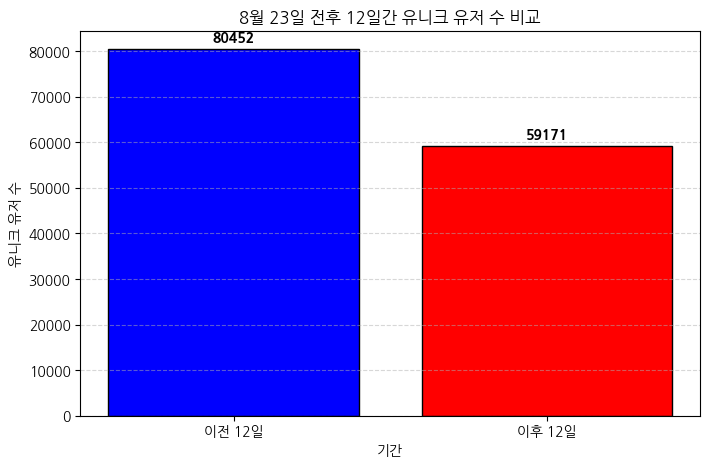

In [151]:
# 기준 시점 설정 (2023년 8월 23일)
pivot_time = pd.Timestamp("2023-08-23T16:56:40Z")

# 전후 12일 기간 설정
before_start = pivot_time - pd.Timedelta(days=12)
after_end = pivot_time + pd.Timedelta(days=12)

# 날짜 데이터 변환
df_2308['Asia/Seoul'] = pd.to_datetime(df_2308['Asia/Seoul'])

# 이전 12일과 이후 12일 데이터 필터링
before_pivot = df_2308[(df_2308['Asia/Seoul'] >= before_start) & (df_2308['Asia/Seoul'] < pivot_time)]
after_pivot = df_2308[(df_2308['Asia/Seoul'] >= pivot_time) & (df_2308['Asia/Seoul'] < after_end)]

# 유니크한 유저 수 계산
before_user_count = before_pivot['user_id'].nunique()
after_user_count = after_pivot['user_id'].nunique()

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    "기간": ["이전 12일", "이후 12일"],
    "유니크 유저 수": [before_user_count, after_user_count]
})

# 📊 시각화
plt.figure(figsize=(8, 5))
plt.bar(comparison_df["기간"], comparison_df["유니크 유저 수"], color=["blue", "red"], edgecolor="black")

plt.title("8월 23일 전후 12일간 유니크 유저 수 비교")
plt.xlabel("기간")
plt.ylabel("유니크 유저 수")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 숫자 표시
for i, value in enumerate(comparison_df["유니크 유저 수"]):
    plt.text(i, value + max(comparison_df["유니크 유저 수"]) * 0.02, str(value), ha='center', fontsize=10, fontweight="bold")

# 그래프 표시
plt.show()

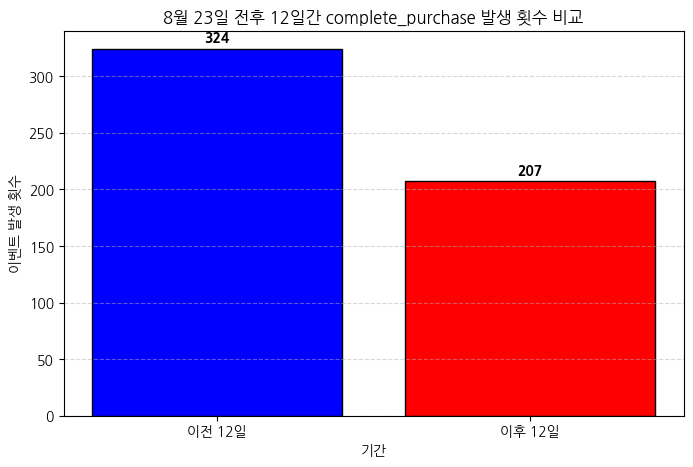

In [152]:
# "complete_purchase" 이벤트 카운트
before_count = before_pivot[before_pivot['event_key'] == 'complete_purchase'].shape[0]
after_count = after_pivot[after_pivot['event_key'] == 'complete_purchase'].shape[0]

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    "기간": ["이전 12일", "이후 12일"],
    "complete_purchase 횟수": [before_count, after_count]
})

# 📊 시각화
plt.figure(figsize=(8, 5))
bars = plt.bar(comparison_df["기간"], comparison_df["complete_purchase 횟수"], color=["blue", "red"], edgecolor="black")

plt.title("8월 23일 전후 12일간 complete_purchase 발생 횟수 비교")
plt.xlabel("기간")
plt.ylabel("이벤트 발생 횟수")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(comparison_df["complete_purchase 횟수"]) * 0.02, 
             str(height), ha='center', fontsize=10, fontweight="bold")

# 그래프 표시
plt.show()


=== 일별 imagine 관련 기능 이벤트 발생 횟수 (최초 발생: 2023-08-19) ===
Asia/Seoul
2023-08-19      246
2023-08-20       34
2023-08-21       64
2023-08-22       61
2023-08-23     8932
2023-08-24    15873
2023-08-25    13394
2023-08-26    16424
2023-08-27    17615
2023-08-28    11249
2023-08-29     9344
2023-08-30     9348
2023-08-31     8425
2023-09-01     8960
2023-09-02    10963
2023-09-03    12374
2023-09-04     8623
2023-09-05     7195
2023-09-06     6525
2023-09-07     6535
2023-09-08     6593
2023-09-09     9195
2023-09-10    10231
2023-09-11     6453
2023-09-12     4349
Name: event_key, dtype: int64


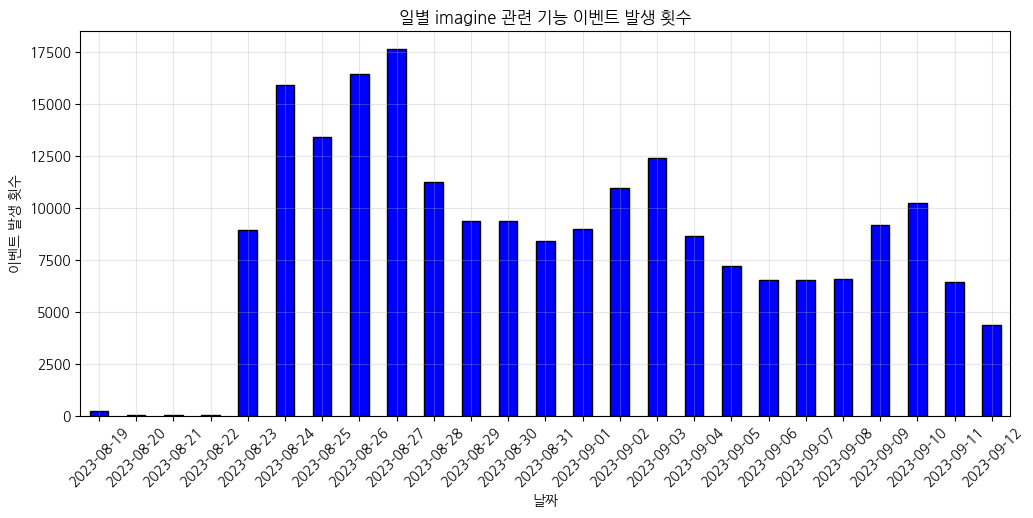

In [153]:
# 커뮤니티 관련 기능 이벤트 목록
imagine_events = [
    "view_imagine_make", "view_imagine_tap", "view_imagine_facelist",
        "click_imagine_start", "click_imagine_copy_prompt", "click_imagine_share"
]

# 날짜 데이터 변환
df_230810['Asia/Seoul'] = pd.to_datetime(df_230810['Asia/Seoul'])

# 커뮤니티 기능 이벤트만 필터링
imagine_df = df_230810[df_230810['event_key'].isin(imagine_events)]

# 커뮤니티 관련 기능 이벤트 최초 발생 시점 찾기
first_imagine_event_time = imagine_df['Asia/Seoul'].min()

# 해당 시점 이후 데이터만 사용
imagine_df = imagine_df[imagine_df['Asia/Seoul'] >= first_imagine_event_time]

# 일별 이벤트 발생 횟수 집계
daily_event_counts = imagine_df.groupby(imagine_df['Asia/Seoul'].dt.date)['event_key'].count()

# 결과 출력
print(f"\n=== 일별 imagine 관련 기능 이벤트 발생 횟수 (최초 발생: {first_imagine_event_time.date()}) ===")
print(daily_event_counts)

# 시각화
plt.figure(figsize=(12, 5))
daily_event_counts.plot(kind="bar", color="blue", edgecolor="black")
plt.xlabel("날짜")
plt.ylabel("이벤트 발생 횟수")
plt.title("일별 imagine 관련 기능 이벤트 발생 횟수")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

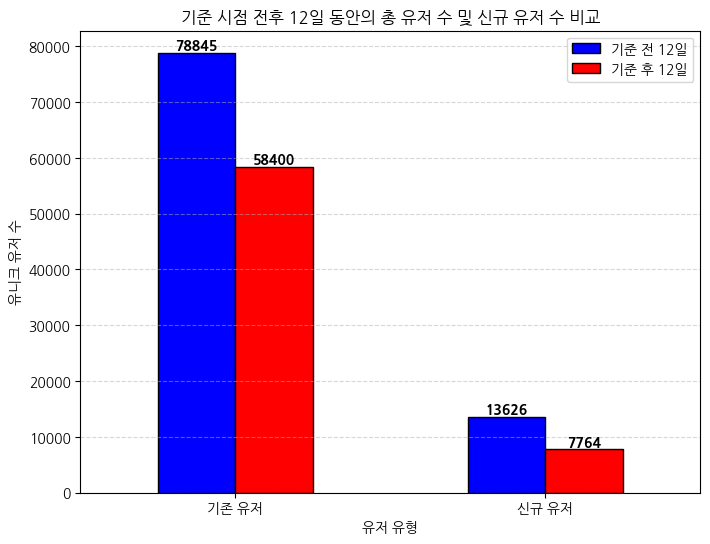

In [154]:
# ✅ 날짜 데이터 변환
df_2308['Asia/Seoul'] = pd.to_datetime(df_2308['Asia/Seoul'])

# ✅ 기준 시점 설정 (9월 17일 14:28:02)
pivot_time = pd.Timestamp("2023-08-23T16:20:00Z")

# ✅ 전후 2주 범위 설정
before_start = pivot_time - pd.Timedelta(days=12)
after_end = pivot_time + pd.Timedelta(days=12)

# ✅ user_properties의 created_at을 추출하여 유저 생성일 구하기
def extract_created_at(user_properties):
    try:
        user_dict = ast.literal_eval(user_properties) if isinstance(user_properties, str) else user_properties
        return pd.Timestamp(user_dict.get('created_at')) if 'created_at' in user_dict else None
    except:
        return None

df_2308['user_created_at'] = df_2308['user_properties'].apply(extract_created_at)

# ✅ 유저가 기준일 이전 생성된 유저인지 이후 생성된 유저인지 분류
df_2308['user_type'] = df_2308['user_created_at'].apply(lambda x: '기존 유저' if x and x < pivot_time else '신규 유저')

# ✅ 전후 2주 데이터 필터링
before_df = df_2308[(df_2308['Asia/Seoul'] >= before_start) & (df_2308['Asia/Seoul'] < pivot_time)]
after_df = df_2308[(df_2308['Asia/Seoul'] >= pivot_time) & (df_2308['Asia/Seoul'] <= after_end)]

# ✅ 기준 시점 전후 12일 동안의 유저 수 집계
before_user_counts = before_df.groupby('user_type')['user_id'].nunique()
after_user_counts = after_df.groupby('user_type')['user_id'].nunique()

# ✅ 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    "기준 전 12일": before_user_counts,
    "기준 후 12일": after_user_counts
}).fillna(0)  # 결측치 채우기

# ✅ 시각화
ax = comparison_df.plot(kind="bar", figsize=(8, 6), color=["blue", "red"], edgecolor="black")

plt.title("기준 시점 전후 12일 동안의 총 유저 수 및 신규 유저 수 비교")
plt.xlabel("유저 유형")
plt.ylabel("유니크 유저 수")
plt.xticks(rotation=0)
plt.legend(["기준 전 12일", "기준 후 12일"])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# ✅ 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color="black", fontweight="bold")

# ✅ 그래프 표시
plt.show()

#### 커뮤니티 기능

In [155]:
# view_community_tap 이벤트 최초 등장 시점 찾기
first_view_community_tap_time = df_2309[df_2309['event_key'] == "view_community_tap"]['Asia/Seoul'].min()
print(f"view_community_tap 최초 등장 시점: {first_view_community_tap_time}")

view_community_tap 최초 등장 시점: 2023-09-17 14:28:02.375000+00:00


In [156]:
# 'name' 키가 있는 경우만 추출하여 카운트
name_counts = df_2309['event_properties'].apply(lambda x: x.get('name') if isinstance(x, dict) and 'name' in x else None).value_counts()

# 데이터프레임으로 변환
df_name_counts = pd.DataFrame({'name': name_counts.index, 'count': name_counts.values})

# 결과 출력
print(df_name_counts)

           name   count
0         자유게시판  143200
1         맞팔&dm  117024
2         무물게시판  108783
3         고민상담소   62309
4         운동게시판   47883
5        중2 게시판   40292
6         #ootd   35811
7          우리학교   30521
8         공부게시판   28529
9        중3 게시판   25528
10       고1 게시판   25430
11        유머게시판   24534
12       고2 게시판   19498
13         우리동네   15827
14        내 게시물    8137
15  내가 댓글 단 게시물    7979
16          소개팅    5100
17       고3 게시판    3316
18        덕질게시판     564
19        사진갤러리     451
20        게임게시판     385
21        플리공유방     380
22         연애고민     363
23        #mbti     347
24        자랑게시판     291
25        반려동물🐶     290
26       내가그린그림     267
27       연애&짝사랑     202
28        애니게시판     199
29      스크랩 게시물      51
30       무물 게시판       7



=== 기준 시점 이전 14일과 이후 14일 기능별 이벤트 발생 횟수 비교 ===
               이전 14일 이벤트 발생 횟수  이후 14일 이벤트 발생 횟수
커뮤니티 기능                       0           1772723
질문 관련 기능                 396052            900466
구매 관련 기능                   5429              9692
얼굴/사진 관련 기능               18496                 0
Imagine 관련 기능             72766                 0
메시지 기능                    11025            115377
친구 초대 기능                  19336             97372


<Figure size 1000x600 with 0 Axes>

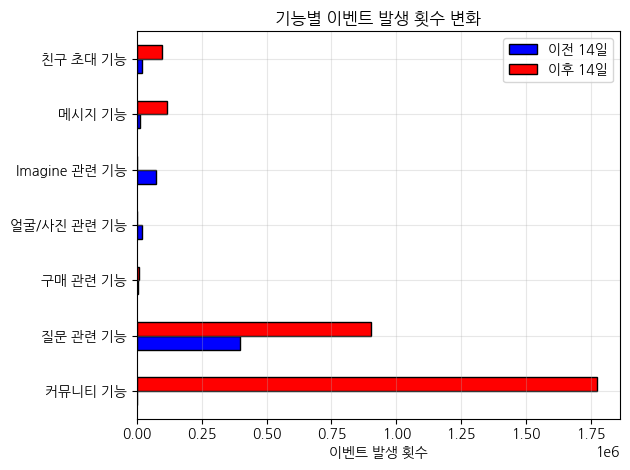

In [157]:
# 기능별 이벤트 그룹 정의
feature_groups = {
    "커뮤니티 기능": [
        "view_community_tap", "click_community_board", "click_community_activity",
        "click_community_post", "click_community_comment_chat", "click_community_post_chat",
        "click_community_post_onoff_alarm", "click_community_write_post", "click_community_activity_post",
        "click_community_activity_comment", "click_community_write_comment", "click_community_activity_notice",
        "click_community_tshirts", "click_community_post_chat_complete", "click_community_comment_chat_complete"
    ],
    "질문 관련 기능": [
        "view_questions_tap", "complete_question_question", "click_question_ask", "click_question_open",
        "click_question_start", "click_random_ask_normal", "click_random_ask_other", "click_random_ask_shuffle",
        "skip_question_question", "click_question_share", "click_question_hint", "click_question_hint_initial",
        "click_question_message"
    ],
    "구매 관련 기능": [
        "click_purchase", "complete_purchase", "view_shop"
    ],
    "얼굴/사진 관련 기능": [
        "view_face_make", "click_face_take_photo", "click_face_select_photo",
        "click_face_start", "view_face_showroom"
    ],
    "Imagine 관련 기능": [
        "view_imagine_make", "view_imagine_tap", "view_imagine_facelist",
        "click_imagine_start", "click_imagine_copy_prompt", "click_imagine_share"
    ],
    "메시지 기능": [
        "view_message_tap", "view_message_detail", "click_timeline_chat_start"
    ],
    "친구 초대 기능": [
        "click_appbar_friend_plus", "click_invite_friend", "click_friend_invite",
        "click_autoadd_contact", "view_friend_plus_tap", "click_search_friend"
    ]
}

df_2309_cleaned = df_2309

# 기준 시점 설정
pivot_time = pd.Timestamp("2023-09-17T14:28:02.375Z")

# 기간 설정 (기준 시점 이전 14일, 이후 14일)
before_start = pivot_time - pd.Timedelta(days=14)
after_end = pivot_time + pd.Timedelta(days=14)

# 날짜 데이터 변환
df_2309_cleaned['Asia/Seoul'] = pd.to_datetime(df_2309_cleaned['Asia/Seoul'])

# 이전 14일과 이후 14일 데이터 분리
before_pivot = df_2309_cleaned[(df_2309_cleaned['Asia/Seoul'] >= before_start) & (df_2309_cleaned['Asia/Seoul'] < pivot_time)]
after_pivot = df_2309_cleaned[(df_2309_cleaned['Asia/Seoul'] >= pivot_time) & (df_2309_cleaned['Asia/Seoul'] < after_end)]

# 기능별 이벤트 발생 횟수 계산 함수
def count_feature_events(df):
    feature_event_counts = {feature: 0 for feature in feature_groups}
    for _, row in df.iterrows():
        event = row['event_key']
        for feature, events in feature_groups.items():
            if event in events:
                feature_event_counts[feature] += 1
                break
    return feature_event_counts

# 이전과 이후 14일의 이벤트 발생 횟수 계산
before_counts = count_feature_events(before_pivot)
after_counts = count_feature_events(after_pivot)

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    "이전 14일 이벤트 발생 횟수": before_counts,
    "이후 14일 이벤트 발생 횟수": after_counts
})

# 결과 출력
print("\n=== 기준 시점 이전 14일과 이후 14일 기능별 이벤트 발생 횟수 비교 ===")
print(comparison_df)

# 시각화 (하나의 플롯만 출력)
plt.figure(figsize=(10, 6))
comparison_df[["이전 14일 이벤트 발생 횟수", "이후 14일 이벤트 발생 횟수"]].plot(kind="barh", color=["blue", "red"], edgecolor="black")
plt.xlabel("이벤트 발생 횟수")
plt.title("기능별 이벤트 발생 횟수 변화")
plt.grid(alpha=0.3)
plt.legend(["이전 14일", "이후 14일"])
plt.tight_layout()
plt.show()

커뮤니티 기능을 포함하여 다른 모든 기능 이용이 증가함

In [158]:
# 커뮤니티 기능 추가된 시점 설정 (9월 17일)
community_feature_release_time = pd.Timestamp("2023-09-17T14:28:02.375Z")
end_time = community_feature_release_time + pd.Timedelta(days=14)  # 이후 14일

# 날짜 데이터 변환
df_2309['Asia/Seoul'] = pd.to_datetime(df_2309['Asia/Seoul'])

# 커뮤니티 기능 추가 이후 14일 동안의 데이터 필터링
filtered_df = df_2309[(df_2309['Asia/Seoul'] >= community_feature_release_time) & (df_2309['Asia/Seoul'] < end_time)]

# 유니크한 유저 ID 개수 계산
num_unique_users = filtered_df['user_id'].nunique()

# 결과 출력
print(f"커뮤니티 기능 추가 이후 14일 동안의 유저 ID 수: {num_unique_users}")

커뮤니티 기능 추가 이후 14일 동안의 유저 ID 수: 129549


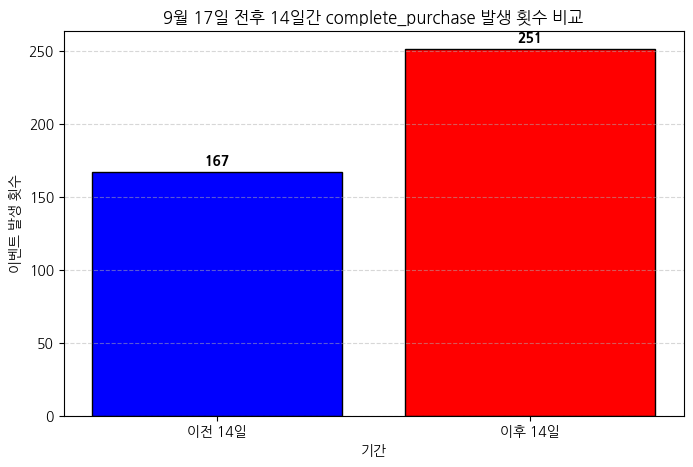

In [159]:
# 날짜 데이터 변환
df_2309_cleaned = df_2309.copy()
df_2309_cleaned['Asia/Seoul'] = pd.to_datetime(df_2309_cleaned['Asia/Seoul'])

# 기준 시점 설정
pivot_time = pd.Timestamp("2023-09-17T00:00:00Z")

# 9월 3일 ~ 9월 17일 (14일 전)
before_start = pivot_time - pd.Timedelta(days=14)
before_pivot = df_2309_cleaned[(df_2309_cleaned['Asia/Seoul'] >= before_start) & 
                                (df_2309_cleaned['Asia/Seoul'] < pivot_time)]

# 9월 17일 ~ 10월 1일 (14일 후)
after_end = pivot_time + pd.Timedelta(days=14)
after_pivot = df_2309_cleaned[(df_2309_cleaned['Asia/Seoul'] >= pivot_time) & 
                               (df_2309_cleaned['Asia/Seoul'] < after_end)]

# "complete_purchase" 이벤트 카운트
before_count = before_pivot[before_pivot['event_key'] == 'complete_purchase'].shape[0]
after_count = after_pivot[after_pivot['event_key'] == 'complete_purchase'].shape[0]

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    "기간": ["이전 14일", "이후 14일"],
    "complete_purchase 횟수": [before_count, after_count]
})

# 📊 시각화
plt.figure(figsize=(8, 5))
bars = plt.bar(comparison_df["기간"], comparison_df["complete_purchase 횟수"], color=["blue", "red"], edgecolor="black")

plt.title("9월 17일 전후 14일간 complete_purchase 발생 횟수 비교")
plt.xlabel("기간")
plt.ylabel("이벤트 발생 횟수")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(comparison_df["complete_purchase 횟수"]) * 0.02, 
             str(height), ha='center', fontsize=10, fontweight="bold")

# 그래프 표시
plt.show()

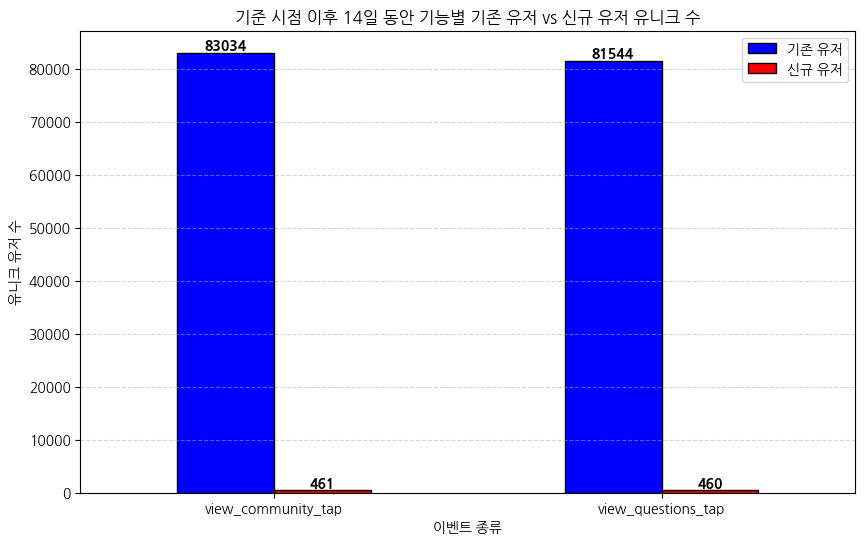

In [160]:
# 날짜 데이터 변환
df_2309_cleaned = df_2309.copy()
df_2309_cleaned['Asia/Seoul'] = pd.to_datetime(df_2309_cleaned['Asia/Seoul'])

# 기준 시점 설정 (예: 9월 17일 14:28:02)
pivot_time = pd.Timestamp("2023-09-17T14:28:02.375Z")
end_time = pivot_time + pd.Timedelta(days=14)  # 기준 시점 이후 14일까지만

# user_properties의 created_at을 추출하여 유저 생성일 구하기
def extract_created_at(user_properties):
    try:
        user_dict = ast.literal_eval(user_properties) if isinstance(user_properties, str) else user_properties
        return pd.Timestamp(user_dict.get('created_at')) if 'created_at' in user_dict else None
    except:
        return None

df_2309_cleaned['user_created_at'] = df_2309_cleaned['user_properties'].apply(extract_created_at)

# 유저가 기준일 이전 생성된 유저인지 이후 생성된 유저인지 분류
df_2309_cleaned['user_type'] = df_2309_cleaned['user_created_at'].apply(lambda x: '기존 유저' if x and x < pivot_time else '신규 유저')

# 기준 시점 이후 14일 동안의 데이터 필터링
filtered_df = df_2309_cleaned[(df_2309_cleaned['Asia/Seoul'] > pivot_time) & (df_2309_cleaned['Asia/Seoul'] <= end_time)]

# 분석할 이벤트 유형 정의
event_types = ["view_community_tap", "view_questions_tap"]

# 필터링: 선택한 이벤트만
filtered_df = filtered_df[filtered_df['event_key'].isin(event_types)]

# 이벤트별 기존 유저와 신규 유저 수 계산
user_counts = filtered_df.groupby(['event_key', 'user_type'])['user_id'].nunique().unstack().fillna(0)

# 📊 시각화
ax = user_counts.plot(kind="bar", figsize=(10, 6), color=["blue", "red"], edgecolor="black")

plt.title("기준 시점 이후 14일 동안 기능별 기존 유저 vs 신규 유저 유니크 수")
plt.xlabel("이벤트 종류")
plt.ylabel("유니크 유저 수")
plt.xticks(rotation=0)
plt.legend(["기존 유저", "신규 유저"])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color="black", fontweight="bold")

# 그래프 표시
plt.show()

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\3651904302.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['event_group'] = filtered_df['event_key'].apply(lambda x: '커뮤니티 활동' if x in group_A_events else ('질문 응답' if x in group_B_events else None))


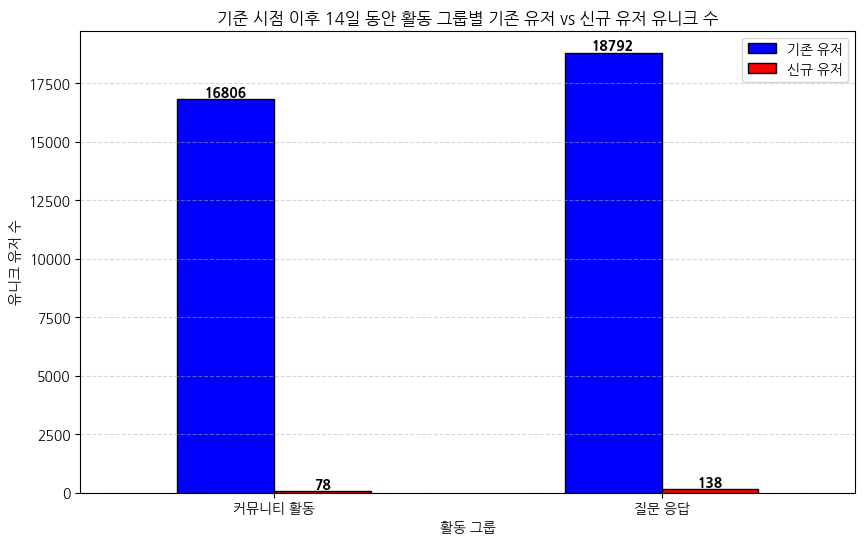

In [161]:
# 날짜 데이터 변환
df_2309_cleaned = df_2309.copy()
df_2309_cleaned['Asia/Seoul'] = pd.to_datetime(df_2309_cleaned['Asia/Seoul'])

# 기준 시점 설정 (예: 9월 17일 14:28:02)
pivot_time = pd.Timestamp("2023-09-17T14:28:02.375Z")
end_time = pivot_time + pd.Timedelta(days=14)  # 기준 시점 이후 14일까지만

# user_properties의 created_at을 추출하여 유저 생성일 구하기
def extract_created_at(user_properties):
    try:
        user_dict = ast.literal_eval(user_properties) if isinstance(user_properties, str) else user_properties
        return pd.Timestamp(user_dict.get('created_at')) if 'created_at' in user_dict else None
    except:
        return None

df_2309_cleaned['user_created_at'] = df_2309_cleaned['user_properties'].apply(extract_created_at)

# 유저가 기준일 이전 생성된 유저인지 이후 생성된 유저인지 분류
df_2309_cleaned['user_type'] = df_2309_cleaned['user_created_at'].apply(lambda x: '기존 유저' if x and x < pivot_time else '신규 유저')

# 기준 시점 이후 14일 동안의 데이터 필터링
filtered_df = df_2309_cleaned[(df_2309_cleaned['Asia/Seoul'] > pivot_time) & (df_2309_cleaned['Asia/Seoul'] <= end_time)]

# ✅ 그룹별 이벤트 정의
group_A_events = ["click_community_write_comment", "click_community_post"]
group_B_events = ["complete_question_question"]

# 그룹별 데이터 필터링
filtered_df['event_group'] = filtered_df['event_key'].apply(lambda x: '커뮤니티 활동' if x in group_A_events else ('질문 응답' if x in group_B_events else None))
filtered_df = filtered_df.dropna(subset=['event_group'])  # 필요한 이벤트만 남김

# 이벤트별 기존 유저와 신규 유저 수 계산
user_counts = filtered_df.groupby(['event_group', 'user_type'])['user_id'].nunique().unstack().fillna(0)

# ✅ "커뮤니티 활동"을 왼쪽에 배치
user_counts = user_counts.reindex(["커뮤니티 활동", "질문 응답"])

# 📊 시각화
ax = user_counts.plot(kind="bar", figsize=(10, 6), color=["blue", "red"], edgecolor="black")

plt.title("기준 시점 이후 14일 동안 활동 그룹별 기존 유저 vs 신규 유저 유니크 수")
plt.xlabel("활동 그룹")
plt.ylabel("유니크 유저 수")
plt.xticks(rotation=0)
plt.legend(["기존 유저", "신규 유저"])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color="black", fontweight="bold")

# 그래프 표시
plt.show()


=== 일별 커뮤니티 관련 기능 이벤트 발생 횟수 (최초 발생: 2023-09-13) ===
Asia/Seoul
2023-09-13        23
2023-09-15       217
2023-09-16       204
2023-09-17     15163
2023-09-18     91699
2023-09-19    143161
2023-09-20     76577
2023-09-21     68140
2023-09-22     52433
2023-09-23    244092
2023-09-24    352240
2023-09-25    143709
2023-09-26    164222
2023-09-27    120618
2023-09-28    161859
2023-09-29    131705
2023-09-30    152465
2023-10-01    150161
2023-10-02    152443
2023-10-03    181247
2023-10-04     98968
2023-10-05     90871
2023-10-06     80173
2023-10-07     93268
2023-10-08     90391
2023-10-09    186836
2023-10-10     93003
2023-10-11     72631
2023-10-12     34878
2023-10-13     35588
2023-10-14     47257
2023-10-15     56820
2023-10-16     39998
2023-10-17     26266
2023-10-18     27375
2023-10-19     35074
2023-10-20     26261
2023-10-21     47710
2023-10-22     46105
2023-10-23     30042
2023-10-24     26042
2023-10-25     23386
2023-10-26     24076
2023-10-27     18866
2023-10-28  

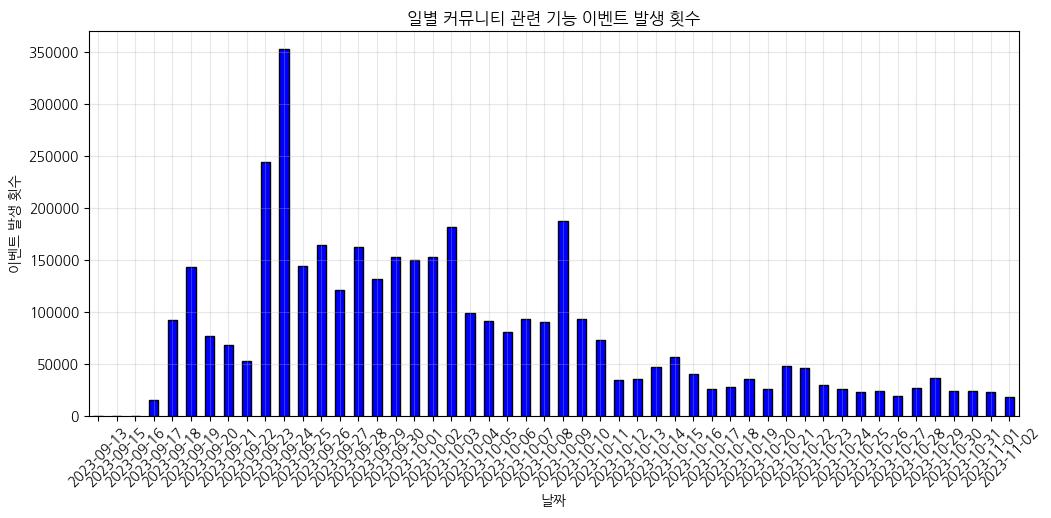

In [162]:
# 커뮤니티 관련 기능 이벤트 목록
community_events = [
    "view_community_tap", "click_community_board", "click_community_activity",
    "click_community_post", "click_community_comment_chat", "click_community_post_chat",
    "click_community_post_onoff_alarm", "click_community_write_post", "click_community_activity_post",
    "click_community_activity_comment", "click_community_write_comment", "click_community_activity_notice",
    "click_community_tshirts", "click_community_post_chat_complete", "click_community_comment_chat_complete"
]

# 날짜 데이터 변환
df_230810['Asia/Seoul'] = pd.to_datetime(df_230810['Asia/Seoul'])

# 커뮤니티 기능 이벤트만 필터링
community_df = df_230810[df_230810['event_key'].isin(community_events)]

# 커뮤니티 관련 기능 이벤트 최초 발생 시점 찾기
first_community_event_time = community_df['Asia/Seoul'].min()

# 해당 시점 이후 데이터만 사용
community_df = community_df[community_df['Asia/Seoul'] >= first_community_event_time]

# 일별 이벤트 발생 횟수 집계
daily_event_counts = community_df.groupby(community_df['Asia/Seoul'].dt.date)['event_key'].count()

# 결과 출력
print(f"\n=== 일별 커뮤니티 관련 기능 이벤트 발생 횟수 (최초 발생: {first_community_event_time.date()}) ===")
print(daily_event_counts)

# 시각화
plt.figure(figsize=(12, 5))
daily_event_counts.plot(kind="bar", color="blue", edgecolor="black")
plt.xlabel("날짜")
plt.ylabel("이벤트 발생 횟수")
plt.title("일별 커뮤니티 관련 기능 이벤트 발생 횟수")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

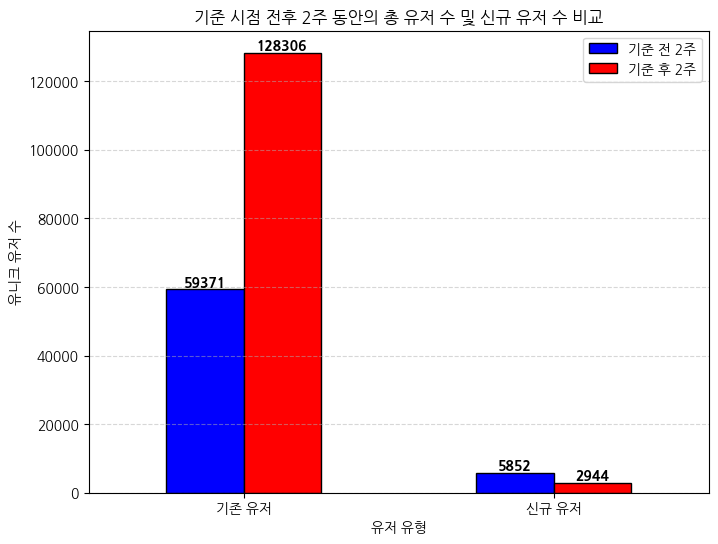

In [163]:
# ✅ 날짜 데이터 변환
df_2309_cleaned = df_2309.copy()
df_2309_cleaned['Asia/Seoul'] = pd.to_datetime(df_2309_cleaned['Asia/Seoul'])

# ✅ 기준 시점 설정 (9월 17일 14:28:02)
pivot_time = pd.Timestamp("2023-09-17T14:28:02.375Z")

# ✅ 전후 2주 범위 설정
before_start = pivot_time - pd.Timedelta(days=14)
after_end = pivot_time + pd.Timedelta(days=14)

# ✅ user_properties의 created_at을 추출하여 유저 생성일 구하기
def extract_created_at(user_properties):
    try:
        user_dict = ast.literal_eval(user_properties) if isinstance(user_properties, str) else user_properties
        return pd.Timestamp(user_dict.get('created_at')) if 'created_at' in user_dict else None
    except:
        return None

df_2309_cleaned['user_created_at'] = df_2309_cleaned['user_properties'].apply(extract_created_at)

# ✅ 유저가 기준일 이전 생성된 유저인지 이후 생성된 유저인지 분류
df_2309_cleaned['user_type'] = df_2309_cleaned['user_created_at'].apply(lambda x: '기존 유저' if x and x < pivot_time else '신규 유저')

# ✅ 전후 2주 데이터 필터링
before_df = df_2309_cleaned[(df_2309_cleaned['Asia/Seoul'] >= before_start) & (df_2309_cleaned['Asia/Seoul'] < pivot_time)]
after_df = df_2309_cleaned[(df_2309_cleaned['Asia/Seoul'] >= pivot_time) & (df_2309_cleaned['Asia/Seoul'] <= after_end)]

# ✅ 기준 시점 전후 2주 동안의 유저 수 집계
before_user_counts = before_df.groupby('user_type')['user_id'].nunique()
after_user_counts = after_df.groupby('user_type')['user_id'].nunique()

# ✅ 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    "기준 전 2주": before_user_counts,
    "기준 후 2주": after_user_counts
}).fillna(0)  # 결측치 채우기

# ✅ 시각화
ax = comparison_df.plot(kind="bar", figsize=(8, 6), color=["blue", "red"], edgecolor="black")

plt.title("기준 시점 전후 2주 동안의 총 유저 수 및 신규 유저 수 비교")
plt.xlabel("유저 유형")
plt.ylabel("유니크 유저 수")
plt.xticks(rotation=0)
plt.legend(["기준 전 2주", "기준 후 2주"])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# ✅ 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color="black", fontweight="bold")

# ✅ 그래프 표시
plt.show()

### 목적성 분석

##### 친밀감 목적

In [164]:
df_vote = df_vote[(df_vote["created_at"].dt.year == 2023) & (df_vote["created_at"].dt.month == 5)]

In [165]:
# df_user에서 user_id와 chosen_user_id의 성별 정보 가져오기
df_vote = df_vote.merge(
    df_user[['id', 'gender']], left_on='user_id', right_on='id', how='left'
).rename(columns={'gender': 'user_gender'})

df_vote = df_vote.merge(
    df_user[['id', 'gender']], left_on='chosen_user_id', right_on='id', how='left'
).rename(columns={'gender': 'chosen_user_gender'})

# 중복된 'id' 컬럼이 있다면 삭제
df_vote = df_vote.drop(columns=['id_y', 'id', ], errors='ignore')

df_vote.rename(columns={'id_x': 'id'})

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,date,user_gender,chosen_user_gender
0,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0,2023-05-01,M,F
1,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0,2023-05-01,M,M
2,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0,2023-05-01,M,F
3,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0,2023-05-01,M,F
4,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0,2023-05-01,M,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104676,138130739,C,2023-05-31 23:52:45,928814,586,1527564,175555710,0,N,2023-05-31 23:52:45,0,0,2023-05-31,F,F
1104677,138134779,C,2023-05-31 23:59:46,1122686,542,1430036,161675925,0,N,2023-05-31 23:59:46,0,0,2023-05-31,M,M
1104678,138134796,C,2023-05-31 23:59:47,1527600,1289,1528640,169411942,1,N,2023-05-31 23:59:47,0,0,2023-05-31,M,M
1104679,138134871,C,2023-05-31 23:59:56,1424343,1234,1528640,169411945,0,N,2023-05-31 23:59:56,0,0,2023-05-31,M,M


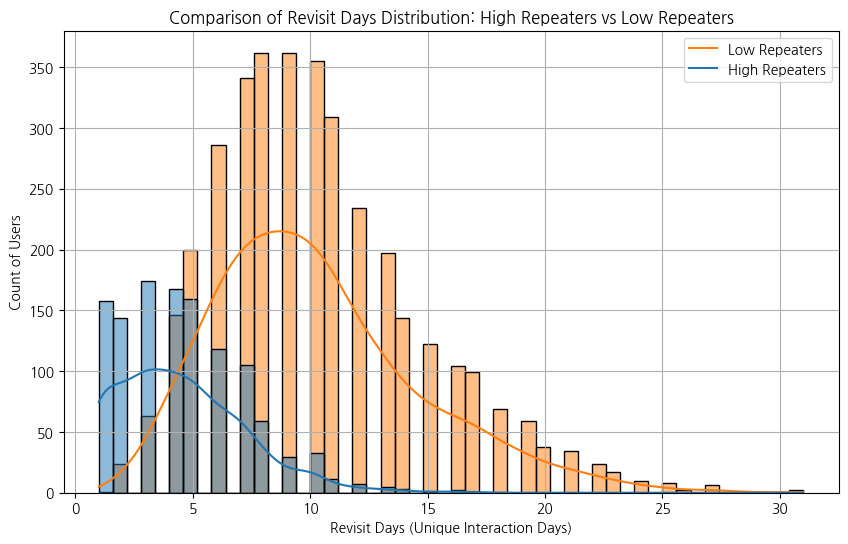

In [166]:
# 동일한 상대에게 10번 이상 반복적으로 질문한 사람 찾기
repeat_questions = df_vote.groupby(["user_id", "chosen_user_id"]).size().reset_index(name="question_count")

# 동일한 유저에게 10번 이상 질문한 경우 필터링
high_repeat_users = repeat_questions[repeat_questions["question_count"] >= 10]["user_id"].unique()

# 전체 유저의 재방문 일수 계산 (유니크한 방문 날짜 수)
df_vote["interaction_date"] = pd.to_datetime(df_vote["created_at"]).dt.date  # 날짜 변환
user_revisit_days = df_vote.groupby("user_id")["interaction_date"].nunique().reset_index()
user_revisit_days.rename(columns={"interaction_date": "revisit_days"}, inplace=True)

# 동일 유저에게 10번 이상 질문한 유저와 그렇지 않은 유저 구분
user_revisit_days["is_high_repeater"] = user_revisit_days["user_id"].isin(high_repeat_users)

# 재방문 일수 분포 비교를 위한 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(data=user_revisit_days, x="revisit_days", hue="is_high_repeater", bins=50, kde=True) 
plt.xlabel("Revisit Days (Unique Interaction Days)")
plt.ylabel("Count of Users")
plt.title("Comparison of Revisit Days Distribution: High Repeaters vs Low Repeaters")
plt.legend(["Low Repeaters", "High Repeaters"])
plt.grid(True)

# 결과 출력
plt.show()

In [167]:
# 10번 이상 동일 유저에게 질문한 유저 그룹과 그렇지 않은 유저 그룹
high_repeat_revisit_days = user_revisit_days[user_revisit_days["is_high_repeater"]]["revisit_days"]
low_repeat_revisit_days = user_revisit_days[~user_revisit_days["is_high_repeater"]]["revisit_days"]

# 평균 및 표준편차 확인
mean_high = high_repeat_revisit_days.mean()
std_high = high_repeat_revisit_days.std()

mean_low = low_repeat_revisit_days.mean()
std_low = low_repeat_revisit_days.std()

# 독립표본 t-검정 수행 (두 그룹 간 평균 차이 검증)
t_stat, p_value = ttest_ind(high_repeat_revisit_days, low_repeat_revisit_days, equal_var=False, nan_policy='omit')

# 결과 출력
{
    "mean_high_repeaters": mean_high,
    "std_high_repeaters": std_high,
    "mean_low_repeaters": mean_low,
    "std_low_repeaters": std_low,
    "t_statistic": t_stat,
    "p_value": p_value
}

{'mean_high_repeaters': np.float64(10.253867403314917),
 'std_high_repeaters': np.float64(4.4653248130059024),
 'mean_low_repeaters': np.float64(4.517417162276975),
 'std_low_repeaters': np.float64(2.697928934231031),
 't_statistic': np.float64(53.051051055818796),
 'p_value': np.float64(0.0)}

#### 사랑 목적

##### 라벨링 프로세스

In [168]:
# 질문 라벨링
# 1차 라벨링

df_question_f = df_question[df_question['question_text'] != 'vote']

# 사랑 관련 키워드 정의
romantic_keywords = [
    "사랑", "고백", "썸", "데이트", "짝사랑", "연인", "여자친구", "남자친구",
    "호감", "마음", "감정", "설렘", "연락", "커플", "썸탈", "이성", "남사친", 
    "여사친", "짝남", "짝녀", "이상형", "꿈", "전화", "좋아", "dm", "DM", "사귀", "연애"
]

def classify_category(text):
    """텍스트에 사랑 관련 키워드가 포함되면 '사랑', 없으면 '기타'로 분류"""
    
    if any(keyword in text for keyword in romantic_keywords):
        return "사랑"
    return "기타"

# 데이터프레임 로드 (df_question_f 사용)
df = df_question_f.copy()

# 카테고리 분류 적용
df["category"] = df["question_text"].apply(classify_category)

# 결과 통계 출력
print("\n📊 분류 결과 통계:")
print(df["category"].value_counts())

print("\n📈 분류 결과 비율:")
print(df["category"].value_counts(normalize=True).round(3))

# 결과 저장
df.to_csv("nogada.csv", index=False)

print("\n✅ 분류 완료! 'classified_questions.csv' 파일을 확인하세요.")


📊 분류 결과 통계:
category
기타    4483
사랑     486
Name: count, dtype: int64

📈 분류 결과 비율:
category
기타    0.902
사랑    0.098
Name: proportion, dtype: float64

✅ 분류 완료! 'classified_questions.csv' 파일을 확인하세요.


**1차 라벨링**

위 코드로 먼저 질문에 "사랑", "고백", "썸", "데이트", "짝사랑", "연인", "여자친구", "남자친구", "호감", "마음", "감정", "설렘", "연락", "커플", "썸탈", "이성", "남사친", "여사친", "짝남", "짝녀", "이상형", "꿈", "전화", "좋아", "dm", "DM", "사귀", "연애” 가 포함된 것을 사랑으로 1차 분류


**2차 라벨링**

직접 파일을 보며 사랑으로 분류된 질문들에서 아닌 것 같다고 판단된 질문을 기타로 넘기고, 기타에서 전체적으로 보며 다시 사랑으로 분류할 수 있는 질문들이 있는지 판단

- 질문을 받고 좋아하는(호감이 있는) 이성이 4명 중에 있다는 가정

- 단둘이 무언갈 하는 경우 호감의 표시라고 판단

- 외모와 관련된 칭찬 또한 호감의 표시라고 판단

- 이외 다른 유형의 질문들은 다수결로 결정 (5명이서 토의를 하고 다수결).



**3차 라벨링**

처음부터 마지막까지 훑어보며 놓친 것과 애매한 것은 다시 재투표

In [169]:
df_love = pd.read_csv(f"data\love.csv")

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1963033834.py:1: SyntaxWarning: invalid escape sequence '\l'
  df_love = pd.read_csv(f"data\love.csv")


In [170]:
df_love.head()

,id,question_text,created_at,category
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,기타
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53,기타
2,101,미래의 틱톡커는?,2023-03-31 15:22:54,기타
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54,기타
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55,사랑


In [171]:
df_love.describe(include='all')

,id,question_text,created_at,category
count,4969.000000,4969,4969,4969
unique,NaN,3899,644,2
top,NaN,인생 2회차인 것 같은 사람은?,2023-06-06 6:15:42,기타
freq,NaN,3,81,3871
mean,2620.815657,NaN,NaN,NaN
std,1452.559545,NaN,NaN,NaN
min,99.000000,NaN,NaN,NaN
25%,1366.000000,NaN,NaN,NaN
50%,2623.000000,NaN,NaN,NaN
75%,3876.000000,NaN,NaN,NaN


In [172]:
# df_vote에 category 컬럼 추가하기 위해 love_or_etc와 병합
df_vote = df_vote.merge(
    df_love[['id', 'category']], left_on='question_id', right_on='id', how='left'
).rename(columns={'category': 'question_category'}).drop(columns=['id'], errors='ignore')

# 결과 확인
df_vote.head()

,id_x,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,date,user_gender,chosen_user_gender,interaction_date,question_category
0,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0,2023-05-01,M,F,2023-05-01,사랑
1,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0,2023-05-01,M,M,2023-05-01,기타
2,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0,2023-05-01,M,F,2023-05-01,기타
3,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0,2023-05-01,M,F,2023-05-01,기타
4,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0,2023-05-01,M,F,2023-05-01,기타


In [173]:
df_vote = df_vote.rename(columns={'id_x': 'id'})

In [174]:
# is_opposite_gender 컬럼 추가 (user_gender와 chosen_user_gender 비교)
df_vote["is_opposite_gender"] = df_vote["user_gender"] != df_vote["chosen_user_gender"]

# 결과 확인
df_vote.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,date,user_gender,chosen_user_gender,interaction_date,question_category,is_opposite_gender
0,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0,2023-05-01,M,F,2023-05-01,사랑,True
1,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0,2023-05-01,M,M,2023-05-01,기타,False
2,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0,2023-05-01,M,F,2023-05-01,기타,True
3,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0,2023-05-01,M,F,2023-05-01,기타,True
4,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0,2023-05-01,M,F,2023-05-01,기타,True


##### 사랑 질문 반복 투표와 재방문 일수 분석

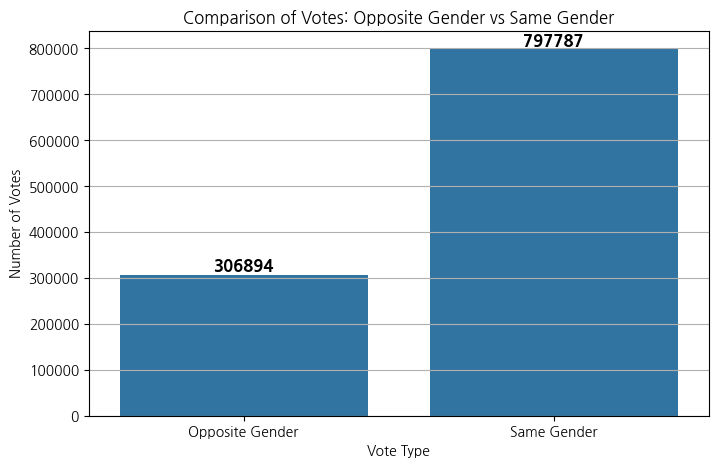

In [175]:
# 이성 vs 동성 투표 수 계산
opposite_gender_votes = df_vote[df_vote["is_opposite_gender"]].shape[0]
same_gender_votes = df_vote[~df_vote["is_opposite_gender"]].shape[0]

# 데이터 준비
vote_counts = pd.DataFrame({
    "Category": ["Opposite Gender", "Same Gender"],
    "Vote Count": [opposite_gender_votes, same_gender_votes]
})


# 시각화 (막대 위에 숫자 표시)
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=vote_counts, x="Category", y="Vote Count")

# 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# 그래프 스타일 설정
plt.xlabel("Vote Type")
plt.ylabel("Number of Votes")
plt.title("Comparison of Votes: Opposite Gender vs Same Gender")
plt.grid(axis="y")

# 결과 출력
plt.show()

In [176]:
# 동일한 유저에게 10번 이상 반복 투표한 유저 찾기
repeat_questions = df_vote.groupby(["user_id", "chosen_user_id"]).size().reset_index(name="question_count")

# 10번 이상 동일 유저에게 질문한 경우 필터링
high_repeat_users = repeat_questions[repeat_questions["question_count"] >= 10]["user_id"].unique()

# 동일한 유저에게 10번 이상 질문한 유저들의 투표 데이터 필터링
high_repeat_data = df_vote[df_vote["user_id"].isin(high_repeat_users)]

# 동일한 동성 유저에게 한 투표 수 계산
same_gender_votes = high_repeat_data[~high_repeat_data["is_opposite_gender"]].groupby("user_id").size().reset_index(name="same_gender_votes")

# 동일한 이성 유저에게 한 투표 수 계산
opposite_gender_votes = high_repeat_data[high_repeat_data["is_opposite_gender"]].groupby("user_id").size().reset_index(name="opposite_gender_votes")

# 유저별 전체 투표 수 계산
user_total_votes = high_repeat_data.groupby("user_id").size().reset_index(name="total_votes")

# 전체 유저의 재방문 일수 계산 (유니크한 방문 날짜 수)
df_vote["interaction_date"] = pd.to_datetime(df_vote["interaction_date"]).dt.date  # 날짜 변환
user_revisit_days = df_vote.groupby("user_id")["interaction_date"].nunique().reset_index()
user_revisit_days.rename(columns={"interaction_date": "revisit_days"}, inplace=True)

# 유저별 투표 유형 및 방문일수 데이터 병합
high_repeat_users_data = user_total_votes.merge(same_gender_votes, on="user_id", how="left").fillna(0)
high_repeat_users_data = high_repeat_users_data.merge(opposite_gender_votes, on="user_id", how="left").fillna(0)
high_repeat_users_data = high_repeat_users_data.merge(user_revisit_days, on="user_id", how="left").fillna(0)

# 최종 결과 확인
high_repeat_users_data.head()

,user_id,total_votes,same_gender_votes,opposite_gender_votes,revisit_days
0,838466,127,105.0,22.0,6
1,839357,140,35.0,105.0,7
2,840293,170,108.0,62.0,7
3,840473,191,113.0,78.0,14
4,840685,562,294.0,268.0,19


In [177]:
# 사랑 카테고리 질문만 필터링
love_category_data = high_repeat_data[high_repeat_data["question_category"] == "사랑"]

# 동일한 이성 유저에게 한 사랑 질문 수 계산
opposite_gender_love_votes = love_category_data[love_category_data["is_opposite_gender"]].groupby("user_id").size().reset_index(name="opposite_gender_love_votes")

# 유저별 전체 사랑 질문 수 계산
user_love_votes = love_category_data.groupby("user_id").size().reset_index(name="total_love_votes")

# 전체 유저의 재방문 일수 계산 (유니크한 방문 날짜 수)
df_vote["interaction_date"] = pd.to_datetime(df_vote["interaction_date"]).dt.date  # 날짜 변환
user_revisit_days = df_vote.groupby("user_id")["interaction_date"].nunique().reset_index()
user_revisit_days.rename(columns={"interaction_date": "revisit_days"}, inplace=True)

# 유저별 투표 유형 및 방문일수 데이터 병합
high_repeat_users_data = user_love_votes.merge(opposite_gender_love_votes, on="user_id", how="left").fillna(0)
high_repeat_users_data = high_repeat_users_data.merge(user_revisit_days, on="user_id", how="left").fillna(0)

# 동일한 이성 유저에게 사랑 질문을 반복 투표한 유저 찾기
opposite_love_repeat_users = high_repeat_users_data[high_repeat_users_data["opposite_gender_love_votes"] >= 10]

# 동일한 이성 유저에게 사랑 질문을 반복 투표하지 않은 유저 찾기
non_opposite_love_repeat_users = high_repeat_users_data[high_repeat_users_data["opposite_gender_love_votes"] < 2]

# 평균 및 유저 수 계산
stats_data = {
    "opposite_love_repeat_user_count": len(opposite_love_repeat_users),
    "non_opposite_love_repeat_user_count": len(non_opposite_love_repeat_users),
    "mean_total_love_votes_opposite": opposite_love_repeat_users["total_love_votes"].mean(),
    "mean_total_love_votes_non_opposite": non_opposite_love_repeat_users["total_love_votes"].mean(),
    "mean_revisit_days_opposite": opposite_love_repeat_users["revisit_days"].mean(),
    "mean_revisit_days_non_opposite": non_opposite_love_repeat_users["revisit_days"].mean(),
}

# 통계적 검증 수행 (각 그룹이 최소한 2명 이상 있어야 검정 가능)

if len(opposite_love_repeat_users) > 1 and len(non_opposite_love_repeat_users) > 1:
    t_stat_love_votes, p_value_love_votes = stats.ttest_ind(
        opposite_love_repeat_users["total_love_votes"], non_opposite_love_repeat_users["total_love_votes"], equal_var=False, nan_policy='omit'
    )

    t_stat_revisit_days, p_value_revisit_days = stats.ttest_ind(
        opposite_love_repeat_users["revisit_days"], non_opposite_love_repeat_users["revisit_days"], equal_var=False, nan_policy='omit'
    )

    stats_data["t_stat_love_votes"] = t_stat_love_votes
    stats_data["p_value_love_votes"] = p_value_love_votes
    stats_data["t_stat_revisit_days"] = t_stat_revisit_days
    stats_data["p_value_revisit_days"] = p_value_revisit_days

# 결과 출력
stats_data

{'opposite_love_repeat_user_count': 1424,
 'non_opposite_love_repeat_user_count': 790,
 'mean_total_love_votes_opposite': np.float64(92.34058988764045),
 'mean_total_love_votes_non_opposite': np.float64(39.9746835443038),
 'mean_revisit_days_opposite': np.float64(11.819522471910112),
 'mean_revisit_days_non_opposite': np.float64(8.659493670886077),
 't_stat_love_votes': np.float64(28.973915297809015),
 'p_value_love_votes': np.float64(1.0646877770525554e-156),
 't_stat_revisit_days': np.float64(16.83190180459756),
 'p_value_revisit_days': np.float64(2.35787999006684e-59)}

##### 사랑(연애/썸) 목적성 있는 그룹과 아닌 그룹의 이탈률 확인 및 통계 검정

In [178]:
# # vote에 카테고리, 질문 내용 추가
df_vote_all = df_vote.merge(df_love[['id', 'question_text','category']], left_on='question_id', right_on='id', how='inner')
# df_vote_all.drop(columns=['id'], inplace=True)
df_vote_all.head()

,id_x,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,...,opened_times,date,user_gender,chosen_user_gender,interaction_date,question_category,is_opposite_gender,id_y,question_text,category
0,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,...,0,2023-05-01,M,F,2023-05-01,사랑,True,202,같이 밥을 먹고싶은 사람은?,사랑
1,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,...,0,2023-05-01,M,M,2023-05-01,기타,False,116,대학가서 용될것 같은 사람은?,기타
2,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,...,0,2023-05-01,M,F,2023-05-01,기타,True,199,무계획 여행을 떠났을 때 가장 재밌을 것 같은 사람은?,기타
3,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,...,0,2023-05-01,M,F,2023-05-01,기타,True,238,봐도 봐도 신기한 사람은?,기타
4,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,...,0,2023-05-01,M,F,2023-05-01,기타,True,190,팔씨름을 제일 잘할것 같은 사람은?,기타


In [179]:
# 사랑 질문만 필터링
df_vote_love = df_vote_all[df_vote_all["category"] == "사랑"]

# 유저별 사랑 질문 투표 횟수 (전체)
love_vote_counts = df_vote_love["user_id"].value_counts().reset_index()
love_vote_counts.columns = ["user_id", "total_love_votes"]

filtered_users_10 = love_vote_counts[love_vote_counts["total_love_votes"] >= 10]
print(f"사랑 질문을 10개 이상 받은 유저 수: {len(filtered_users_10)}")

사랑 질문을 10개 이상 받은 유저 수: 4153


In [180]:
# 사랑 비율 구하기
filtered_user_ids_10 = filtered_users_10["user_id"].tolist()
df_filtered_vote_love = df_vote_love[df_vote_love["user_id"].isin(filtered_user_ids_10)]
df_filtered_vote_10 = df_vote_all[df_vote_all['user_id'].isin(filtered_user_ids_10)]

# 유저별 사랑 질문 투표 횟수 (전체)
love_vote_f_counts = df_filtered_vote_love["user_id"].value_counts().reset_index()
love_vote_f_counts.columns = ["user_id", "total_love_votes"]

# 유저별 이성에게 한 사랑 질문 투표 횟수
df_love_opposite = df_filtered_vote_love[df_filtered_vote_love["user_gender"] != df_filtered_vote_love["chosen_user_gender"]]
love_opposite_counts = df_love_opposite["user_id"].value_counts().reset_index()
love_opposite_counts.columns = ["user_id", "opposite_love_votes"]

df_love_ratio = love_vote_f_counts.merge(love_opposite_counts, on="user_id", how="left").fillna(0)

# 사랑 비율 계산 (이성에게 투표한 횟수 / 전체 사랑 질문 투표 횟수)
df_love_ratio["love_ratio"] = df_love_ratio["opposite_love_votes"] / df_love_ratio["total_love_votes"]

# 결과 출력
print(df_love_ratio)


      user_id  total_love_votes  opposite_love_votes  love_ratio
0      876509               399                 85.0    0.213033
1     1213990               397                119.0    0.299748
2     1206529               364                 60.0    0.164835
3     1159163               346                 32.0    0.092486
4      849103               325                 13.0    0.040000
...       ...               ...                  ...         ...
4148  1046108                10                  1.0    0.100000
4149   885084                10                  0.0    0.000000
4150  1238477                10                  0.0    0.000000
4151  1498172                10                  0.0    0.000000
4152  1472404                10                  2.0    0.200000

[4153 rows x 4 columns]


In [181]:
# 동일 유저(이성)에게 투표한 횟수 계산
vote_counts = df_love_opposite.groupby(['user_id', 'chosen_user_id']).size().reset_index(name='vote_count')

# 3 번 이상 투표한 경우만 필터링
filtered_users = vote_counts[vote_counts['vote_count'] >= 3]
filtered_user_ids_3 = filtered_users["user_id"].tolist()

# 사랑 질문 10개이상인 유저 투표기록만 가져오기
df_filtered_vote_love_two_all = df_filtered_vote_10.copy()
df_filtered_vote_love_two_all['true_love'] = df_filtered_vote_love_two_all['user_id'].isin(filtered_user_ids_3).astype(int)

# fm 컬럼 추가 (0 = 동성, 1 = 이성)
df_filtered_vote_love_two_all["fm"] = (df_filtered_vote_love_two_all["user_gender"] != df_filtered_vote_love_two_all["chosen_user_gender"]).astype(int)

# answer_status 변환: 'N'이면 0, 그 외는 1
df_filtered_vote_love_two_all['answer_status_score'] = df_filtered_vote_love_two_all['answer_status'].map(lambda x: 0 if x == 'N' else 1)

# status 변환: 'I'이면 1, 그 외는 0
df_filtered_vote_love_two_all['status_score'] = df_filtered_vote_love_two_all['status'].map(lambda x: 1 if x == 'I' else 0)

In [182]:
df_filtered_vote_love_two_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1079844 entries, 0 to 1096018
Data columns (total 25 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id_x                 1079844 non-null  int64         
 1   status               1079844 non-null  object        
 2   created_at           1079844 non-null  datetime64[ns]
 3   chosen_user_id       1079844 non-null  int64         
 4   question_id          1079844 non-null  int64         
 5   user_id              1079844 non-null  int64         
 6   question_piece_id    1079844 non-null  int64         
 7   has_read             1079844 non-null  int64         
 8   answer_status        1079844 non-null  object        
 9   answer_updated_at    1079844 non-null  datetime64[ns]
 10  report_count         1079844 non-null  int64         
 11  opened_times         1079844 non-null  int64         
 12  date                 1079844 non-null  object        
 13  us

In [183]:
# 'true_love'가 1인 그룹과 아닌 그룹으로 필터링
grouped = df_filtered_vote_love_two_all.groupby('true_love')['user_id'].nunique()

# 'true_love'가 1인 그룹과 아닌 그룹의 유저 수 차이 계산
user_difference = grouped[1] - grouped[0]
print(grouped)
print(f"그룹의 유저 수 차이 : {user_difference}명")

true_love
0    2145
1    2008
Name: user_id, dtype: int64
그룹의 유저 수 차이 : -137명


In [184]:
# 유저별 첫 활동 날짜 계산
df_filtered_vote_love_two_all['date'] = pd.to_datetime(df_filtered_vote_love_two_all['created_at']).dt.date
df_filtered_vote_love_two_all["first_vote_date"] = df_filtered_vote_love_two_all.groupby("user_id")["date"].transform("min")

# 유저별 마지막 활동 날짜 계산
df_filtered_vote_love_two_all["last_vote_date"] = df_filtered_vote_love_two_all.groupby("user_id")["date"].transform("max")

df_vote_particular_churn = df_filtered_vote_love_two_all.copy()

# 7일 뒤 활동 여부 확인
df_vote_particular_churn["churned"] = df_vote_particular_churn["last_vote_date"] < (df_vote_particular_churn["first_vote_date"] + pd.Timedelta(days=7))

df_vote_particular_churn

,id_x,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,...,id_y,question_text,category,true_love,fm,answer_status_score,status_score,first_vote_date,last_vote_date,churned
0,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,...,202,같이 밥을 먹고싶은 사람은?,사랑,1,1,0,0,2023-05-01,2023-05-28,False
1,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,...,116,대학가서 용될것 같은 사람은?,기타,1,0,0,0,2023-05-01,2023-05-04,True
2,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,...,199,무계획 여행을 떠났을 때 가장 재밌을 것 같은 사람은?,기타,1,1,0,0,2023-05-01,2023-05-04,True
3,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,...,238,봐도 봐도 신기한 사람은?,기타,1,1,0,0,2023-05-01,2023-05-04,True
4,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,...,190,팔씨름을 제일 잘할것 같은 사람은?,기타,1,1,0,0,2023-05-01,2023-05-04,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096014,138130739,C,2023-05-31 23:52:45,928814,586,1527564,175555710,0,N,2023-05-31 23:52:45,...,586,제일 친해지고 싶다고 생각했던 친구는?,사랑,1,0,0,0,2023-05-27,2023-05-31,True
1096015,138134779,C,2023-05-31 23:59:46,1122686,542,1430036,161675925,0,N,2023-05-31 23:59:46,...,542,뭐든 다 잘하는 친구는?,기타,0,0,0,0,2023-05-22,2023-05-31,False
1096016,138134796,C,2023-05-31 23:59:47,1527600,1289,1528640,169411942,1,N,2023-05-31 23:59:47,...,1289,커피 잘 마실 것 같은 사람은?,기타,1,0,0,0,2023-05-27,2023-05-31,True
1096017,138134871,C,2023-05-31 23:59:56,1424343,1234,1528640,169411945,0,N,2023-05-31 23:59:56,...,1234,중국어 잘 할 것 같은 사람,기타,1,0,0,0,2023-05-27,2023-05-31,True


In [185]:
# 중복된 행 제거 (user_id, is_churn, is_love_2가 동일한 경우 한 개만 유지)
df_love_churn = df_vote_particular_churn[["user_id", "churned", "true_love"]].drop_duplicates(subset=["user_id", "churned", "true_love"])
df_love_churn

,user_id,churned,true_love
0,857913,False,1
1,856430,True,1
9,856252,False,1
26,858467,False,1
30,856197,False,0
...,...,...,...
1073375,1550300,True,0
1073485,1550358,True,1
1074430,1550972,True,0
1074481,1551005,True,1


In [186]:
# 1. 교차표 생성
contingency_table = pd.crosstab(df_love_churn['true_love'], df_love_churn['churned'])

# 2. 카이제곱 검정 실행
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("📌 교차표:")
print(contingency_table)

# 3. 결과 출력
print("Chi-square test result:")
print(f"Chi2 statistic: {chi2:.4f}, p-value: {p}")

📌 교차표:
churned    False  True 
true_love              
0           1598    547
1           1731    277
Chi-square test result:
Chi2 statistic: 88.6278, p-value: 4.765412006819014e-21


In [187]:
# 그룹별 이탈률 계산
love_group = df_love_churn[df_love_churn['true_love'] == 1]
non_love_group = df_love_churn[df_love_churn['true_love'] == 0]

love_churn_rate = love_group['churned'].mean()
non_love_churn_rate = non_love_group['churned'].mean()

print("\n📌 이탈률 분석:")
print(f"💔 사랑(연애/썸) 목적성 있는 그룹의 이탈률: {love_churn_rate:.2%}")
print(f"🏢 사랑(연애/썸) 목적성이 아닌 그룹의 이탈률: {non_love_churn_rate:.2%}")


📌 이탈률 분석:
💔 사랑(연애/썸) 목적성 있는 그룹의 이탈률: 13.79%
🏢 사랑(연애/썸) 목적성이 아닌 그룹의 이탈률: 25.50%


### 게시판 이용을 통한 목적성 분석

In [188]:
# view_community_tap 최초 등장 시점
start_date = pd.Timestamp("2023-09-17 14:28:02.375000+00:00", tz="UTC")

# 2주 후까지 필터링
end_date = start_date + pd.Timedelta(weeks=2)

# 'name' 키가 있는 경우만 추출하여 카운트 (2주 기간 내 데이터만 필터링)
filtered_df = df_2309[
    (df_2309["Asia/Seoul"] >= start_date) & (df_2309["Asia/Seoul"] <= end_date)
]

name_counts = filtered_df["event_properties"].apply(
    lambda x: x.get("name") if isinstance(x, dict) and "name" in x else None
).value_counts()

# 데이터프레임으로 변환
df_name_counts = pd.DataFrame({"name": name_counts.index, "count": name_counts.values})

# 결과 출력
print(df_name_counts)

           name   count
0         자유게시판  107338
1         맞팔&dm   96668
2         무물게시판   93546
3         고민상담소   46674
4         운동게시판   36579
5        중2 게시판   31289
6         #ootd   27634
7          우리학교   24862
8         공부게시판   23474
9        중3 게시판   20997
10        유머게시판   19291
11       고1 게시판   18628
12       고2 게시판   14358
13         우리동네   12561
14        내 게시물    6498
15  내가 댓글 단 게시물    6295
16          소개팅    4088
17       고3 게시판    2447
18       연애&짝사랑     122
19        사진갤러리      93
20        반려동물🐶      90
21        덕질게시판      86
22        플리공유방      79
23        자랑게시판      76
24        #mbti      68
25        게임게시판      48
26        애니게시판      44
27       내가그린그림      24
28       무물 게시판       7
29      스크랩 게시물       2


In [189]:
# ✅ 1. 9월 17일 - 9월 30일(2주) 데이터 필터링
df_2309['Asia/Seoul'] = pd.to_datetime(df_2309['Asia/Seoul'])  # 날짜 변환
df_after_sep17 = df_2309[(df_2309['Asia/Seoul'] >= "2023-09-17") & (df_2309['Asia/Seoul'] <= "2023-10-01")]

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\4183477716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(


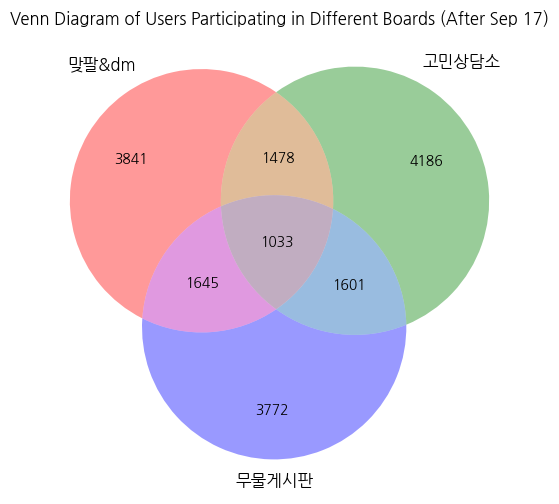

In [190]:
# ✅ 2. event_properties에서 "name" 값 추출
df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
    lambda x: x.get('name') if isinstance(x, dict) and 'name' in x else None
)

# ✅ 3. 각 게시판 사용자 그룹 추출
board_names = ["맞팔&dm", "고민상담소", "무물게시판"]
board_users = {board: set(df_after_sep17[df_after_sep17['board_name'] == board]['user_id'].unique()) for board in board_names}

# ✅ 4. 벤다이어그램 생성
plt.figure(figsize=(8, 6))
venn = venn3(
    subsets=(
        len(board_users["맞팔&dm"]),
        len(board_users["고민상담소"]),
        len(board_users["맞팔&dm"] & board_users["고민상담소"]),
        len(board_users["무물게시판"]),
        len(board_users["맞팔&dm"] & board_users["무물게시판"]),
        len(board_users["고민상담소"] & board_users["무물게시판"]),
        len(board_users["맞팔&dm"] & board_users["고민상담소"] & board_users["무물게시판"])
    ),
    set_labels=("맞팔&dm", "고민상담소", "무물게시판")
)

plt.title("Venn Diagram of Users Participating in Different Boards (After Sep 17)")
plt.show()

#### 네트워크 확장(맞팔&DM 게시판 이용 여부)

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\398245417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\398245417.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['visit_date'] = df_after_sep17['Asia/Seoul'].dt.date  # 날짜만 추출



📊 [9월 17일 이후] 평균 방문 일수 비교:
🔹 맞팔&dm 활동 유저: 6.27 일
🔹 맞팔&dm 비활동 유저: 3.04 일

📊 [9월 17일 이후] 유저 수 비교:
🔹 맞팔&dm 활동 유저 수: 3841
🔹 맞팔&dm 비활동 유저 수: 125628

📊 [9월 17일 이후] T-검정 결과:
🔹 T-statistic: 59.0078, p-value: 0.0000


C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\398245417.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([active_visit_days, inactive_visit_days], labels=["Active Users", "Inactive Users"], patch_artist=True)


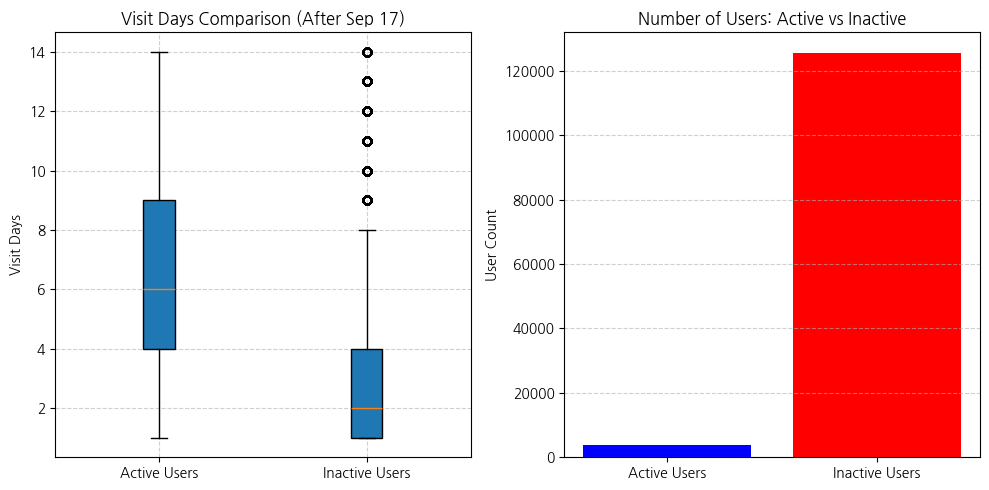

In [191]:
# ✅ 2. event_properties에서 "name"이 "맞팔&dm"인 경우만 선택
df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
    lambda x: x.get('name') if isinstance(x, dict) and 'name' in x else None
)

# ✅ 3. 맞팔&dm에서 활동한 유저 추출
community_events = [
    "click_community_board", "click_community_post",
    "click_community_write_post", "click_community_write_comment"
]

active_users = df_after_sep17[
    (df_after_sep17['event_key'].isin(community_events)) & 
    (df_after_sep17['board_name'] == "맞팔&dm")
]['user_id'].unique()

# ✅ 4. 방문 일수 계산 (user_id 기준 unique한 방문 날짜 수)
df_after_sep17['visit_date'] = df_after_sep17['Asia/Seoul'].dt.date  # 날짜만 추출
visit_days = df_after_sep17.groupby('user_id')['visit_date'].nunique().reset_index()
visit_days.rename(columns={'visit_date': 'visit_days'}, inplace=True)

# ✅ 5. 그룹 나누기 (맞팔&dm 활동 유저 vs 비활동 유저)
visit_days['group'] = visit_days['user_id'].apply(lambda x: 'active' if x in active_users else 'inactive')

# ✅ 6. 각 그룹 방문 일수 평균 계산
active_visit_days = visit_days[visit_days['group'] == 'active']['visit_days']
inactive_visit_days = visit_days[visit_days['group'] == 'inactive']['visit_days']

mean_active = active_visit_days.mean()
mean_inactive = inactive_visit_days.mean()

# ✅ 7. 맞팔&dm 활동 유저 수 확인
num_active_users = len(active_users)
num_inactive_users = len(visit_days) - num_active_users

print(f"\n📊 [9월 17일 이후] 평균 방문 일수 비교:")
print(f"🔹 맞팔&dm 활동 유저: {mean_active:.2f} 일")
print(f"🔹 맞팔&dm 비활동 유저: {mean_inactive:.2f} 일")

print(f"\n📊 [9월 17일 이후] 유저 수 비교:")
print(f"🔹 맞팔&dm 활동 유저 수: {num_active_users}")
print(f"🔹 맞팔&dm 비활동 유저 수: {num_inactive_users}")

# ✅ 8. T-검정(T-test) 수행 (두 그룹의 평균 차이가 통계적으로 유의미한지 검정)
t_stat, p_value = ttest_ind(active_visit_days, inactive_visit_days, equal_var=False)
print(f"\n📊 [9월 17일 이후] T-검정 결과:")
print(f"🔹 T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# ✅ 9. 시각화: 맞팔&dm 활동 여부에 따른 방문 일수 비교
plt.figure(figsize=(10, 5))

# 박스플롯 (방문 일수 비교)
plt.subplot(1, 2, 1)
plt.boxplot([active_visit_days, inactive_visit_days], labels=["Active Users", "Inactive Users"], patch_artist=True)
plt.title("Visit Days Comparison (After Sep 17)")
plt.ylabel("Visit Days")
plt.grid(True, linestyle="--", alpha=0.6)

# 바 차트 (활동 유저 수 비교)
plt.subplot(1, 2, 2)
plt.bar(["Active Users", "Inactive Users"], [num_active_users, num_inactive_users], color=['blue', 'red'])
plt.title("Number of Users: Active vs Inactive")
plt.ylabel("User Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 그래프 출력
plt.tight_layout()
plt.show()

#### 자기표현 욕구(무물 게시판 이용 여부)

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1323027292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1323027292.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['visit_date'] = df_after_sep17['Asia/Seoul'].dt.date  # 날짜만 추출



📊 [9월 17일 이후] 평균 방문 일수 비교:
🔹 무물게시판 활동 유저: 6.75 일
🔹 무물게시판 비활동 유저: 3.03 일

📊 [9월 17일 이후] 유저 수 비교:
🔹 무물게시판 활동 유저 수: 3772
🔹 무물게시판 비활동 유저 수: 125697

📊 [9월 17일 이후] T-검정 결과:
🔹 T-statistic: 67.5930, p-value: 0.0000


C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1323027292.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([active_visit_days, inactive_visit_days], labels=["Active Users", "Inactive Users"], patch_artist=True)


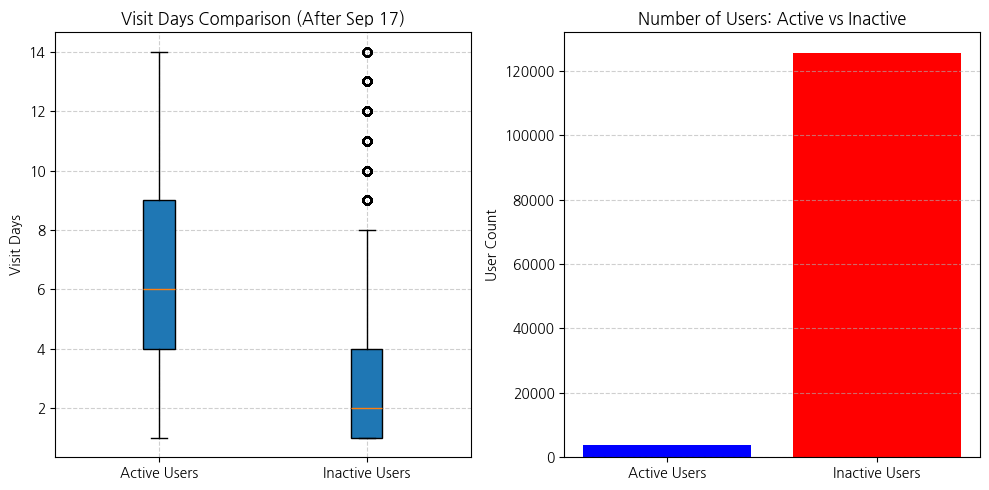

In [192]:
# ✅ 2. event_properties에서 "name"이 "무물게시판"인 경우만 선택
df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
    lambda x: x.get('name') if isinstance(x, dict) and 'name' in x else None
)

# ✅ 3. 무물게시판에서 활동한 유저 추출
community_events = [
    "click_community_board", "click_community_post",
    "click_community_write_post", "click_community_write_comment"
]

active_users = df_after_sep17[
    (df_after_sep17['event_key'].isin(community_events)) & 
    (df_after_sep17['board_name'] == "무물게시판")
]['user_id'].unique()

# ✅ 4. 방문 일수 계산 (user_id 기준 unique한 방문 날짜 수)
df_after_sep17['visit_date'] = df_after_sep17['Asia/Seoul'].dt.date  # 날짜만 추출
visit_days = df_after_sep17.groupby('user_id')['visit_date'].nunique().reset_index()
visit_days.rename(columns={'visit_date': 'visit_days'}, inplace=True)

# ✅ 5. 그룹 나누기 (무물게시판 활동 유저 vs 비활동 유저)
visit_days['group'] = visit_days['user_id'].apply(lambda x: 'active' if x in active_users else 'inactive')

# ✅ 6. 각 그룹 방문 일수 평균 계산
active_visit_days = visit_days[visit_days['group'] == 'active']['visit_days']
inactive_visit_days = visit_days[visit_days['group'] == 'inactive']['visit_days']

mean_active = active_visit_days.mean()
mean_inactive = inactive_visit_days.mean()

# ✅ 7. 무물게시판 활동 유저 수 확인
num_active_users = len(active_users)
num_inactive_users = len(visit_days) - num_active_users

print(f"\n📊 [9월 17일 이후] 평균 방문 일수 비교:")
print(f"🔹 무물게시판 활동 유저: {mean_active:.2f} 일")
print(f"🔹 무물게시판 비활동 유저: {mean_inactive:.2f} 일")

print(f"\n📊 [9월 17일 이후] 유저 수 비교:")
print(f"🔹 무물게시판 활동 유저 수: {num_active_users}")
print(f"🔹 무물게시판 비활동 유저 수: {num_inactive_users}")

# ✅ 8. T-검정(T-test) 수행 (두 그룹의 평균 차이가 통계적으로 유의미한지 검정)
t_stat, p_value = ttest_ind(active_visit_days, inactive_visit_days, equal_var=False)
print(f"\n📊 [9월 17일 이후] T-검정 결과:")
print(f"🔹 T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# ✅ 9. 시각화: 무물게시판 활동 여부에 따른 방문 일수 비교
plt.figure(figsize=(10, 5))

# 박스플롯 (방문 일수 비교)
plt.subplot(1, 2, 1)
plt.boxplot([active_visit_days, inactive_visit_days], labels=["Active Users", "Inactive Users"], patch_artist=True)
plt.title("Visit Days Comparison (After Sep 17)")
plt.ylabel("Visit Days")
plt.grid(True, linestyle="--", alpha=0.6)

# 바 차트 (활동 유저 수 비교)
plt.subplot(1, 2, 2)
plt.bar(["Active Users", "Inactive Users"], [num_active_users, num_inactive_users], color=['blue', 'red'])
plt.title("Number of Users: Active vs Inactive")
plt.ylabel("User Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 그래프 출력
plt.tight_layout()
plt.show()

#### 자유 게시판

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\4274740701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\4274740701.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['visit_date'] = df_after_sep17['Asia/Seoul'].dt.date  # 날짜만 추출



📊 [9월 17일 이후] 평균 방문 일수 비교:
🔹 자유게시판 활동 유저: 6.34 일
🔹 자유게시판 비활동 유저: 2.99 일

📊 [9월 17일 이후] 유저 수 비교:
🔹 자유게시판 활동 유저 수: 5726
🔹 자유게시판 비활동 유저 수: 123743

📊 [9월 17일 이후] T-검정 결과:
🔹 T-statistic: 75.9389, p-value: 0.0000


C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\4274740701.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([active_visit_days, inactive_visit_days], labels=["Active Users", "Inactive Users"], patch_artist=True)


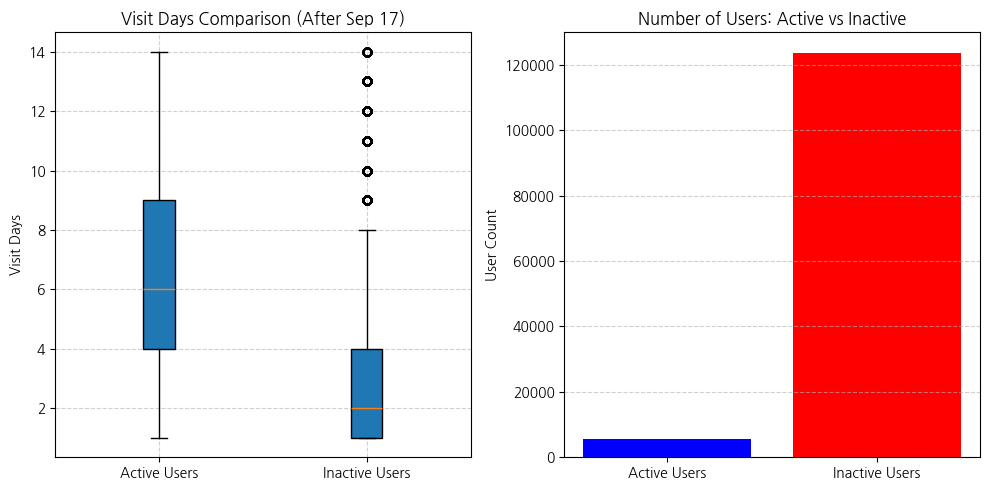

In [193]:
# ✅ 2. event_properties에서 "name"이 "자유게시판"인 경우만 선택
df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
    lambda x: x.get('name') if isinstance(x, dict) and 'name' in x else None
)

# ✅ 3. 자유게시판에서 활동한 유저 추출
community_events = [
    "click_community_board", "click_community_post",
    "click_community_write_post", "click_community_write_comment"
]

active_users = df_after_sep17[
    (df_after_sep17['event_key'].isin(community_events)) & 
    (df_after_sep17['board_name'] == "자유게시판")
]['user_id'].unique()

# ✅ 4. 방문 일수 계산 (user_id 기준 unique한 방문 날짜 수)
df_after_sep17['visit_date'] = df_after_sep17['Asia/Seoul'].dt.date  # 날짜만 추출
visit_days = df_after_sep17.groupby('user_id')['visit_date'].nunique().reset_index()
visit_days.rename(columns={'visit_date': 'visit_days'}, inplace=True)

# ✅ 5. 그룹 나누기 (자유게시판 활동 유저 vs 비활동 유저)
visit_days['group'] = visit_days['user_id'].apply(lambda x: 'active' if x in active_users else 'inactive')

# ✅ 6. 각 그룹 방문 일수 평균 계산
active_visit_days = visit_days[visit_days['group'] == 'active']['visit_days']
inactive_visit_days = visit_days[visit_days['group'] == 'inactive']['visit_days']

mean_active = active_visit_days.mean()
mean_inactive = inactive_visit_days.mean()

# ✅ 7. 자유게시판 활동 유저 수 확인
num_active_users = len(active_users)
num_inactive_users = len(visit_days) - num_active_users

print(f"\n📊 [9월 17일 이후] 평균 방문 일수 비교:")
print(f"🔹 자유게시판 활동 유저: {mean_active:.2f} 일")
print(f"🔹 자유게시판 비활동 유저: {mean_inactive:.2f} 일")

print(f"\n📊 [9월 17일 이후] 유저 수 비교:")
print(f"🔹 자유게시판 활동 유저 수: {num_active_users}")
print(f"🔹 자유게시판 비활동 유저 수: {num_inactive_users}")

# ✅ 8. T-검정(T-test) 수행 (두 그룹의 평균 차이가 통계적으로 유의미한지 검정)
t_stat, p_value = ttest_ind(active_visit_days, inactive_visit_days, equal_var=False)
print(f"\n📊 [9월 17일 이후] T-검정 결과:")
print(f"🔹 T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# ✅ 9. 시각화: 자유게시판 활동 여부에 따른 방문 일수 비교
plt.figure(figsize=(10, 5))

# 박스플롯 (방문 일수 비교)
plt.subplot(1, 2, 1)
plt.boxplot([active_visit_days, inactive_visit_days], labels=["Active Users", "Inactive Users"], patch_artist=True)
plt.title("Visit Days Comparison (After Sep 17)")
plt.ylabel("Visit Days")
plt.grid(True, linestyle="--", alpha=0.6)

# 바 차트 (활동 유저 수 비교)
plt.subplot(1, 2, 2)
plt.bar(["Active Users", "Inactive Users"], [num_active_users, num_inactive_users], color=['blue', 'red'])
plt.title("Number of Users: Active vs Inactive")
plt.ylabel("User Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 그래프 출력
plt.tight_layout()
plt.show()

#### 고민 상담소

C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1807511299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1807511299.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_sep17['visit_date'] = df_after_sep17['Asia/Seoul'].dt.date  # 날짜만 추출



📊 [9월 17일 이후] 평균 방문 일수 비교:
🔹 고민상담소 활동 유저: 6.47 일
🔹 고민상담소 비활동 유저: 3.03 일

📊 [9월 17일 이후] 유저 수 비교:
🔹 고민상담소 활동 유저 수: 4186
🔹 고민상담소 비활동 유저 수: 125283

📊 [9월 17일 이후] T-검정 결과:
🔹 T-statistic: 66.5991, p-value: 0.0000


C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\1807511299.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([active_visit_days, inactive_visit_days], labels=["Active Users", "Inactive Users"], patch_artist=True)


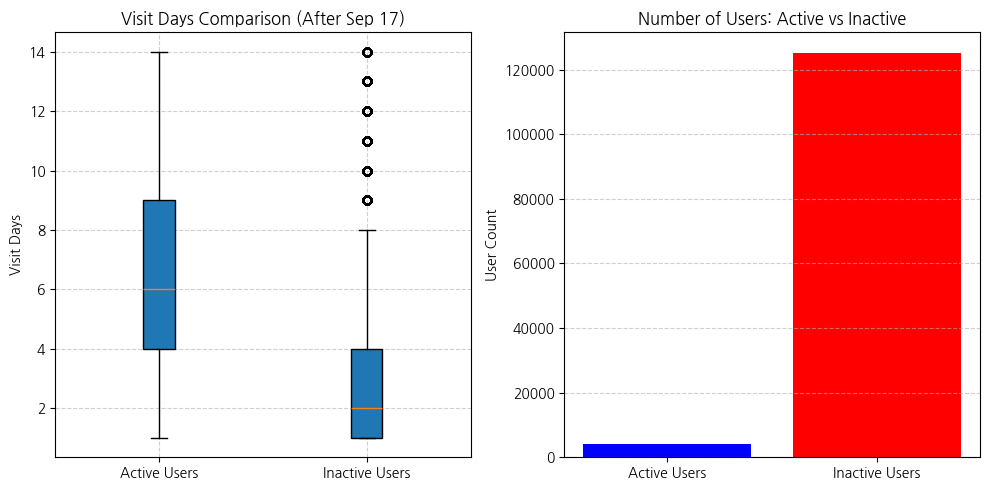

In [194]:
# ✅ 2. event_properties에서 "name"이 "고민상담소"인 경우만 선택
df_after_sep17['board_name'] = df_after_sep17['event_properties'].apply(
    lambda x: x.get('name') if isinstance(x, dict) and 'name' in x else None
)

# ✅ 3. 고민상담소에서 활동한 유저 추출
community_events = [
    "click_community_board", "click_community_post",
    "click_community_write_post", "click_community_write_comment"
]

active_users = df_after_sep17[
    (df_after_sep17['event_key'].isin(community_events)) & 
    (df_after_sep17['board_name'] == "고민상담소")
]['user_id'].unique()

# ✅ 4. 방문 일수 계산 (user_id 기준 unique한 방문 날짜 수)
df_after_sep17['visit_date'] = df_after_sep17['Asia/Seoul'].dt.date  # 날짜만 추출
visit_days = df_after_sep17.groupby('user_id')['visit_date'].nunique().reset_index()
visit_days.rename(columns={'visit_date': 'visit_days'}, inplace=True)

# ✅ 5. 그룹 나누기 (고민상담소 활동 유저 vs 비활동 유저)
visit_days['group'] = visit_days['user_id'].apply(lambda x: 'active' if x in active_users else 'inactive')

# ✅ 6. 각 그룹 방문 일수 평균 계산
active_visit_days = visit_days[visit_days['group'] == 'active']['visit_days']
inactive_visit_days = visit_days[visit_days['group'] == 'inactive']['visit_days']

mean_active = active_visit_days.mean()
mean_inactive = inactive_visit_days.mean()

# ✅ 7. 고민상담소 활동 유저 수 확인
num_active_users = len(active_users)
num_inactive_users = len(visit_days) - num_active_users

print(f"\n📊 [9월 17일 이후] 평균 방문 일수 비교:")
print(f"🔹 고민상담소 활동 유저: {mean_active:.2f} 일")
print(f"🔹 고민상담소 비활동 유저: {mean_inactive:.2f} 일")

print(f"\n📊 [9월 17일 이후] 유저 수 비교:")
print(f"🔹 고민상담소 활동 유저 수: {num_active_users}")
print(f"🔹 고민상담소 비활동 유저 수: {num_inactive_users}")

# ✅ 8. T-검정(T-test) 수행 (두 그룹의 평균 차이가 통계적으로 유의미한지 검정)
t_stat, p_value = ttest_ind(active_visit_days, inactive_visit_days, equal_var=False)
print(f"\n📊 [9월 17일 이후] T-검정 결과:")
print(f"🔹 T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# ✅ 9. 시각화: 고민상담소 활동 여부에 따른 방문 일수 비교
plt.figure(figsize=(10, 5))

# 박스플롯 (방문 일수 비교)
plt.subplot(1, 2, 1)
plt.boxplot([active_visit_days, inactive_visit_days], labels=["Active Users", "Inactive Users"], patch_artist=True)
plt.title("Visit Days Comparison (After Sep 17)")
plt.ylabel("Visit Days")
plt.grid(True, linestyle="--", alpha=0.6)

# 바 차트 (활동 유저 수 비교)
plt.subplot(1, 2, 2)
plt.bar(["Active Users", "Inactive Users"], [num_active_users, num_inactive_users], color=['blue', 'red'])
plt.title("Number of Users: Active vs Inactive")
plt.ylabel("User Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 그래프 출력
plt.tight_layout()
plt.show()

#### 커뮤니티 채팅

In [195]:
# ✅ 1️⃣ 데이터 로드
df = df_after_sep17.copy()  # 기존 데이터 복사

# ✅ 2️⃣ 채팅 관련 이벤트 필터링
chat_events = ["view_message_detail", "click_timeline_chat_start",
               "click_community_post_chat_complete", "click_community_comment_chat_complete"]

# ✅ 3️⃣ 채팅을 한 유저 목록
chat_users = df[df['event_key'].isin(chat_events)]['user_id'].unique()

# ✅ 4️⃣ 채팅을 하지 않은 유저 목록
all_users = df['user_id'].unique()
non_chat_users = list(set(all_users) - set(chat_users))

# ✅ 5️⃣ 유저별 방문일수 & 7일 이내 재방문 여부 계산
# 방문일수(Visit Days): 유저별 중복 제거한 방문일 수 계산
user_visits = df.groupby('user_id')['visit_date'].nunique().reset_index()
user_visits.columns = ['user_id', 'visit_days']

# ✅ 6️⃣ 7일 이내 재방문 여부 추가
# 최근 7일 기준으로 재방문 여부 확인
latest_date = df['visit_date'].max()  # 가장 최신 방문일 가져오기
df['recent_activity'] = df['visit_date'] >= (latest_date - pd.Timedelta(days=7))

# 유저별 최근 7일 동안 활동한 기록이 있는지 확인 (0: 미방문, 1: 재방문)
retention_7d = df.groupby('user_id')['recent_activity'].max().reset_index()
retention_7d.columns = ['user_id', 'retention_7d']

# ✅ 7️⃣ 데이터 병합
user_data = user_visits.merge(retention_7d, on='user_id')

# ✅ 8️⃣ 채팅 유저 vs 비채팅 유저 그룹화
user_data['is_chat_user'] = user_data['user_id'].apply(lambda x: 1 if x in chat_users else 0)

# ✅ 9️⃣ 평균 방문일수 비교 (T-검정)
chat_group = user_data[user_data['is_chat_user'] == 1]['visit_days']
non_chat_group = user_data[user_data['is_chat_user'] == 0]['visit_days']

t_stat, p_value_ttest = stats.ttest_ind(chat_group, non_chat_group, equal_var=False)

# ✅ 🔟 7일 이내 재방문율 비교 (카이제곱 검정)
contingency_table = pd.crosstab(user_data['is_chat_user'], user_data['retention_7d'])
chi2_stat, p_value_chi2, _, _ = stats.chi2_contingency(contingency_table)

# ✅ 11️⃣ 결과 출력
print(f"📊 [평균 방문일수 비교]")
print(f"채팅 유저 평균 방문일수: {chat_group.mean():.2f}")
print(f"비채팅 유저 평균 방문일수: {non_chat_group.mean():.2f}")
print(f"T-검정 결과: T-statistic={t_stat:.4f}, p-value={p_value_ttest:.4f}")

print("\n📊 [7일 이내 재방문율 비교]")
print(f"카이제곱 검정 결과: Chi2-statistic={chi2_stat:.4f}, p-value={p_value_chi2:.4f}")

# ✅ 12️⃣ 유의미한 차이 해석
if p_value_ttest < 0.05:
    print("\n✅ 평균 방문일수 차이는 통계적으로 유의미함 (채팅 유저와 비채팅 유저 간 차이 존재)")
else:
    print("\n❌ 평균 방문일수 차이는 유의미하지 않음 (채팅 유저와 비채팅 유저 간 차이 없음)")

if p_value_chi2 < 0.05:
    print("✅ 7일 이내 재방문율 차이는 통계적으로 유의미함 (채팅 유저가 더 자주 재방문할 가능성 있음)")
else:
    print("❌ 7일 이내 재방문율 차이는 유의미하지 않음 (채팅 유저와 비채팅 유저 간 차이 없음)")

📊 [평균 방문일수 비교]
채팅 유저 평균 방문일수: 4.20
비채팅 유저 평균 방문일수: 2.99
T-검정 결과: T-statistic=50.3542, p-value=0.0000

📊 [7일 이내 재방문율 비교]
카이제곱 검정 결과: Chi2-statistic=444.1994, p-value=0.0000

✅ 평균 방문일수 차이는 통계적으로 유의미함 (채팅 유저와 비채팅 유저 간 차이 존재)
✅ 7일 이내 재방문율 차이는 통계적으로 유의미함 (채팅 유저가 더 자주 재방문할 가능성 있음)


In [196]:
# ✅ 1️⃣ 데이터 로드
df = df_after_sep17.copy()  # 기존 데이터 복사

# ✅ 2️⃣ 채팅 관련 이벤트 필터링
chat_events = ["click_community_post_chat_complete", "click_community_comment_chat_complete"]

# ✅ 3️⃣ 채팅을 한 유저 목록
chat_users = df[df['event_key'].isin(chat_events)]['user_id'].unique()

# ✅ 4️⃣ 채팅을 하지 않은 유저 목록
all_users = df['user_id'].unique()
non_chat_users = list(set(all_users) - set(chat_users))

# ✅ 5️⃣ 유저별 방문일수 & 7일 이내 재방문 여부 계산
# 방문일수(Visit Days): 유저별 중복 제거한 방문일 수 계산
user_visits = df.groupby('user_id')['visit_date'].nunique().reset_index()
user_visits.columns = ['user_id', 'visit_days']

# ✅ 6️⃣ 7일 이내 재방문 여부 추가
# 최근 7일 기준으로 재방문 여부 확인
latest_date = df['visit_date'].max()  # 가장 최신 방문일 가져오기
df['recent_activity'] = df['visit_date'] >= (latest_date - pd.Timedelta(days=7))

# 유저별 최근 7일 동안 활동한 기록이 있는지 확인 (0: 미방문, 1: 재방문)
retention_7d = df.groupby('user_id')['recent_activity'].max().reset_index()
retention_7d.columns = ['user_id', 'retention_7d']

# ✅ 7️⃣ 데이터 병합
user_data = user_visits.merge(retention_7d, on='user_id')

# ✅ 8️⃣ 채팅 유저 vs 비채팅 유저 그룹화
user_data['is_chat_user'] = user_data['user_id'].apply(lambda x: 1 if x in chat_users else 0)

# ✅ 9️⃣ 평균 방문일수 비교 (T-검정)
chat_group = user_data[user_data['is_chat_user'] == 1]['visit_days']
non_chat_group = user_data[user_data['is_chat_user'] == 0]['visit_days']

t_stat, p_value_ttest = stats.ttest_ind(chat_group, non_chat_group, equal_var=False)

# ✅ 🔟 7일 이내 재방문율 비교 (카이제곱 검정)
contingency_table = pd.crosstab(user_data['is_chat_user'], user_data['retention_7d'])
chi2_stat, p_value_chi2, _, _ = stats.chi2_contingency(contingency_table)

# ✅ 11️⃣ 결과 출력
print(f"📊 [평균 방문일수 비교]")
print(f"채팅 유저 평균 방문일수: {chat_group.mean():.2f}")
print(f"비채팅 유저 평균 방문일수: {non_chat_group.mean():.2f}")
print(f"T-검정 결과: T-statistic={t_stat:.4f}, p-value={p_value_ttest:.4f}")

print("\n📊 [7일 이내 재방문율 비교]")
print(f"카이제곱 검정 결과: Chi2-statistic={chi2_stat:.4f}, p-value={p_value_chi2:.4f}")

# ✅ 12️⃣ 유의미한 차이 해석
if p_value_ttest < 0.05:
    print("\n✅ 평균 방문일수 차이는 통계적으로 유의미함 (채팅 유저와 비채팅 유저 간 차이 존재)")
else:
    print("\n❌ 평균 방문일수 차이는 유의미하지 않음 (채팅 유저와 비채팅 유저 간 차이 없음)")

if p_value_chi2 < 0.05:
    print("✅ 7일 이내 재방문율 차이는 통계적으로 유의미함 (채팅 유저가 더 자주 재방문할 가능성 있음)")
else:
    print("❌ 7일 이내 재방문율 차이는 유의미하지 않음 (채팅 유저와 비채팅 유저 간 차이 없음)")

📊 [평균 방문일수 비교]
채팅 유저 평균 방문일수: 8.38
비채팅 유저 평균 방문일수: 3.12
T-검정 결과: T-statistic=32.1871, p-value=0.0000

📊 [7일 이내 재방문율 비교]
카이제곱 검정 결과: Chi2-statistic=201.6620, p-value=0.0000

✅ 평균 방문일수 차이는 통계적으로 유의미함 (채팅 유저와 비채팅 유저 간 차이 존재)
✅ 7일 이내 재방문율 차이는 통계적으로 유의미함 (채팅 유저가 더 자주 재방문할 가능성 있음)


C:\Users\a0_0g\AppData\Local\Temp\ipykernel_17504\294574831.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


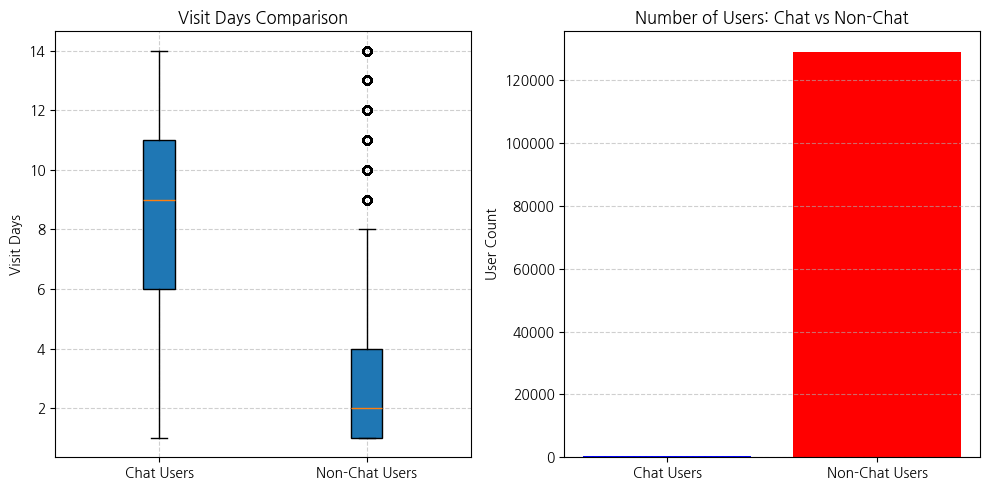

In [197]:
# 박스플롯 (방문 일수 비교)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.boxplot(
    [user_data[user_data['is_chat_user'] == 1]['visit_days'], 
     user_data[user_data['is_chat_user'] == 0]['visit_days']],
    labels=["Chat Users", "Non-Chat Users"], patch_artist=True)
plt.title("Visit Days Comparison")
plt.ylabel("Visit Days")
plt.grid(True, linestyle="--", alpha=0.6)

# 바 차트 (유저 수 비교)
plt.subplot(1, 2, 2)
num_chat_users = user_data[user_data['is_chat_user'] == 1].shape[0]
num_non_chat_users = user_data[user_data['is_chat_user'] == 0].shape[0]
plt.bar(["Chat Users", "Non-Chat Users"], [num_chat_users, num_non_chat_users], color=['blue', 'red'])
plt.title("Number of Users: Chat vs Non-Chat")
plt.ylabel("User Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 그래프 출력
plt.tight_layout()
plt.show()

In [198]:
# ✅ 1️⃣ 채팅 관련 이벤트 & 게시판 클릭 이벤트 필터링
chat_events = ["click_community_post_chat_complete", "click_community_comment_chat_complete"]
post_events = ["click_community_post"]  # 게시판 클릭 이벤트

# ✅ 2️⃣ 게시판 클릭(`click_community_post`) 이벤트에서 게시판 이름 추출
df_posts = df_after_sep17[df_after_sep17['event_key'].isin(post_events)].copy()

# event_properties에서 게시판 이름 추출 함수
def extract_board_name(properties):
    try:
        props = json.loads(properties.replace("'", "\"")) if isinstance(properties, str) else properties
        return props.get("name", "Unknown")  # 'name' 키에서 게시판 이름 추출
    except:
        return "Unknown"

df_posts['board_name'] = df_posts['event_properties'].apply(extract_board_name)

# ✅ 3️⃣ 유저별 가장 최근 게시판 클릭 정보 저장
df_posts = df_posts[['user_id', 'visit_date', 'board_name']]
df_posts = df_posts.sort_values(by=['user_id',  'visit_date'], ascending=True)
df_posts = df_posts.drop_duplicates(subset=['user_id'], keep='last')  # 가장 최근의 게시판 정보만 유지

# ✅ 4️⃣ 채팅 이벤트 데이터 필터링
df_chat = df_2309[df_2309['event_key'].isin(chat_events)].copy()

# ✅ 5️⃣ 채팅 이벤트와 게시판 정보 병합 (같은 user_id 기준)
df_chat = df_chat.merge(df_posts, on=['user_id'], how='left')

# ✅ 6️⃣ 게시판별 채팅 이벤트 발생 횟수 집계
board_chat_counts = df_chat.groupby(['board_name', 'event_key']).size().reset_index(name='chat_count')

# ✅ 7️⃣ 게시판별 총 채팅 횟수 계산
total_chat_per_board = df_chat.groupby('board_name').size().reset_index(name='total_chats')

# ✅ 8️⃣ 데이터 병합 (게시판별 이벤트 유형별 카운트 + 총 채팅 횟수)
final_df = board_chat_counts.merge(total_chat_per_board, on='board_name')

# ✅ 9️⃣ 게시판별 채팅 비율 계산
final_df['chat_percentage'] = (final_df['chat_count'] / final_df['total_chats']) * 100

# ✅ 🔟 결과 정렬 (채팅 발생량이 많은 순)
final_df = final_df.sort_values(by=['total_chats'], ascending=False)

# ✅ 🔟 결과 출력
print("📊 [게시판별 채팅 이벤트 발생 횟수]")
print(final_df)

# ✅ 11️⃣ 상위 5개 게시판 출력
print("\n📊 [게시판별 채팅 이벤트 발생 횟수 Top 5]")
print(final_df.head(10))

📊 [게시판별 채팅 이벤트 발생 횟수]
     board_name                              event_key  chat_count  \
12        맞팔&dm  click_community_comment_chat_complete          74   
13        맞팔&dm     click_community_post_chat_complete        1643   
14        무물게시판  click_community_comment_chat_complete          17   
15        무물게시판     click_community_post_chat_complete        1178   
19        자유게시판  click_community_comment_chat_complete          17   
20        자유게시판     click_community_post_chat_complete         327   
17        운동게시판     click_community_post_chat_complete         183   
7         공부게시판     click_community_post_chat_complete         157   
8         내 게시물  click_community_comment_chat_complete          15   
9         내 게시물     click_community_post_chat_complete         138   
10  내가 댓글 단 게시물  click_community_comment_chat_complete           2   
11  내가 댓글 단 게시물     click_community_post_chat_complete         119   
22       중2 게시판     click_community_post_chat_complete          93  

## 부록

Asia/Seoul        0
event_key         0
user_id       91862
dtype: int64


<Figure size 800x500 with 0 Axes>

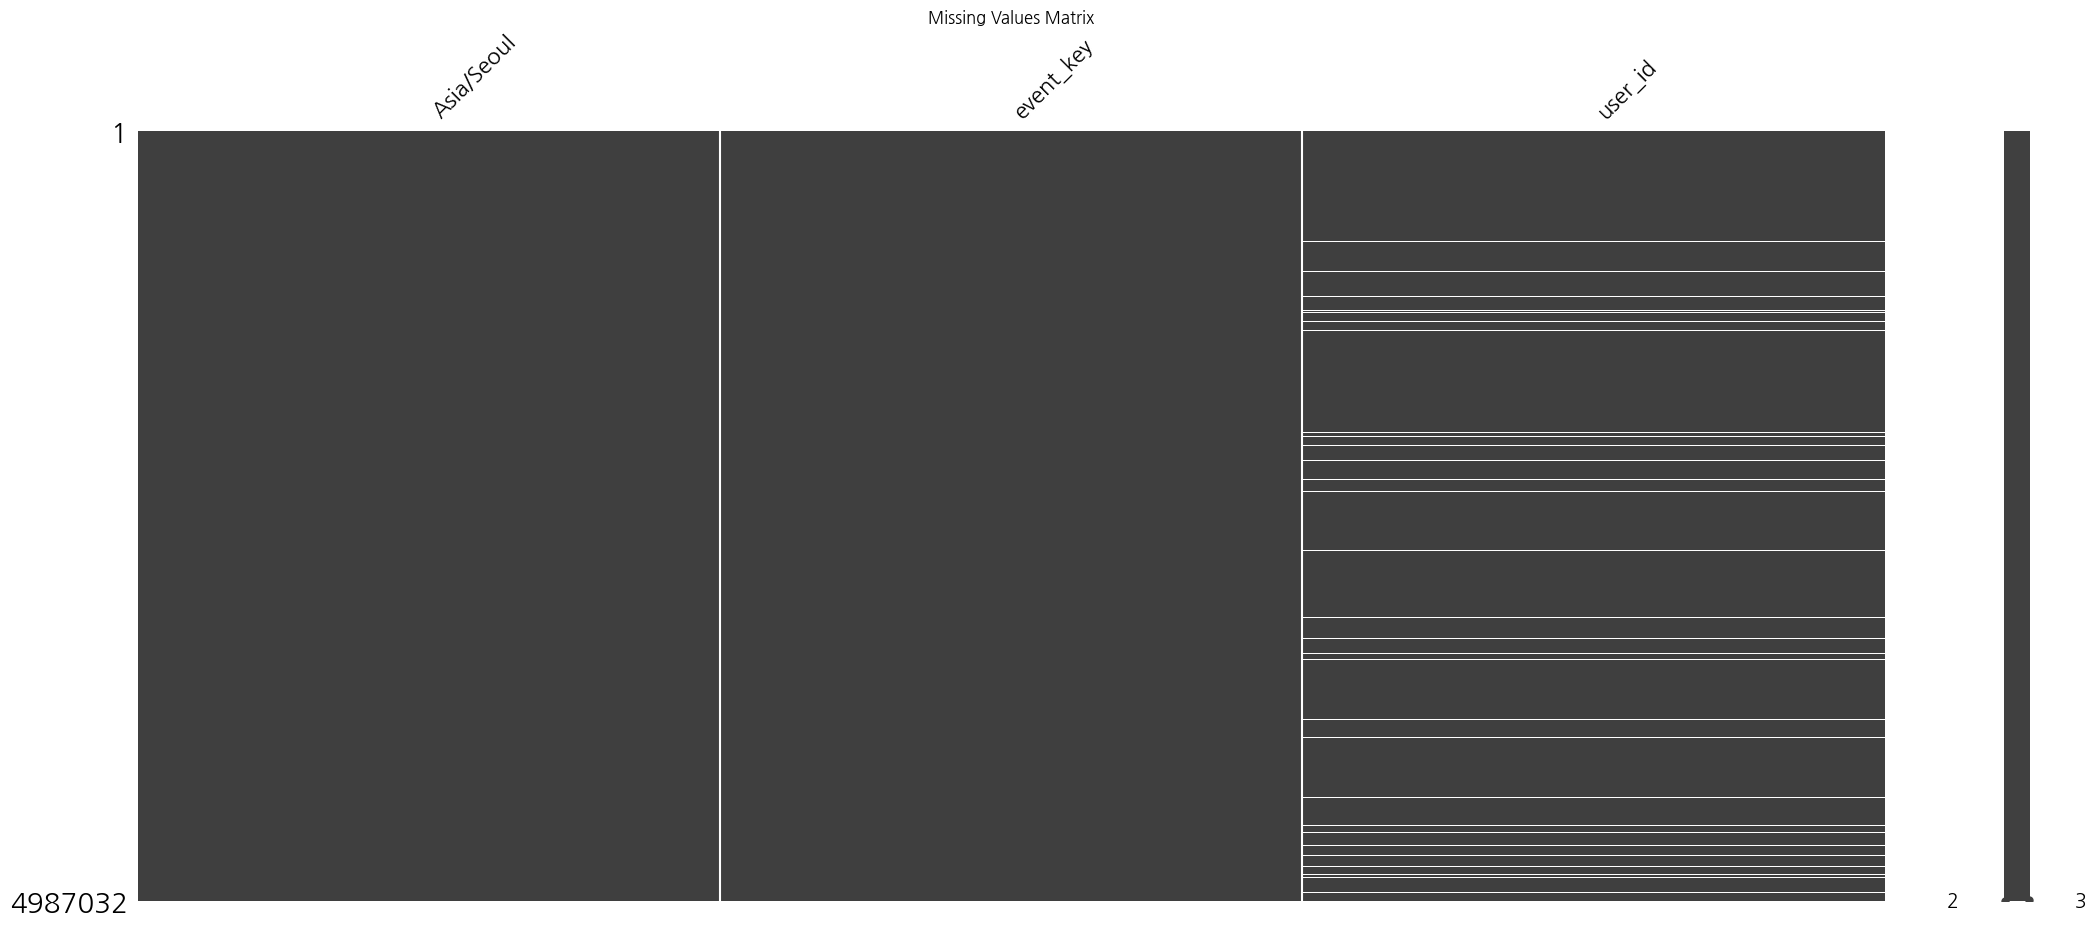

In [199]:
# 결측치 개수 확인
missing_values = df_2308[['Asia/Seoul', 'event_key', 'user_id']].isnull().sum()

# 결측치 개수 출력
print(missing_values)

# 결측치 행렬 그래프
plt.figure(figsize=(8, 5))
msno.matrix(df_2308[['Asia/Seoul', 'event_key', 'user_id']])
plt.title("Missing Values Matrix")
plt.show()

Asia/Seoul          0
event_key           0
user_id             0
event_properties    0
dtype: int64


<Figure size 800x500 with 0 Axes>

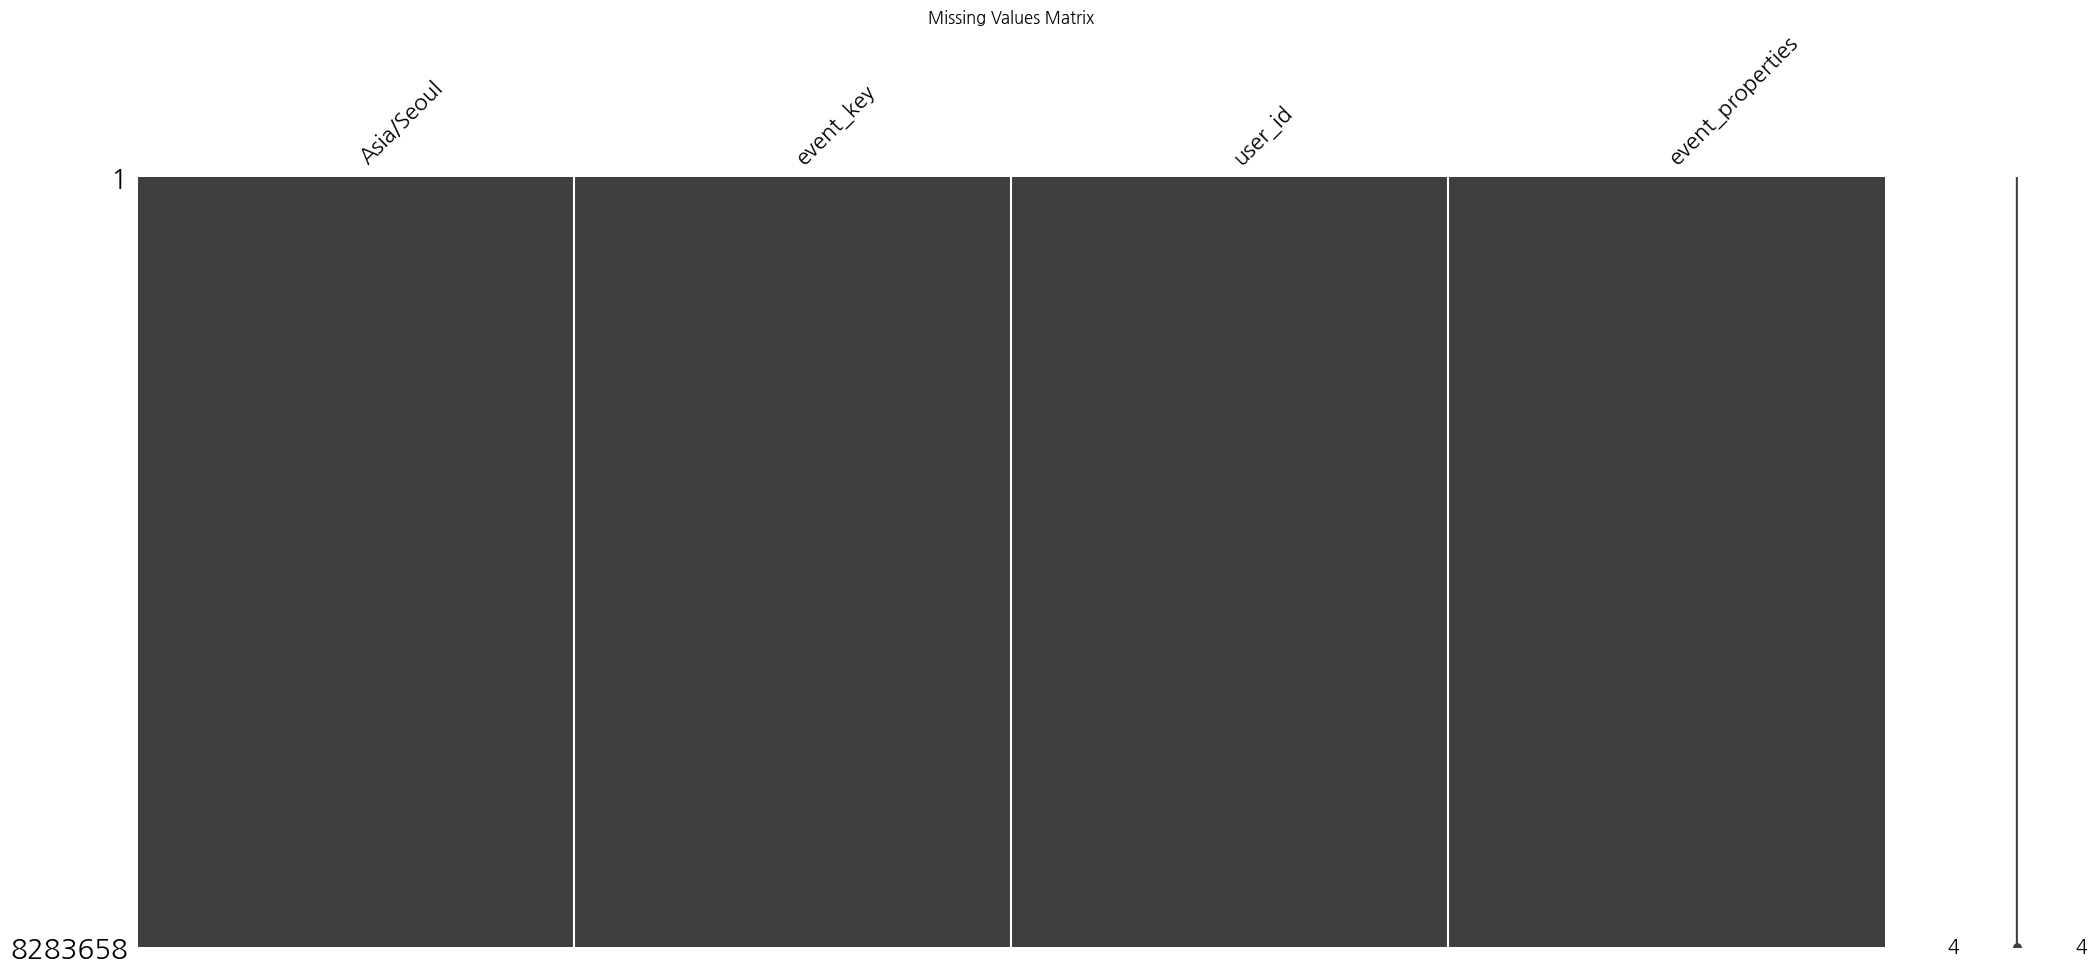

In [200]:
# 결측치 개수 확인
missing_values = df_2309[['Asia/Seoul', 'event_key', 'user_id','event_properties']].isnull().sum()

# 결측치 개수 출력
print(missing_values)

# 결측치 행렬 그래프
plt.figure(figsize=(8, 5))
msno.matrix(df_2309[['Asia/Seoul', 'event_key', 'user_id','event_properties']])
plt.title("Missing Values Matrix")
plt.show()

컬럼별 결측치 개수:
 created_at               0
chosen_user_id           0
user_id                  0
status                   0
user_gender              0
chosen_user_gender       0
question_id              0
question_category     8662
dtype: int64

컬럼별 결측치 비율(%):
 created_at            0.000000
chosen_user_id        0.000000
user_id               0.000000
status                0.000000
user_gender           0.000000
chosen_user_gender    0.000000
question_id           0.000000
question_category     0.784118
dtype: float64


<Figure size 1000x600 with 0 Axes>

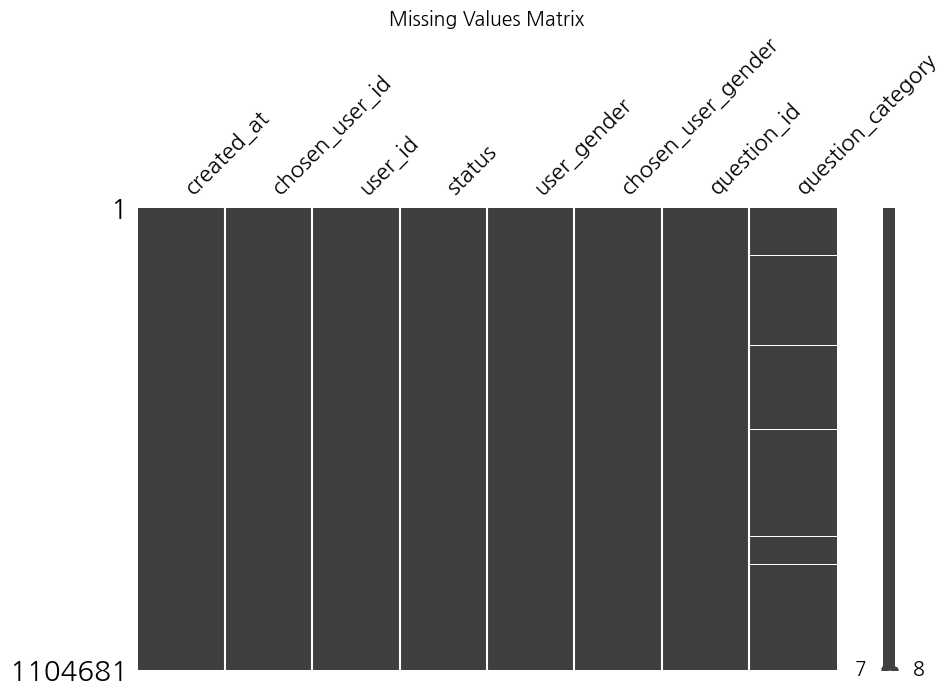

In [202]:
# 분석할 컬럼 리스트
columns_to_check = [
    "created_at", "chosen_user_id", "user_id", "status", 
    "user_gender", "chosen_user_gender", "question_id", "question_category"
]

# 1. 지정된 컬럼들의 결측치 개수 확인
missing_values = df_vote[columns_to_check].isnull().sum()
print("컬럼별 결측치 개수:\n", missing_values)

# 2. 지정된 컬럼들의 결측치 비율 확인
missing_ratio = (df_vote[columns_to_check].isnull().sum() / len(df_vote)) * 100
print("\n컬럼별 결측치 비율(%):\n", missing_ratio)

# 3. 지정된 컬럼들의 결측치 행렬 그래프 출력
plt.figure(figsize=(10, 6))
msno.matrix(df_vote[columns_to_check], figsize=(10, 6), sparkline=True)
plt.title("Missing Values Matrix", fontsize=14)
plt.show()